# Курс Специализация Data Science. Дипломный проект. 
# Бриф «Лаборатории исследований гражданского общества». Определение уязвимых групп населения.

Александр Журавлев
***
***

Нам предоставлены данные о доходах, заболеваемости, социально незащищённых слоях населения России и другие экономические и демографические данные.

# Задача:
- кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения;
- описать группы населения, сталкивающиеся с бедностью;
- определить:
    - влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе;
    - связаны ли уровень бедности/социального неблагополучия с производством и потреблением в регионе;
    - какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения.

**Примечания:**
- Методологии подсчёта некоторых показателей могли меняться за время их наблюдения.
- Не всегда один и тот же регион пишется одинаково в разных датасетах. Такое очень часто происходит с написаниями регионов РФ в разных документах, а также в других странах (их нет в данной задаче). Это необходимо учитывать при объединении датасетов.
- Особенностью Тюменской области является то, что в её состав входят два других субъекта Российской Федерации: Ханты-Мансийский автономный округ — Югра и Ямало-Ненецкий автономный округ. При этом чаще всего в датасетах указывается отдельно Тюменская область и отдельно — без учёта автономных округов.
- То же самое касается Архангельской области — в её состав входит самостоятельный субъект Ненецкий автономный округ. Способы написания такие же, как с Тюменской областью.
- Нежелательно использовать данные по федеральному округу в совокупности. Во-первых, это агрегированные данные, и чаще всего по ним нельзя сделать никаких интересных выводов, а во-вторых, на протяжении последних 20 лет составы федеральных округов менялись (некоторые регионы меняли принадлежность к округу), из-за чего в них мог произойти резкий рост/снижение численности населения, что не отображало какое-то демографическое явление.
***
***

# 2 Этап: Feature engineering + EDA + Feature selection

# План решения:

Feature Engineering:
- Необходимо продумать какие еще признаки можно создать на основе имеющихся для кластеризации регионов.
#
EDA:
- **Ключевой признак** (и его производные) для решения нашей задачи - **poverty_percent** *Процент людей, живущих за чертой бедности с денежными доходами ниже величины прожиточного минимума*. Он представлен нам в изначальных данных и расчеты выполнены согласно методологии.
- Дополнительные признаки (и их производные) для детального изучения, в т.ч. их взаимосвязи между собой и **ключевым признаком**:
    - **real_incomes** - *Реальные денежные доходы, в процентах к предыдущему году*
    - **real_pay** - *Реальная начисленная заработная плата, в процентах к предыдущему году*
    - **poor** - *Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения*
- Необходимо изучить распределение признаков датасета на нормальность и, исходя из результатов, выбрать тип тестов и корреляций для дальнейшего изучения взаимосвязей в датасете. 
- Найти взаимосвязи между признаками, которые помогут нам отбрать те из них, которые будут использованы для кластеризации.
#
Feature Selection:
- На основе проведенного EDA отобрать признаки для кластеризации.
#
**Примечание:** под производными признака подразумеваются признаки **_per_of_rf**, **_trend**, **_bad_region**. Например, для признака **poverty_percent** его производные - это признаки **poverty_percent_per_of_rf**, **poverty_percent_trend**, **poverty_percent_bad_region**.

***
***

## 0. Подготовительный этап

### Загрузка необходимых библиотек

In [1]:
# для работы с таблицами
import pandas as pd
# для вычислений и работы с массивами
import numpy as np

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

# импортируем тест Шапиро-Уилка
from scipy.stats import shapiro
# импортируем тест Д'Агостино
from scipy.stats import normaltest
# импортируем корреляционный тест Спирмена
from scipy.stats import spearmanr
# импортируем тест Xi-квадрат
from sklearn.feature_selection import chi2
# импортируем корреляцию Мэтьюса
from sklearn.metrics import matthews_corrcoef
# для расчета критерия Краскела — Уоллиса 
import scipy.stats as stats

# импорт из собственного модуля
from project_module import (
    # функция выводит распределение значений признака датафрейма в виде гистограммы
    feature_histogram,
    # функция проводит тесты Шапиро и Д'Агостино для последовательности
    normal_test,
    # функция проводит тесты Шапиро и Д'Агостино для всех признаков датафрейма
    normal_test_df,
    # функция визуализирует корреляции Пирсона,Спирмена,Кендалла в виде тепловой карты
    corr_visual,
    # функция рассчитывает коореляции с Пирсона,Спирмена,Кендалла с целевым признаком
    target_corr_visual,
    # функция рассчитывает коореляцию Мэтьюса бинарных признаков с целевым признаком
    target_matthews_corrcoef,
    # для создания уникальных пар для вычисления корреляции
    get_redundant_pairs,
    # функция рассчитывает коореляции с Пирсона,Спирмена,Кендалла по парам признаков и выводит топ пар
    get_top_abs_correlations,
    # функция проводит тест Xi-квадрат целевого признака с другими признаками датафрейма
    target_xi2_test
    )

# для экспорта списка отобранных признаков в файл
import json

***
***


## 1. Загрузка и знакомство с данными

In [2]:
# загрузка данных
data = pd.read_csv('data_output/data_final.csv')
print(f'Размерность: {data.shape}')
print(f'Количество пропусков: {data.isna().sum().sum()}')
display(data.head())

Размерность: (85, 126)
Количество пропусков: 0


region  population  population_trend  \
0                          Алтайский край   2268179.0                -1   
1                        Амурская область    772525.0                -1   
2  Архангельская область без Ненецкого АО   1069782.0                -1   
3                    Астраханская область    989430.0                -1   
4                    Белгородская область   1531917.0                 1   

   population_per_of_rf  population_bad_region  real_incomes  \
0                  1.56                      1          95.5   
1                  0.53                      1         100.3   
2                  0.73                      1          98.4   
3                  0.68                      1          97.1   
4                  1.05                      0          98.1   

   real_incomes_trend  real_incomes_per_of_rf  real_incomes_bad_region  \
0                   1                   96.86                        1   
1                   1                  101.72                        0   
2                   1                   99.80                        0   
3                   1                   98.48                        0   
4                  -1                   99.49                        1   

   real_pay  ...  children_serious_crimes_per_of_rf  \
0     103.8  ...                              92.86   
1     105.2  ...                             132.14   
2     102.9  ...                             107.14   
3     104.5  ...                             125.00   
4     104.8  ...                              96.43   

   children_serious_crimes_bad_region  repeat_serious_crimes  \
0                                   0                   18.0   
1                                   1                   24.0   
2                                   0                   21.0   
3                                   1                   20.0   
4                                   0                   17.0   

   repeat_serious_crimes_trend  repeat_serious_crimes_per_of_rf  \
0                            1                             90.0   
1                            1                            120.0   
2                            0                            105.0   
3                            1                            100.0   
4                            1                             85.0   

   repeat_serious_crimes_bad_region  drunk_serious_crimes  \
0                                 0                  14.0   
1                                 0                  18.0   
2                                 0                  26.0   
3                                 0                  10.0   
4                                 0                  17.0   

   drunk_serious_crimes_trend  drunk_serious_crimes_per_of_rf  \
0                           1                           77.78   
1                           1                          100.00   
2                           1                          144.44   
3                          -1                           55.56   
4                           1                           94.44   

   drunk_serious_crimes_bad_region  
0                                0  
1                                0  
2                                1  
3                                0  
4                                0  

[5 rows x 126 columns]

### Признаки в данных:

Численность населения:
- **population** - численность населения за последний представленый год (январь 2022), чел. 
- **population_trend** - тренд численности населения за представленный период (январь 1999 - январь 2022)
- **population_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **population_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет) 
   
Реальные денежные доходы:
- **real_incomes** - реальные денежные доходы, в % к предыдущему году за последний представленный год (2020)
- **real_incomes_trend** - тренд реальных денежных доходов, в % к предыдущему году за представленный период (2015-2020)
- **real_incomes_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **real_incomes_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Реальная начисленная заработная плата:
- **real_pay** - реальная начисленная заработная плата, в процентах к предыдущему году за последний представленый год (2020)
- **real_pay_trend** - тренд реальной начисленной заработной платы, в процентах к предыдущему году за представленный период (2015-2020)
- **real_pay_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **real_pay_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения:
- **poor** - доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за последний представленный год (2022)
- **poor_trend** - тренд доли населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за представленный период (2013-2022)
- **poor_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **poor_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Детская смертность на первом году жизни:
- **child_mortality_100k** - число умерших на первом году жизни детей за год на 100k насления за последний представленный год (2021)
- **child_mortality_100k_trend** - тренд числа умерших на первом году жизни детей за год на 100k насления за представленный период (1999-2021)
- **child_mortality_100k_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **child_mortality_100k_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Число людей с инвалидностью (трудоспособный возраст):
- **disabled_100k** - число людей с инвалидностью на 100k населения (трудоспособный возраст) за последний представленный год (2021)
- **disabled_100k_trend** - тренд числа людей с инвалидностью на 100k населения (трудоспособный возраст) за представленный период (2017-2021)
- **disabled_100k_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **disabled_100k_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Алкоголизм:
- **alco** - заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс. населения за помледний представленый год (2018)
- **alco_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **alco_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Наркомания:
- **drug** - заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс. населения (человек, на 1 января) за последний представленный год (2018)
- **drug_trend** - тренд заболеваемости с впервые в жизни установленным диагнозом наркомании на 100 тыс. населения (человек, на 1 января) за представленный период (2005-2018)
- **drug_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **drug_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Валовой региональный продукт на душу населения:
- **grp** - валовой региональный продукт на душу населения (рубль, значение показателя за год) за последний представленный год (2020)
- **grp_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **grp_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Жилищные условия:
- **constraint** - % домохозяйств, указавших, что при проживании испытывают большую стесненность (2020)
- **constraint_per_of_rf** - отношение показателя региона к показателю РФ в %
- **constraint_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#     
- **living_area** - Размер жилой площади в расчете на члена домохозяйства (2020)
- **living_area_per_of_rf** - отношение показателя региона к показателю РФ в %
- **living_area_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#    
- **very_bad_living_area** - % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания (2020)
- **very_bad_living_area_per_of_rf** - отношение показателя региона к показателю РФ в %
- **very_bad_living_area_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Заболеваемость:
- **general_morbidity** - общая заболеваемость на 100тыс. населения за последний представленный год (2016)
- **general_morbidity_trend** - тренд общей заболеваемость на 100тыс. населения за представленный период (2005-2016)
- **general_morbidity_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **general_morbidity_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **congenital_malformation** - врожденные пороки развития на 100тыс. населения за последний представленный год (2016)
- **congenital_malformation_trend** - тренд врожденных пороков развития на 100тыс. населения за представленный период (2005-2016)
- **congenital_malformation_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **congenital_malformation_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **psychosis**	- психические расстройства и расстройства поведения на 100тыс. населения за последний представленный год (2016)
- **psychosis_trend** - тренд психических расстройств и расстройств поведения на 100тыс. населения за представленный период (2005-2016)
- **psychosis_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **psychosis_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **teenage_pregnancy**	- подростковая беременность (до 14 лет) на 100тыс. населения за последний представленный год (2016)
- **teenage_pregnancy_trend** - тренд подростковой беременности (до 14 лет) на 100тыс. населения за представленный период (2005-2016)
- **teenage_pregnancy_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **teenage_pregnancy_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **conditions_in_perinatal** - отдельные состояния, возникающие в перинатальном периоде на 100тыс. населения за последний представленный год (2016)
- **conditions_in_perinatal_trend** тренд отдельных состояний, возникающих в перинатальном периоде на 100тыс. населения за представленный период (2005-2016)
- **conditions_in_perinatal_per_of_rf**	- отношение показателя региона за последний год к показателю РФ в %
- **conditions_in_perinatal_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Рождаемость:
- **newborn_100k** - количество новорожденных на 100k населения за последний представленный год (2021)
- **newborn_100k_trend** - тренд количества новорожденных на 100k населения за представленный период (2006-2021)
- **newborn_100k_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **newborn_100k_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Население за чертой бедности:
- **poverty_percent** - % людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума) за последний представленный год (2020)
- **poverty_percent_trend** - тренд % людей, живущих за чертой бедности за представленный период (1992-2020)
- **poverty_percent_per_of_rf**	- отношение показателя региона за последний год к показателю РФ в %
- **poverty_percent_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Распределение малоимущего населения по социально-демографическим группам:
- **poverty_socdem_children** - малоимущее население (дети) в % за последний представленный год (2020)
- **poverty_socdem_children_trend** - тренд малоимущего население (дети) в % за представленный период (2017-2020)
- **poverty_socdem_children_per_of_rf**	- отношение показателя региона за последний год к показателю РФ в %
- **poverty_socdem_children_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **poverty_socdem_retired** - малоимущее население (пенсионеры) в % за последний представленный год (2020)
- **poverty_socdem_retired_trend** - тренд малоимущего население (пенсионеры) в % за представленный период (2017-2020)
- **poverty_socdem_retired_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **poverty_socdem_retired_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **poverty_socdem_employable** - малоимущее население (трудоспособное) в % за последний представленный год (2020)
- **poverty_socdem_employable_trend** - тренд малоимущего население (трудоспособное) в % за представленный период (2017-2020)
- **poverty_socdem_employable_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **poverty_socdem_employable_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Региональное производство:
- **mining** - добыча полезных ископаемых за последний представленный год (2020) (в тысячах рублей, значение показателя за год, полный круг)
- **mining_trend** - тренд добычи полезных ископаемых за представленный период (2005-2020) 
- **mining_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **mining_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **manufacturing** - обрабатывающие производства за последний представленный год (2020) (в тысячах рублей, значение показателя за год, полный круг)
- **manufacturing_trend** - тренд обрабатывающих производств за представленный период (2005-2020)
- **manufacturing_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **manufacturing_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **electricity** - обеспечение электроэнергией, газом, паром; кондиционирование воздуха за последний представленный год (2020) (в тысячах рублей, значение показателя за год, полный круг)
- **electricity_trend**	- тренд обеспечения электроэнергией, газом, паром; кондиционирования воздуха за представленный период (2005-2020)
- **electricity_per_of_rf**	- отношение показателя региона за последний год к показателю РФ в %
- **electricity_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **water_supply** - водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за последний представленный год (2020) (в тысячах рублей, значение показателя за год, полный круг)
- **water_supply_trend** - тренд водоснабжения; водоотведения, организации сбора и утилизация отходов, деятельности по ликвидации загрязнений за представленный период (2005-2020)	
- **water_supply_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **water_supply_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **industrial_production**	- промышленное производство за последний представленный год (2020) (в тысячах рублей, значение показателя за год, полный круг)
- **industrial_production_trend** - тренд промышленного производства за представленный период (2005-2020)	
- **industrial_production_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **industrial_production_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Оборот розничной торговли:
- **retail** - оборот розничной торговли на душу населения, в рублях за последний представленный год (2021)
- **retail_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **retail_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Расходы на социальную политику:
- **welfare_expense** - расходы на социальную политику от общих расходов бюджета региона, % в год за последний представленный год (2020)
- **welfare_expense_trend**	- тренд расходов на социальную политику от общих расходов бюджета региона, % в год за представленный период (2015-2020)
- **welfare_expense_per_of_rf**	- отношение показателя региона за последний год к показателю РФ в %
- **welfare_expense_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

Численность населения по возрастным группам:
- **population_children** - удельный вес несовершеннолетних в общей численности населения, в %	
- **population_employable**	- удельный вес трудоспособных в общей численности населения, в %
- **population_retired** - удельный вес пенсионеров в общей численности населения, в %

Преступность:
- **children_serious_crimes** - доля особо тяжких и тяжких преступлений совершенных несовершенолетними в % от всех преступлений за последний представленный год (2021)
- **children_serious_crimes_trend**	- тренд доли особо тяжких и тяжких преступлений совершенных несовершенолетними в % от всех преступлений за представленный период (2016-2021)
- **children_serious_crimes_per_of_rf**	- отношение показателя региона за последний год к показателю РФ в %
- **children_serious_crimes_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **repeat_serious_crimes**	- доля особо тяжких и тяжких преступлений совершенных ранее совершавшими преступления в % от всех преступлений за последний представленный год (2021)
- **repeat_serious_crimes_trend** - тренд доли особо тяжких и тяжких преступлений совершенных ранее совершавшими преступления в % от всех преступлений за представленный период (2016-2021)
- **repeat_serious_crimes_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **repeat_serious_crimes_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)
#
- **drunk_serious_crimes** - доля особо тяжких и тяжких преступлений совершенных в состоянии опьянения в % от всех преступлений за последний представленный год (2021)
- **drunk_serious_crimes_trend** - тренд доли особо тяжких и тяжких преступлений совершенных в состоянии опьянения в % от всех преступлений за представленный период (2016-2021)	
- **drunk_serious_crimes_per_of_rf** - отношение показателя региона за последний год к показателю РФ в %
- **drunk_serious_crimes_bad_region** - плохой регион по данному показателю (1 - да, 0 - нет)

***
***

## 2. Feature engineering

Почти по каждому показателю, характеризующему регионы, мы выделяли признак **bad_region** и проставляли ему значение=1, если регион был плох по данному показателю. Тепереь создадим новый признак **bad_region_sum** где суммируем баллы **bad_region**, которые набрал каждый субъект и определим аутсайдеров.

In [3]:
# новый признак суммирующий все баллы по признакам ***_bad_region
data['bad_region_sum'] = 0

# рассчитываем сумму всех баллов 
for col in data.columns.to_list():
    if '_bad_region' in col:
        data['bad_region_sum'] = data['bad_region_sum'] + data[col]
        
# присвоим имя новой таблице
data.name = 'Сводная таблица для кластеризации'

***
***

## 3. EDA

Кроме признака **region**, все остальные признаки числовые.     
Для проведения EDA нам необходимо выделить следующие типы числовых признаков:
- непрерывные
- категориальные
- дополнительно из **категориальных** признаков выделим **бинарные**

In [4]:
# список с непрерывными признаками
continuous_features = []
# список с категориальными признаками
categorial_features = []
# список с бинарными признаками (выделим дополнительно из категориальных)
binary_features = []

# разделяем числовые признаки по типам
for col in data.iloc[:,1:].columns.to_list():
    if '_trend' in col:
        categorial_features.append(col)
    elif 'bad_region' in col:
        categorial_features.append(col)
        binary_features.append(col)
    else:
        continuous_features.append(col)
        

### 3.1. Проверим нормальность распределения данных

Поочередно проверим каждый признак сводной таблицы на нормальность распределения:

In [5]:
normal_test_df(
    df=data.iloc[:,1:], # данные, кроме признака региона
    alpha=0.05 # уровень значимости
    )

Эти признаки распределены нормально:


* тест Шапиро-Уилка *                 * тест ДАгостино *
1            poverty_socdem_children            poverty_socdem_children
2  poverty_socdem_children_per_of_rf  poverty_socdem_children_per_of_rf
3            children_serious_crimes            children_serious_crimes
4  children_serious_crimes_per_of_rf  children_serious_crimes_per_of_rf
5               drunk_serious_crimes               drunk_serious_crimes
6     drunk_serious_crimes_per_of_rf     drunk_serious_crimes_per_of_rf

**Выводы:**
- признаки с нормальным распределением по обоим тестам представлены выше, их только 6
- все остальные признаки **не распределены нормально**
- будем применять **непараметрические тесты**

***

### 3.2. Признак **bad_region_sum**

Изучим новый созданный признак более подробно:

Сводная таблица для кластеризации


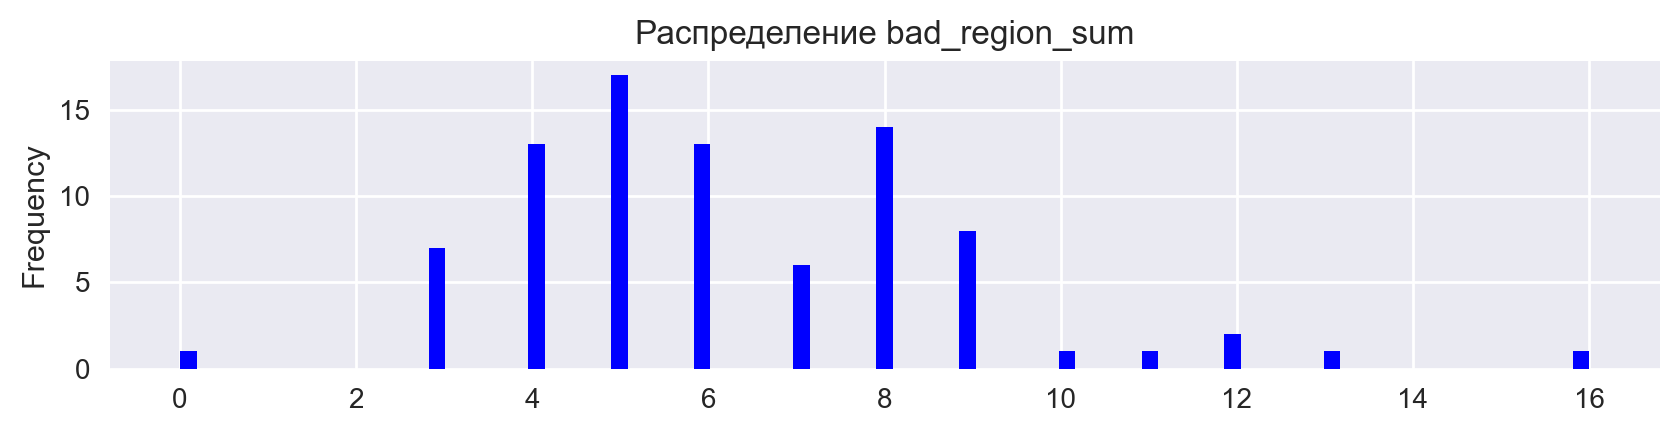

In [6]:
# визуализируем распределение признака
feature_histogram(df=data, feature='bad_region_sum', bins=85)

In [7]:
# расчитаем некоторые показатели
percentiles = np.percentile(data['bad_region_sum'], [25,50,75])
print(f'\nПервый квартиль: {percentiles[0]}')
print(f'Медиана: {percentiles[1]}, среднее: {round(data.bad_region_sum.mean(),1)}')
print(f'Третий квартиль: {percentiles[2]}')
print('\n*** Тесты на нормальность распределения: ***\n')
normal_test(data=data['bad_region_sum'], alpha=0.05)


Первый квартиль: 5.0
Медиана: 6.0, среднее: 6.3
Третий квартиль: 8.0

*** Тесты на нормальность распределения: ***

* тест Шапиро-Уилка *
stat=0.934, p=0.000
Данные не распределены нормально (мы отвергаем H0)

* тест Д'Агостино *
stat=16.180, p=0.000
Данные не распределены нормально (мы отвергаем H0)


Интересно то, что медиана и среднее почти совпадают, но тесты однозначно говорят об отсутствии нормального распределения.

- Отнесем к **аутсайдерам** регионы со значенем > 8 по данному признаку и выведем эти регионы с интересующими нас признаками:

In [8]:
# выведем регионы-аутсайдеры
mask = data['bad_region_sum'] > 8
print(f'Количество регионов: {data[mask].shape[0]}')
display(data[mask][
    ['region', 'bad_region_sum', 'poverty_percent_bad_region', 'real_incomes_bad_region', 'poor_bad_region', 'real_pay_bad_region']])

Количество регионов: 14


region  bad_region_sum  \
0                           Алтайский край              11   
1                         Амурская область               9   
2   Архангельская область без Ненецкого АО               9   
10            Еврейская автономная область              13   
11                      Забайкальский край               9   
24                      Курганская область              12   
32               Ненецкий автономный округ               9   
42                       Псковская область               9   
50                      Республика Карелия               9   
53                     Республика Марий Эл               9   
56       Республика Северная Осетия-Алания               9   
58                         Республика Тыва              16   
82              Чукотский автономный округ              12   
83         Ямало-Ненецкий автономный округ              10   

    poverty_percent_bad_region  real_incomes_bad_region  poor_bad_region  \
0                            0                        1                0   
1                            0                        0                0   
2                            0                        0                0   
10                           1                        0                0   
11                           1                        0                0   
24                           1                        0                0   
32                           0                        0                1   
42                           0                        0                0   
50                           0                        0                0   
53                           1                        0                0   
56                           0                        1                0   
58                           1                        0                0   
82                           0                        0                0   
83                           0                        0                1   

    real_pay_bad_region  
0                     0  
1                     0  
2                     0  
10                    0  
11                    0  
24                    0  
32                    0  
42                    0  
50                    0  
53                    0  
56                    0  
58                    0  
82                    0  
83                    0

**Выводы:**
- У нас 14 регионов-аутсайдеров которые набирают от 9 до 16 баллов (из 32 возможных) по критериям ПЛОХИХ регионов (признаки *bad_region*).
- По % людей ниже черты бедности из них только 5 регионов ПЛОХИЕ (почему?), по реальным денежным доходам в % к предыдущему году только 2 региона ПЛОХИЕ, по доле населения с доходами ниже 40% от медианного тоже только 2 региона плохие, по реальной зарплате в % к предыдущему году вообще нет плохих регионов (!).
- ПЛОХИЕ регионы по критериям указанным в предыдущем пункте не пересекаются (почему???).
- Чукотский автономный округ набирает 12 баллов (что довольно много), но ни по одному из критериев выше не является ПЛОХИМ.
- при снижении фильтра ниже 3-й квартили (>7) мы получаем 28 регионов-аутсайдеров с теми же закономерностями.
- Получается, что **нет однозначной связи** между низкими реальными доходами, долей населения ниже черты бедности и с доходом ниже 40% медианного и статусом региона-аутсайдера.
- Ради интереса пробовал логарифмировать признак, но результат прежний

***

### 3.3. Взаимосвязь признаков **poverty_percent**, **real_incomes**, **poor**, **real_pay** и их производных между собой и признаком **bad_region_sum**

- Выше мы выяснили, что представленные признаки и их производные **не распределены нормально**.

In [9]:
# выделим исследуемые признаки в отдельный датасет
df_research = data[[
    # % людей, живущих за чертой бедности 
    # (с денежными доходами ниже величины прожиточного минимума)
    'poverty_percent',
    'poverty_percent_trend',
    'poverty_percent_per_of_rf',
    'poverty_percent_bad_region',
    # реальные денежные доходы, в % к предыдущему году 
    'real_incomes',
    'real_incomes_trend',
    'real_incomes_per_of_rf',
    'real_incomes_bad_region',
    # доля населения, имеющего среднедушевые денежные доходы ниже 40% 
    # среднедушевого денежного дохода населения
    'poor',
    'poor_trend',
    'poor_per_of_rf',
    'poor_bad_region',
    # реальная начисленная заработная плата, в процентах к предыдущему году 
    'real_pay',
    'real_pay_trend',
    'real_pay_per_of_rf',
    'real_pay_bad_region',

    'bad_region_sum'
]]

- Рассмотрим взаимосвязь **непрерывных числовых признаков** (корреляция Спирмена и Кендалла) и признака **bad_region_sum**:

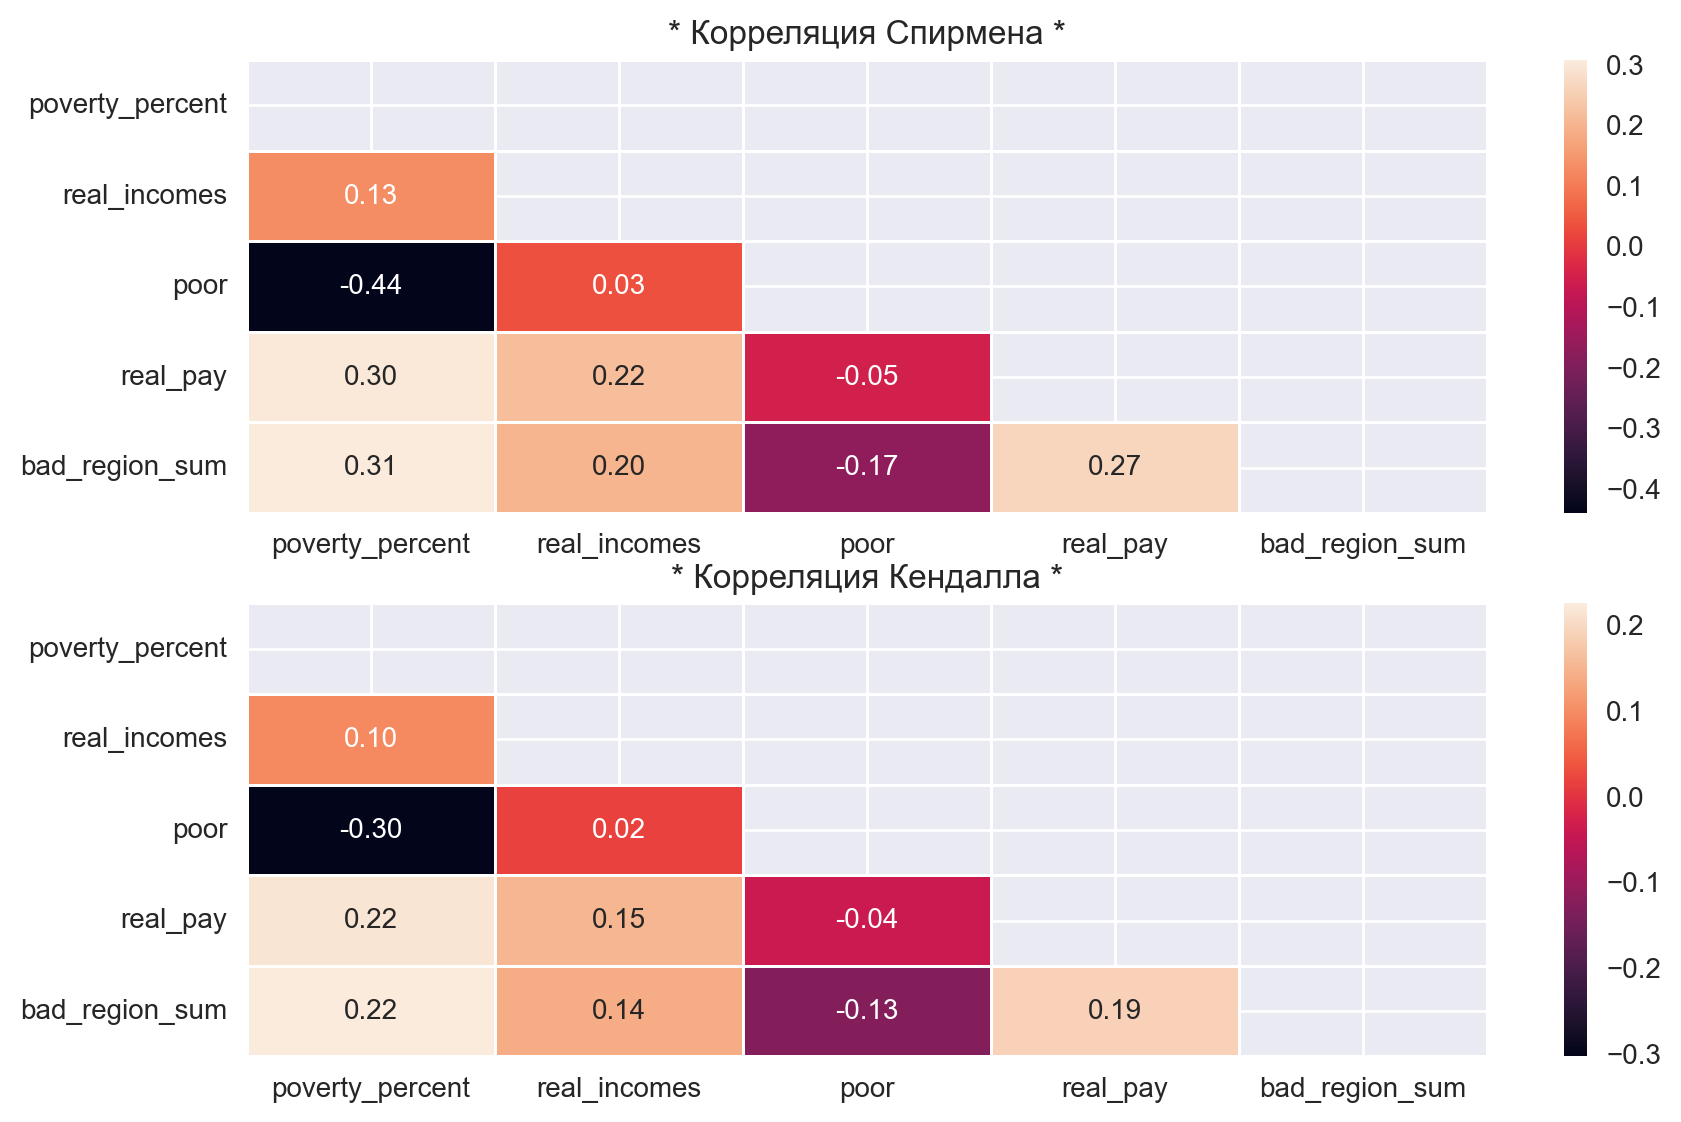

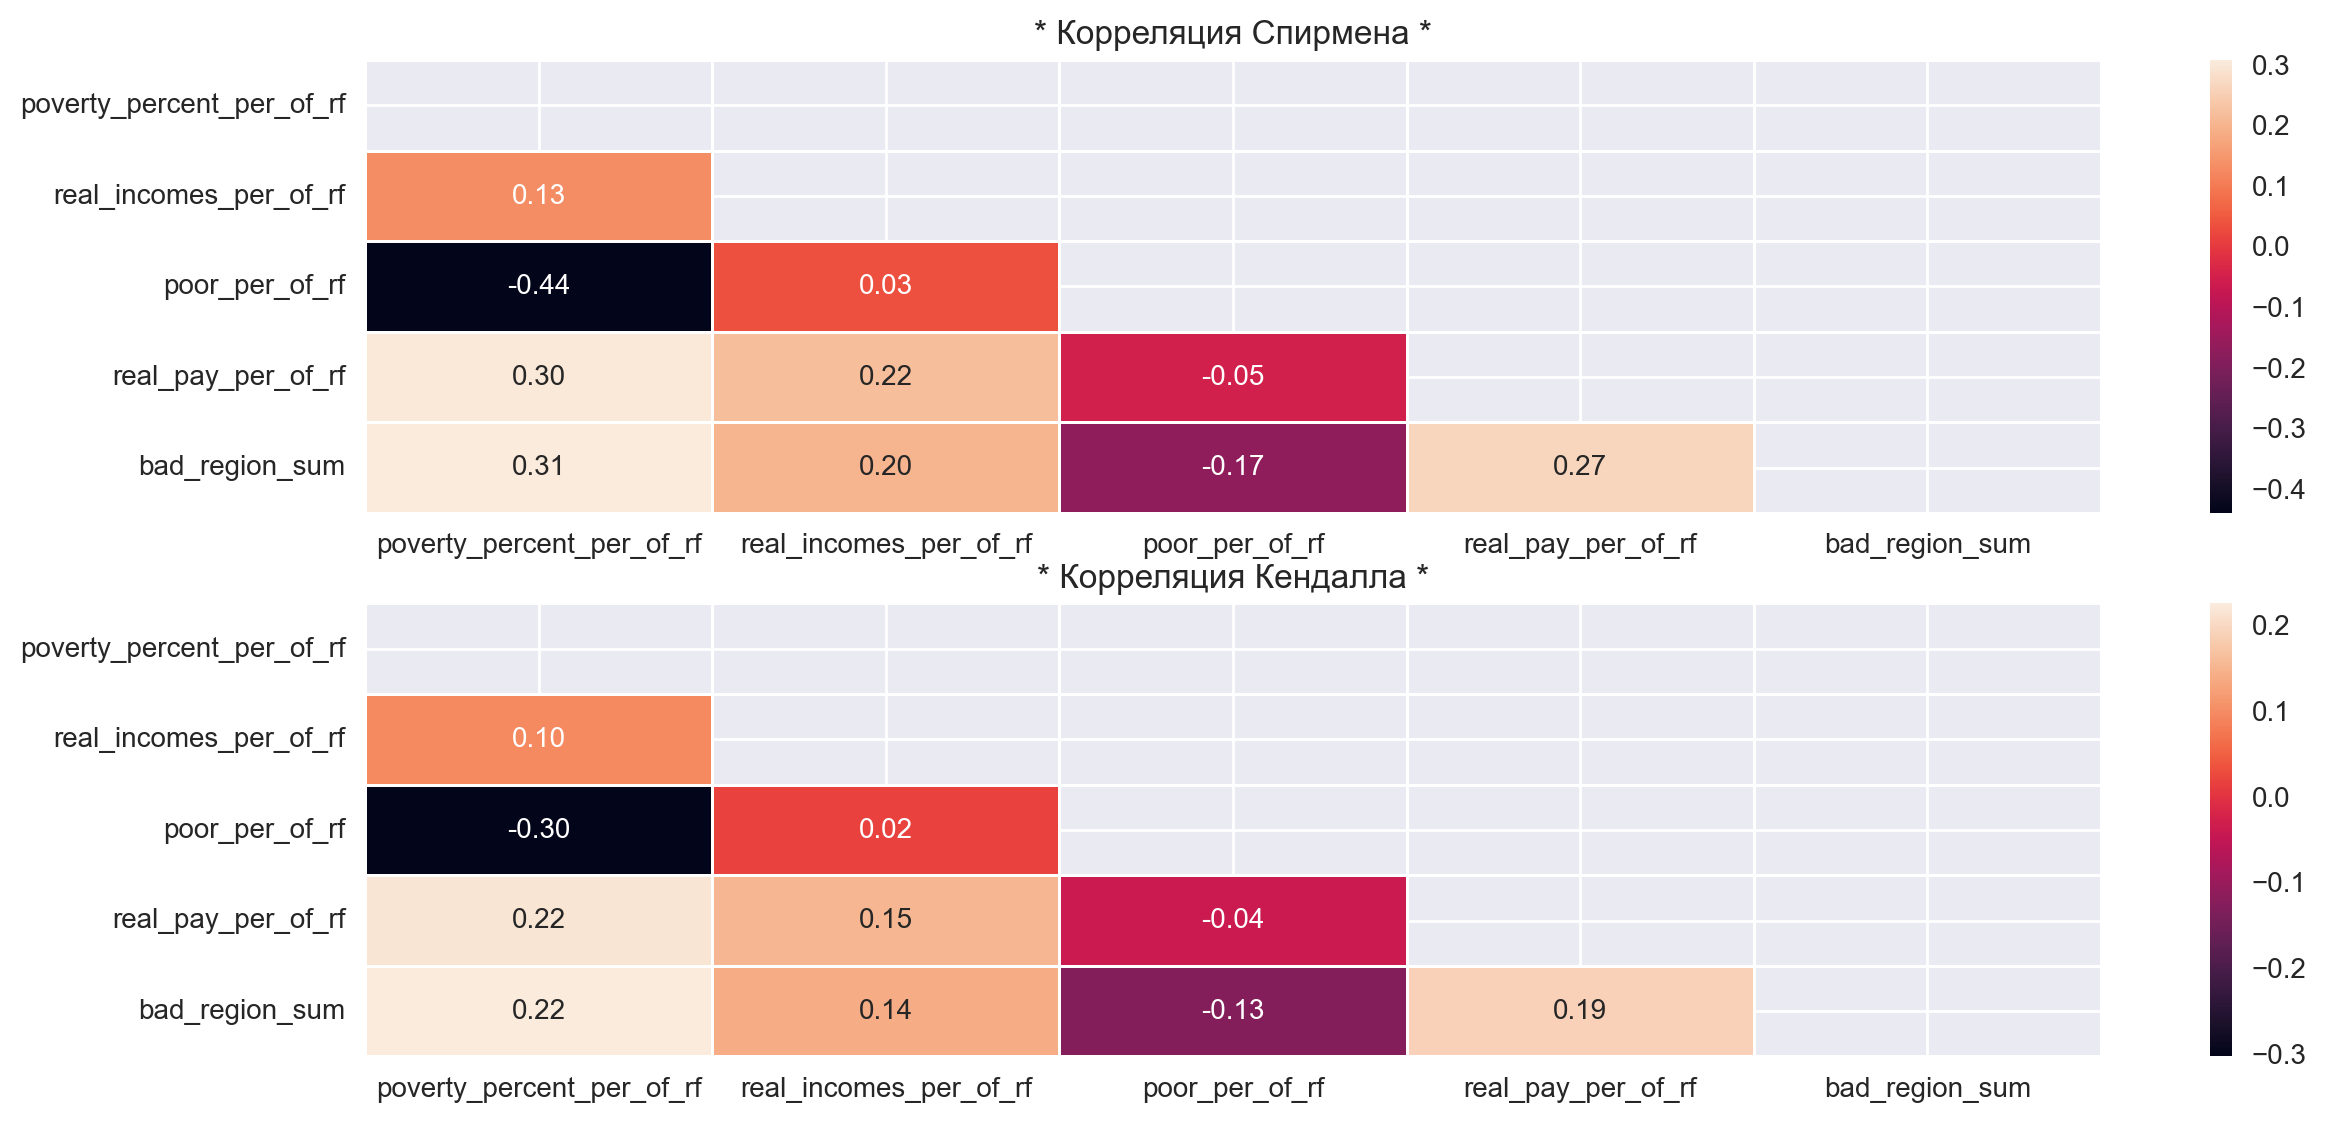

In [10]:
corr_visual(
    data=df_research[[
        'poverty_percent', 'real_incomes', 'poor', 'real_pay', 'bad_region_sum'
    ]], 
    width=10, height=10
    )
corr_visual(
    data=df_research[[
        'poverty_percent_per_of_rf', 'real_incomes_per_of_rf', 'poor_per_of_rf', 'real_pay_per_of_rf', 'bad_region_sum'
    ]], 
    width=14, height=10
    )

- Рассмотрим взаимосвязь **категориальных числовых признаков** (корреляция Спирмена и Кендалла):

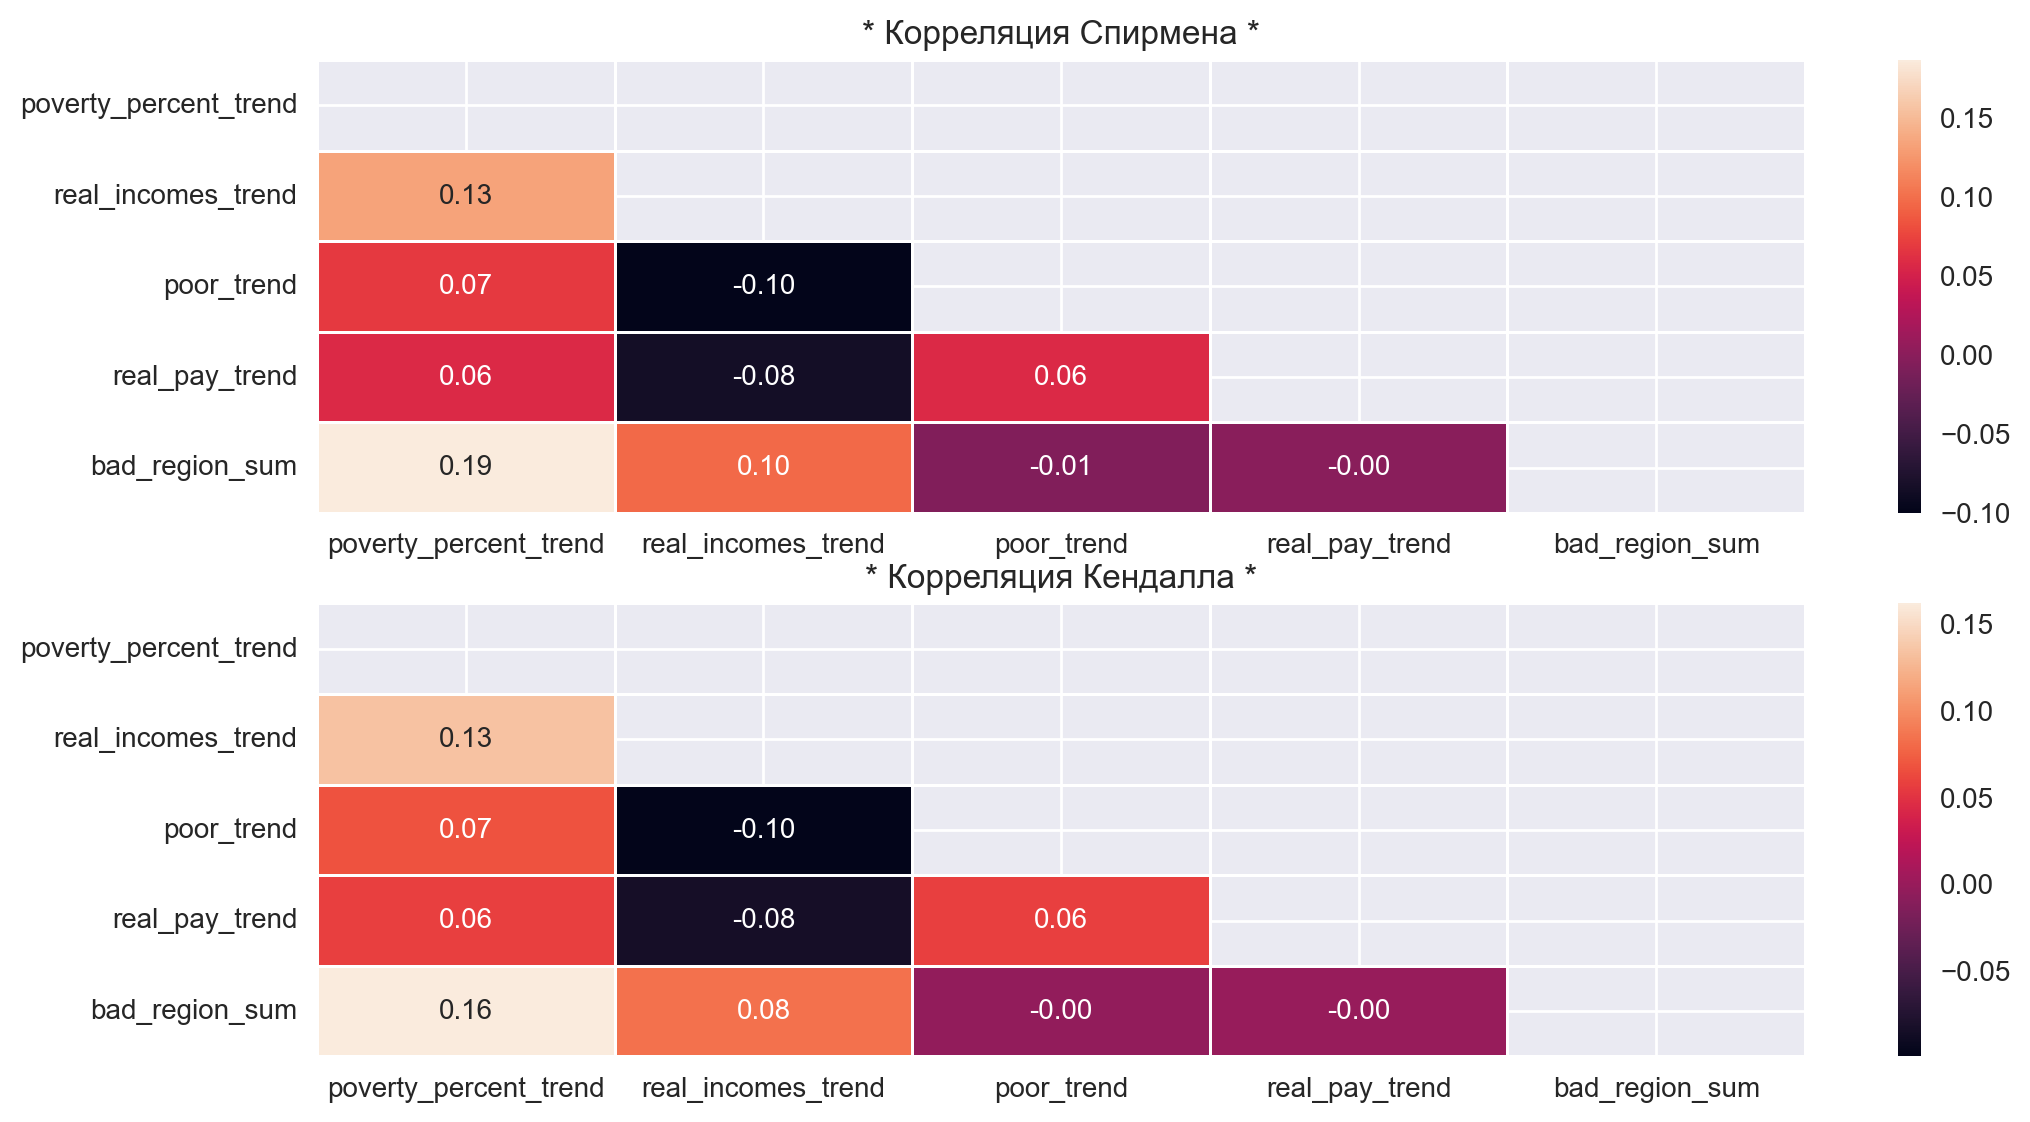

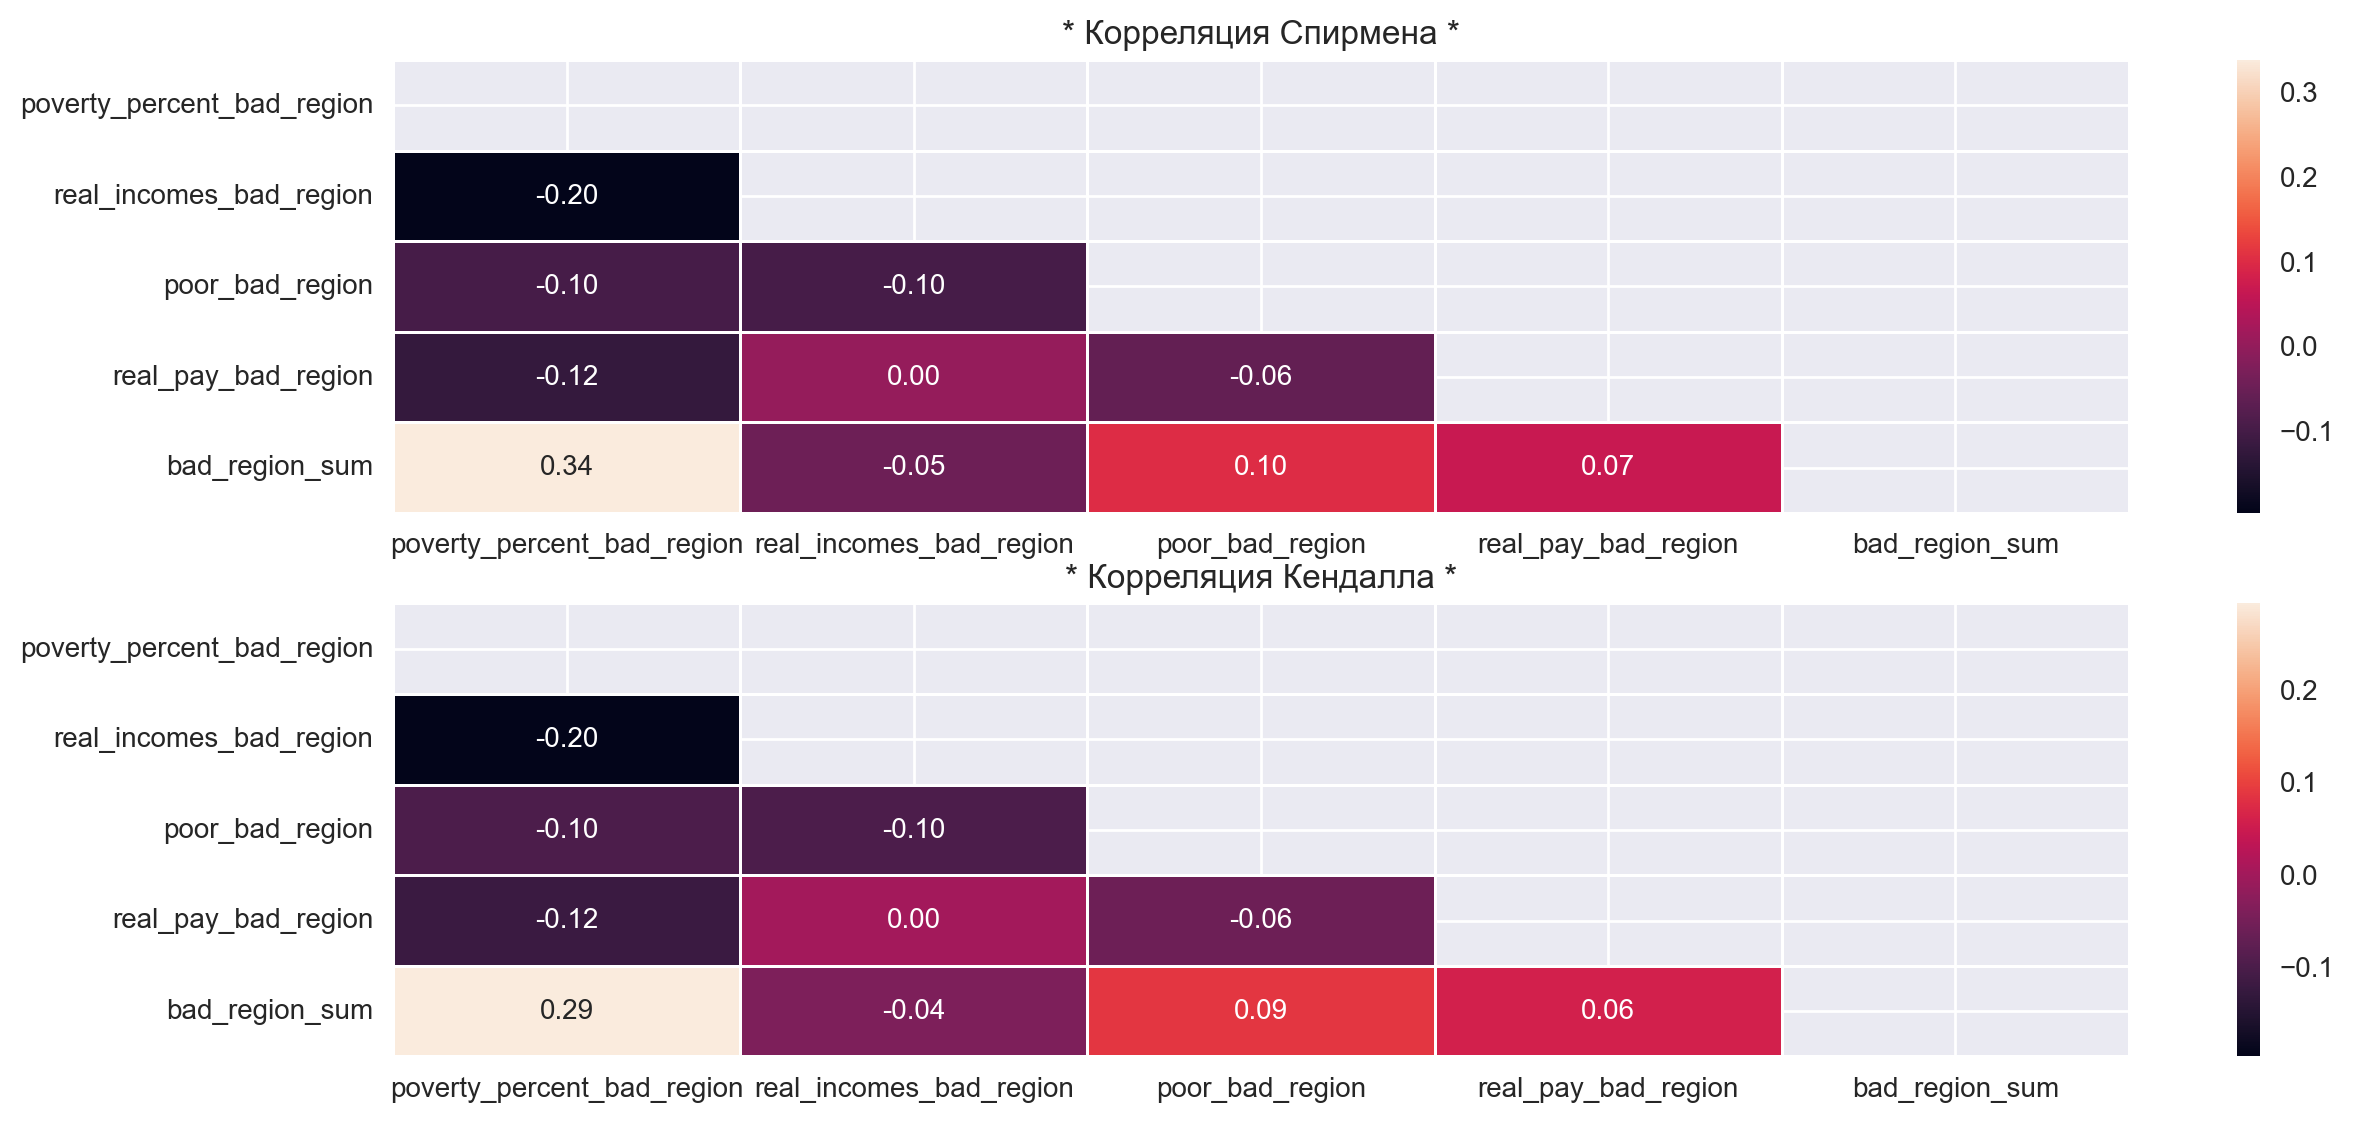

In [11]:
corr_visual(
    data=df_research[[
        'poverty_percent_trend', 'real_incomes_trend', 'poor_trend', 'real_pay_trend', 'bad_region_sum'
    ]], 
    width=12, height=10
    )
corr_visual(
    data=df_research[[
        'poverty_percent_bad_region', 'real_incomes_bad_region', 'poor_bad_region', 'real_pay_bad_region', 'bad_region_sum'
    ]], 
    width=14, height=10
    )

- Рассмотрим взаимосвязь **бинарных числовых признаков _bad_region** и признака **poverty_percent_bad_region** (корреляция Мэтьюса):

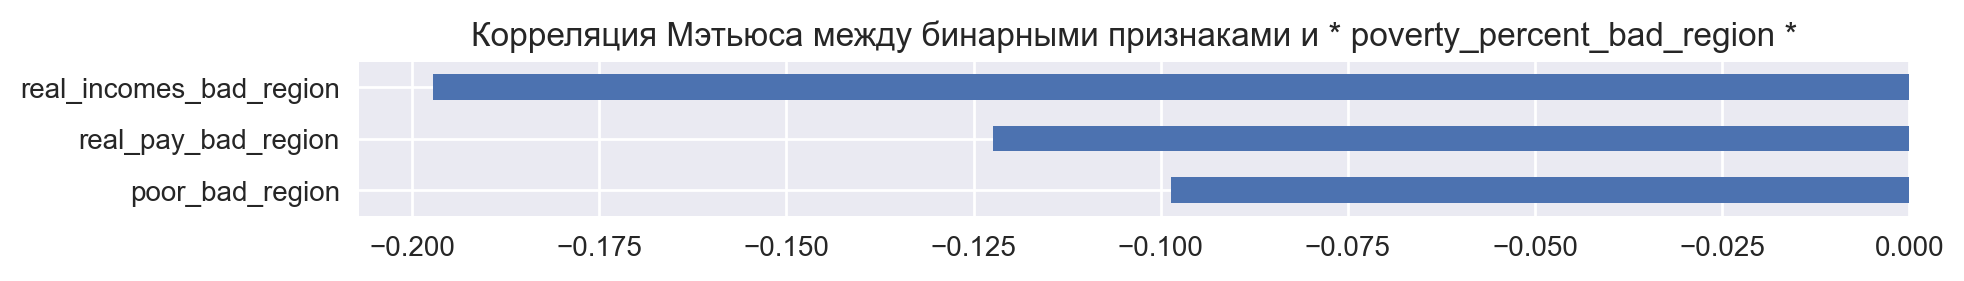

In [12]:
target_matthews_corrcoef(
    data=df_research, 
    binary_features=[
        'poverty_percent_bad_region', 'real_incomes_bad_region', 'poor_bad_region', 'real_pay_bad_region'
    ], 
    target='poverty_percent_bad_region', 
    width=10, height=1, top_number=10)

- выведем корреляцию признака **poverty_percent** и остальных признаков, **за исключением бинарных** (корреляция Спирмена и Кендалла):

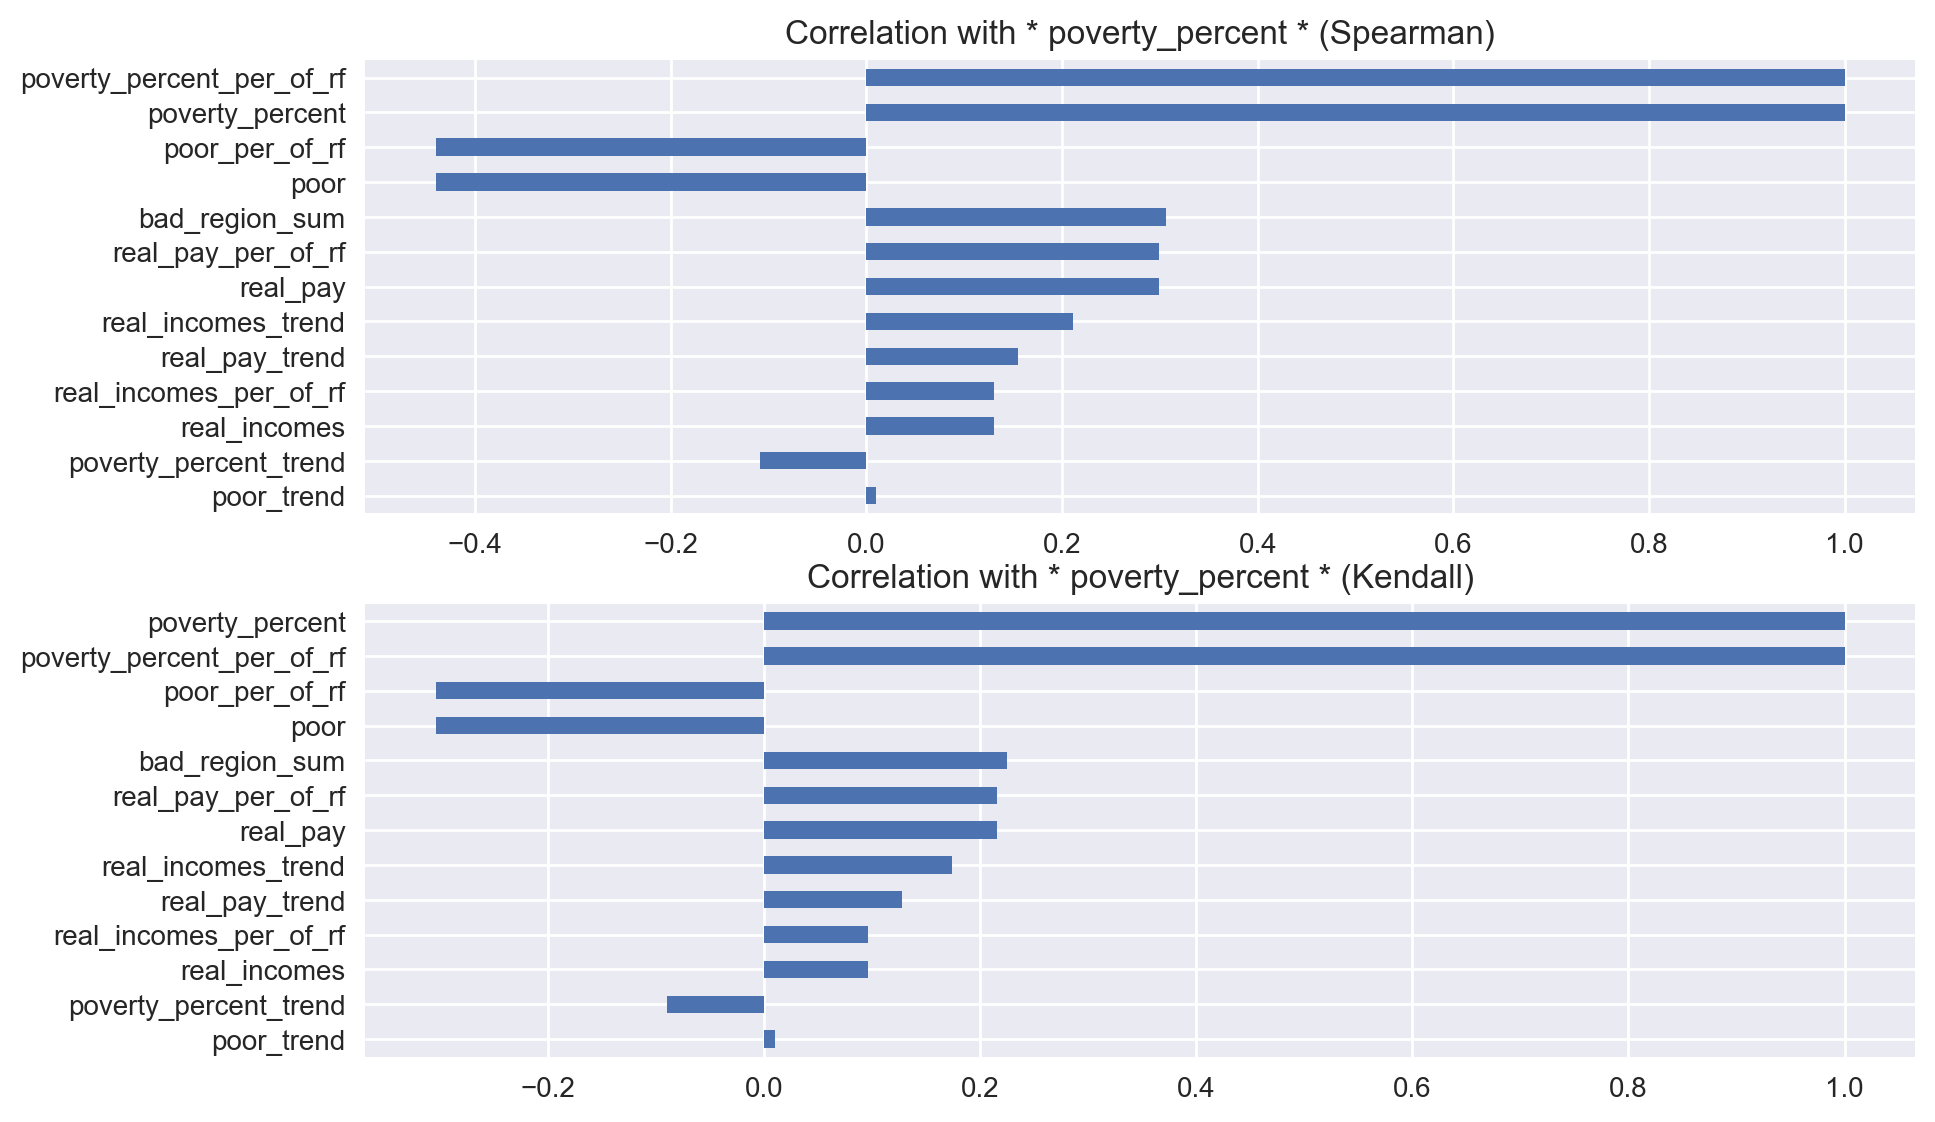

In [13]:
target_corr_visual(data=df_research.drop(
    ['poverty_percent_bad_region', 'real_incomes_bad_region', 'poor_bad_region', 'real_pay_bad_region'],
    axis=1), 
    target='poverty_percent', 
    width=10, height=10, top_number=20
)

- проведем тест Xi-квадрат на взаимосвязь признака **bad_region_sum** и других категориальных признаков:

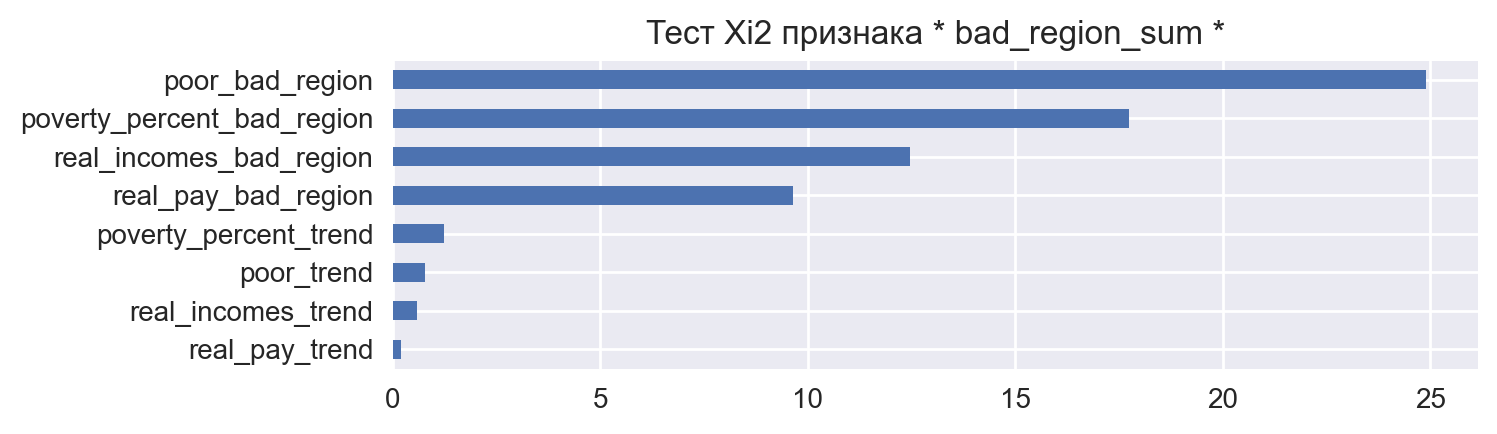

In [14]:
target_xi2_test(
    data=df_research[[
        'poverty_percent_bad_region', 'real_incomes_bad_region', 'poor_bad_region', 'real_pay_bad_region','bad_region_sum',
        'poverty_percent_trend', 'real_incomes_trend', 'poor_trend', 'real_pay_trend'
    ]].replace(-1,2), # заменим в признаках тренда -1 на 2
    target='bad_region_sum', 
    width=7, height=2)

**Выводы:**
- корреляция Спирмена показывает слабую кореляцию признаков **bad_region_sum** (категориальный признак) и **poverty_percent/poverty_percent_per_rf** (непрерывные числовые признаки) = 0.31. Судя по всему, признаки **poverty_percent/poverty_percent_per_rf** мультиколлинеарны (впрочем, как и другие пары признак-признак_отношение_к_данным_по_РФ).
- выявлена аномалия - слабая отрицательная кореляция признаков **poverty_percent/poverty_percent_per_rf** и **poor/poor_per_rf** =-0.44 и =-0.30 согласно корреляции Спирмена и Кендалла соответственно. Напомним, что признак **poverty_percent** - это *% людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)*, а признак **poor** - это *доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения*. И хотя признак **poor** нельзя считать новой методикой расчета населения ниже черты бедности (нет полного соответствия методологии), но банальная логика подсказывает, что эти признаки должны коррелировать положительно. Возможные причины аномалии:
    - я где-то "накосячил" на этапе сбора и предварительной обработки данных
    - методика расчета признаков сильно различается
    - какие-то из этих данных недостоверны     
Так как, найти ошибку у себя я не смог, а две оставшиеся возможные причины выходят за рамки моей компетенции, полагаю правильным не использовать признак **poor** и его производные для кластеризации.
- Согласно корреляциям Спирмена и Кендалла имеются положительные цифры корреляции признаков **poverty_percent/poverty_percent_per_rf**, **real_pay/real_pay_per_rf**, **real_incomes/real_incomes_per_rf**, причем связь признаков **poverty_percent/poverty_percent_per_rf** и **real_pay/real_pay_per_rf** можно считать даже слабой = 0.30 по корреляции Спирмена. 
- отмечается слабая положительная связь между категориальными признаками **poverty_percent_bad_region** и **bad_region_sum** согласно корреляциям Спирмена и Кедалла (0.34 и 0.29 соответственно). Вообще, цифры корреляции представленных в данном пункте признаков **_bad_region** и **bad_region_sum** перекликаются с тем, что мы видели в предыдущем пункте при анализе регионов-аутсайдеров.
- представленные бинарные признаки **_bad_region** показывают отсутствие связи/очень слабую связь, согласно корреляции Мэтьюса.
- согласно проведенному тесту Xi2, категориальные признаки тренда очень слабо связаны с признаком **bad_region_sum**. При этом, признак **poor_bad_region** демонстрирует более высокую связь, чем **poverty_percent_bad_region** 

***

### 3.4. Изучим непрерывные числовые признаки

Выведем топ-коррелирующих признаков. Есть предположение, что в парах **непрерывный_признак**-***_per_of_rf** корреляция будет =1.

In [15]:
get_top_abs_correlations(
    df=data[continuous_features],
    method='spearman', # используем корреляцию Спирмена
    top_number=33
)

Top Absolute Correlations


corr
drunk_serious_crimes      drunk_serious_crimes_per_of_rf       1.000000
real_incomes              real_incomes_per_of_rf               1.000000
poor                      poor_per_of_rf                       1.000000
child_mortality_100k      child_mortality_100k_per_of_rf       1.000000
disabled_100k             disabled_100k_per_of_rf              1.000000
alco                      alco_per_of_rf                       1.000000
drug                      drug_per_of_rf                       1.000000
grp                       grp_per_of_rf                        1.000000
constraint                constraint_per_of_rf                 1.000000
living_area               living_area_per_of_rf                1.000000
very_bad_living_area      very_bad_living_area_per_of_rf       1.000000
congenital_malformation   congenital_malformation_per_of_rf    1.000000
psychosis                 psychosis_per_of_rf                  1.000000
teenage_pregnancy         teenage_pregnancy_per_of_rf          1.000000
conditions_in_perinatal   conditions_in_perinatal_per_of_rf    1.000000
newborn_100k              newborn_100k_per_of_rf               1.000000
poverty_percent           poverty_percent_per_of_rf            1.000000
poverty_socdem_children   poverty_socdem_children_per_of_rf    1.000000
poverty_socdem_retired    poverty_socdem_retired_per_of_rf     1.000000
poverty_socdem_employable poverty_socdem_employable_per_of_rf  1.000000
retail                    retail_per_of_rf                     1.000000
welfare_expense           welfare_expense_per_of_rf            1.000000
children_serious_crimes   children_serious_crimes_per_of_rf    1.000000
repeat_serious_crimes     repeat_serious_crimes_per_of_rf      1.000000
real_pay                  real_pay_per_of_rf                   1.000000
general_morbidity         general_morbidity_per_of_rf          0.999990
population                population_per_of_rf                 0.999917
industrial_production     industrial_production_per_of_rf      0.999907
water_supply              water_supply_per_of_rf               0.999902
electricity               electricity_per_of_rf                0.999873
manufacturing             manufacturing_per_of_rf              0.999805
mining                    mining_per_of_rf                     0.996089
manufacturing             industrial_production                0.893825

Так и есть. Удалим из непрерывных признаков признаки ***_per_of_rf**:

In [16]:
for feature in continuous_features:
    if '_per_of_rf' in feature:
        continuous_features.remove(feature)

Теперь снова выведем топ-коррелирующих признаков:

In [17]:
get_top_abs_correlations(
    df=data[continuous_features],
    method='spearman',
    top_number=60
)

Top Absolute Correlations


corr
manufacturing           industrial_production      0.893825
newborn_100k            population_children        0.876439
electricity             industrial_production      0.859038
population_children     population_retired        -0.853443
newborn_100k            population_retired        -0.842653
population              electricity                0.813035
poverty_socdem_children poverty_socdem_employable -0.802997
manufacturing           electricity                0.796443
population              manufacturing              0.789212
manufacturing           water_supply               0.786402
water_supply            industrial_production      0.778683
electricity             water_supply               0.757449
population              water_supply               0.750404
                        industrial_production      0.728298
poverty_percent         retail                    -0.717697
grp                     retail                     0.696072
                        mining                     0.676529
population_employable   population_retired        -0.658089
poor                    retail                     0.652405
grp                     industrial_production      0.651280
poverty_percent         industrial_production     -0.610382
grp                     poverty_percent           -0.599250
poverty_percent         manufacturing             -0.594814
mining                  industrial_production      0.590385
poverty_percent         welfare_expense            0.578241
child_mortality_100k    population_children        0.576361
                        population_retired        -0.575889
disabled_100k           grp                       -0.575555
industrial_production   retail                     0.568263
child_mortality_100k    newborn_100k               0.565000
grp                     drunk_serious_crimes       0.560272
mining                  electricity                0.544010
living_area             drunk_serious_crimes      -0.542994
repeat_serious_crimes   drunk_serious_crimes       0.542030
grp                     welfare_expense           -0.526450
general_morbidity       congenital_malformation    0.521133
                        psychosis                  0.489537
retail                  welfare_expense           -0.489431
manufacturing           retail                     0.483584
alco                    psychosis                  0.480156
electricity             retail                     0.478659
grp                     electricity                0.478034
disabled_100k           poverty_percent            0.476164
poor                    grp                        0.470267
poverty_percent         water_supply              -0.457547
grp                     manufacturing              0.447372
poor                    poverty_percent           -0.440593
population              alco                      -0.439063
disabled_100k           industrial_production     -0.439048
constraint              living_area               -0.434668
retail                  drunk_serious_crimes       0.430631
disabled_100k           drunk_serious_crimes      -0.423505
very_bad_living_area    population_retired        -0.422198
industrial_production   drunk_serious_crimes       0.421944
poverty_percent         electricity               -0.420935
living_area             repeat_serious_crimes     -0.418533
disabled_100k           retail                    -0.418411
congenital_malformation psychosis                  0.417772
manufacturing           population_children       -0.417023
poor                    industrial_production      0.412252

В топе у нас связь промышленного производства и обрабатывающего производства, число новорожденных на 100k и доля детского населения (это логично), обеспечение электроэнергией (+ газом, паром и пр.) и пром. производство, что также логично. Есть и неочевидные взаимосвязи (по крайней мере, для меня): средняя связь между валовым региональным продуктом и оборотом розничной торговли на душу населения. И снова аномалия  - прямая средняя связь признака **poor** и оборотом розничной торговли **retail**. Все-таки, склоняюсь к тому, что данные взятые для признака **poor** недостоверны. Далее не будем уже останавливаться на данной аномалии.

Визуализируем корреляционные связи ключевого признака **poverty_percent** и других непрерывных признаков:

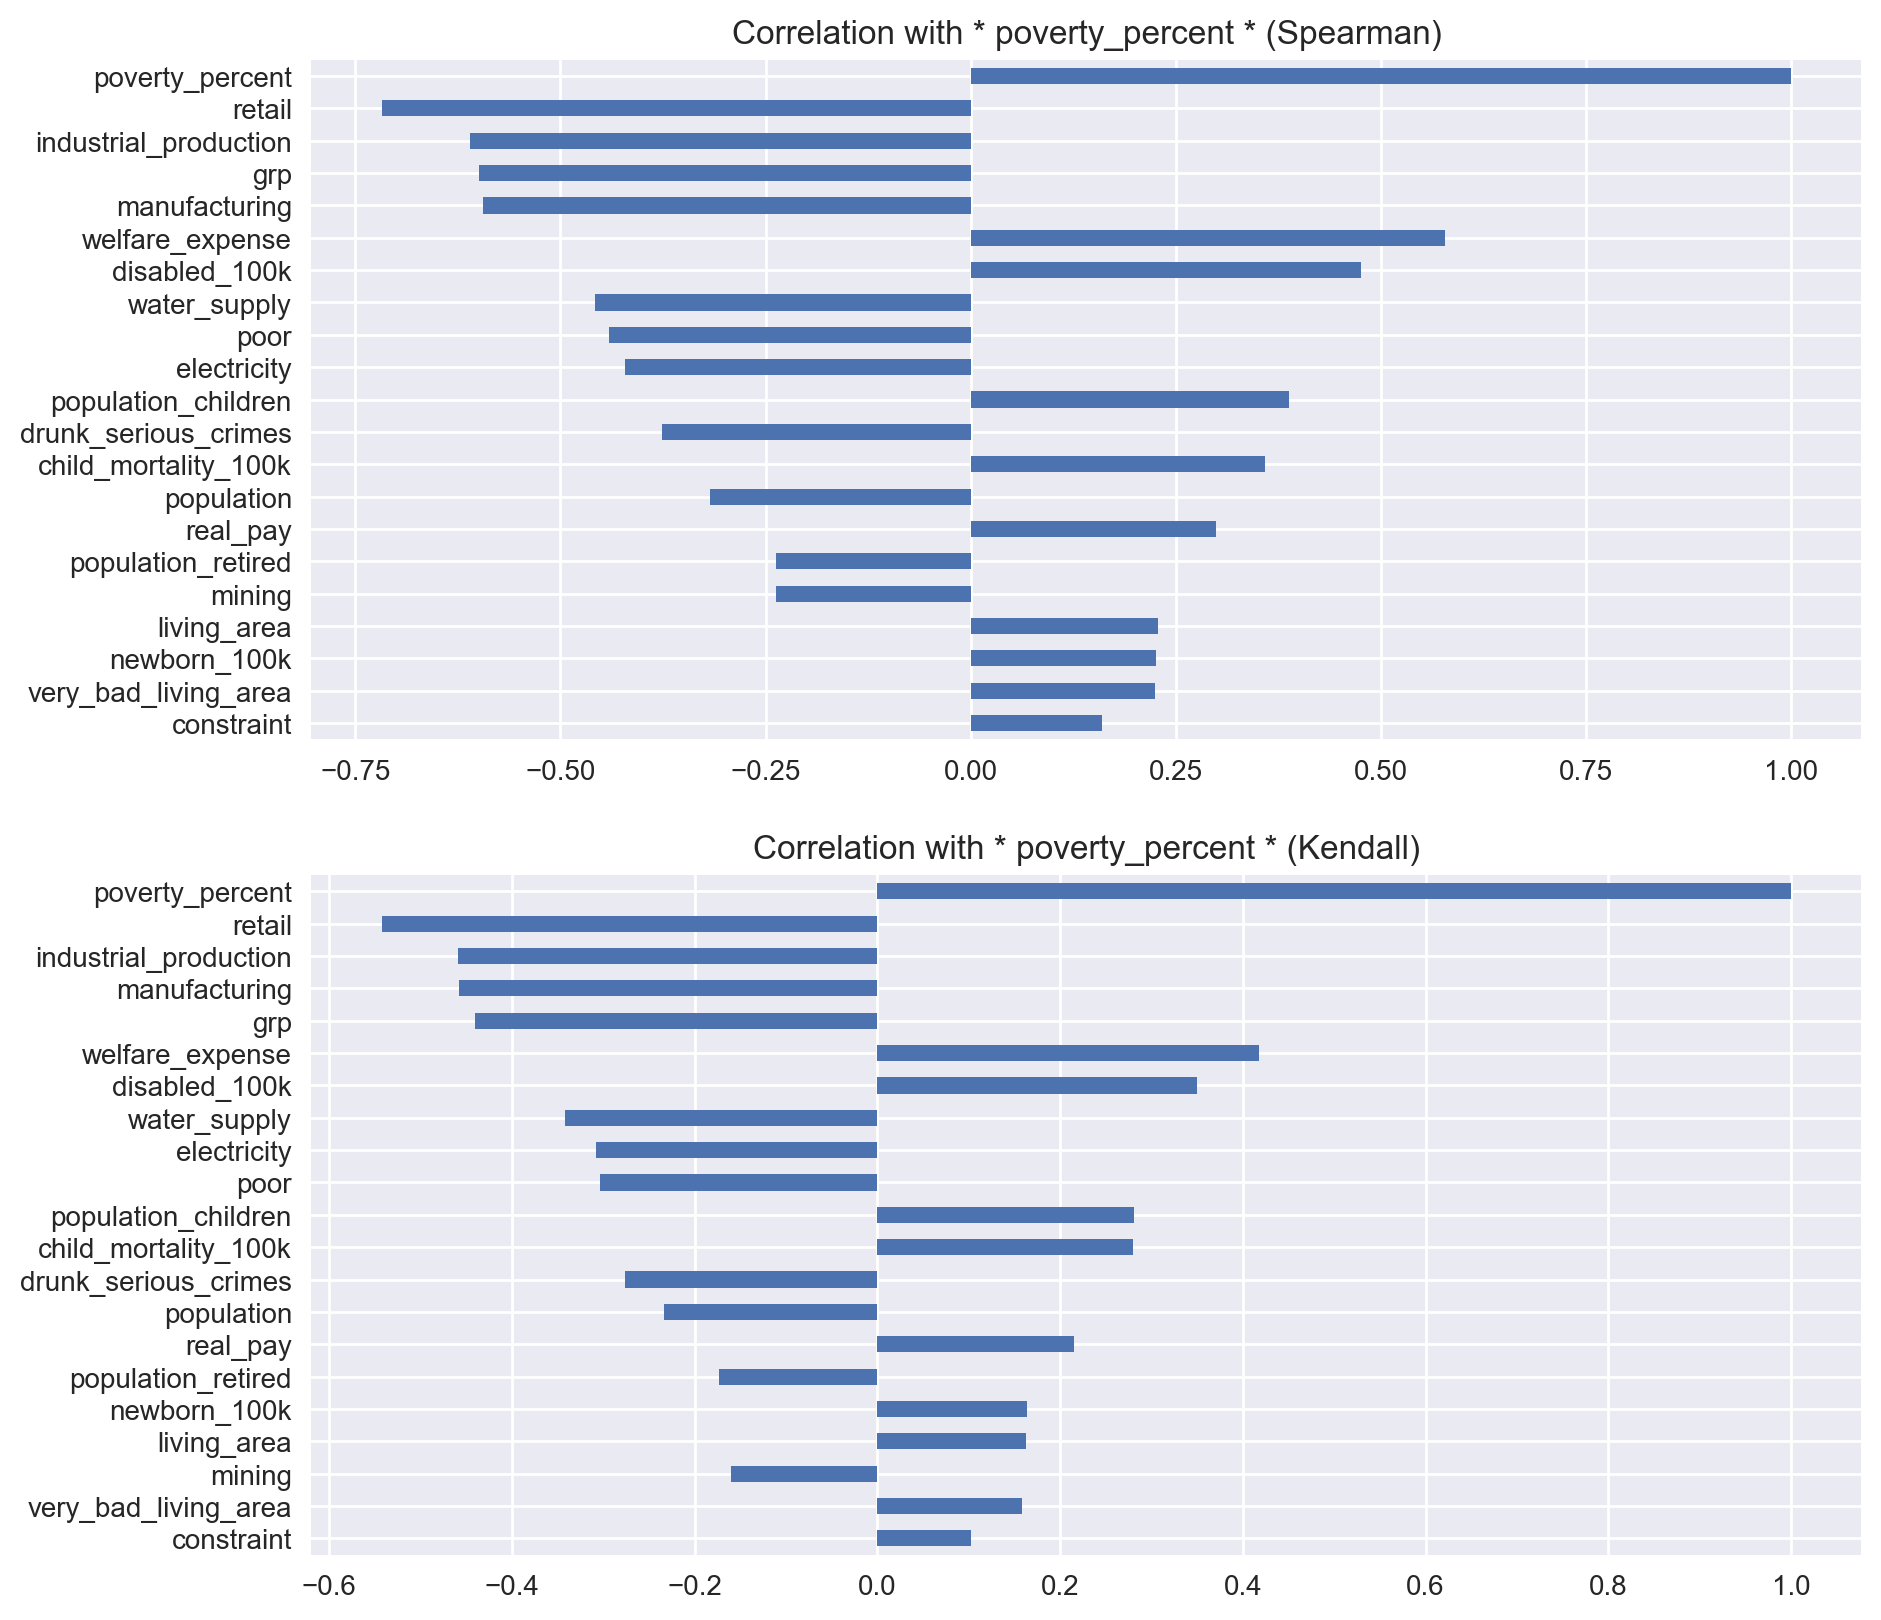

In [18]:
target_corr_visual(data=data[continuous_features],
    target='poverty_percent', 
    width=10, height=15, top_number=20
)

**Выводы:**
- Мы видим отрицальную среднюю/слабую взаимосвязь признака **poverty_percent** и признаков **retail**(оборот розничной торговли),**industrial_prodution**(пром. производство),**manufacturing**(обрабатывающее производство) и **grp**(валовой региональный продукт на душу населения), **water_supply** (водоснабжение и пр.) и **electricity** (обеспечение электроэнергией и пр.). То что связь отрицательная - это вполне логично.
- Также мы видим среднюю/слабую положительную связь ключевого признака с признаками **welfare_expense** (расходы на соц. политику) и **disabled_100k** (число инвалидов трудоспособного возраста).
- Положительная связь ключевого признака с признаком **welfare_expense** мне непонятна (аномалия?).
- Данные экономические показатели наиболее сильно влияют на % людей за чертой бедности в регионе.

***

### 3.5. Изучим категориальные признаки

In [19]:
# выведем топ коррелирующих признаков
get_top_abs_correlations(
    df=data[categorial_features],
    method='kendall', # используем корреляцию Кендалла
    top_number=60
)

Top Absolute Correlations


corr
population_trend                   population_bad_region                -1.000000
manufacturing_trend                manufacturing_bad_region             -1.000000
mining_trend                       mining_bad_region                    -1.000000
electricity_trend                  electricity_bad_region               -0.835598
industrial_production_trend        industrial_production_bad_region     -0.809858
water_supply_trend                 water_supply_bad_region              -0.788811
poverty_socdem_retired_trend       poverty_socdem_retired_bad_region     0.770821
child_mortality_100k_trend         mining_bad_region                     0.702885
                                   mining_trend                         -0.702885
real_pay_trend                     real_pay_bad_region                  -0.694051
poverty_socdem_children_trend      poverty_socdem_employable_trend      -0.659752
poverty_socdem_employable_trend    poverty_socdem_employable_bad_region  0.638621
poverty_socdem_children_trend      poverty_socdem_children_bad_region    0.635174
disabled_100k_bad_region           retail_bad_region                     0.589455
repeat_serious_crimes_bad_region   drunk_serious_crimes_bad_region       0.586018
real_incomes_trend                 real_incomes_bad_region              -0.572435
teenage_pregnancy_trend            teenage_pregnancy_bad_region          0.552913
conditions_in_perinatal_trend      conditions_in_perinatal_bad_region    0.543931
poor_trend                         poor_bad_region                       0.543858
congenital_malformation_trend      congenital_malformation_bad_region    0.538290
living_area_bad_region             repeat_serious_crimes_bad_region      0.526972
general_morbidity_trend            general_morbidity_bad_region          0.505504
psychosis_trend                    industrial_production_bad_region      0.502283
poverty_percent_bad_region         retail_bad_region                     0.500441
manufacturing_bad_region           retail_bad_region                     0.490990
manufacturing_trend                retail_bad_region                    -0.490990
alco_bad_region                    bad_region_sum                        0.486068
conditions_in_perinatal_trend      mining_trend                         -0.481589
                                   mining_bad_region                     0.481589
poverty_socdem_children_bad_region poverty_socdem_employable_trend      -0.478721
industrial_production_bad_region   retail_bad_region                     0.465204
child_mortality_100k_bad_region    poverty_percent_bad_region            0.460055
population_trend                   welfare_expense_bad_region            0.451848
population_bad_region              welfare_expense_bad_region           -0.451848
grp_bad_region                     poverty_percent_bad_region            0.446950
general_morbidity_bad_region       congenital_malformation_bad_region    0.428016
child_mortality_100k_bad_region    poverty_percent_trend                 0.422629
repeat_serious_crimes_trend        drunk_serious_crimes_trend            0.408421
disabled_100k_bad_region           grp_bad_region                        0.403388
alco_bad_region                    constraint_bad_region                 0.397633
disabled_100k_bad_region           manufacturing_trend                  -0.395912
child_mortality_100k_trend         disabled_100k_bad_region              0.395912
psychosis_trend                    manufacturing_bad_region              0.395912
                                   manufacturing_trend                  -0.395912
disabled_100k_bad_region           manufacturing_bad_region              0.395912
psychosis_trend                    industrial_production_trend          -0.393346
constraint_bad_region              bad_region_sum                        0.392526
poverty_socdem_children_trend      poverty_socdem_employable_bad_region -0.392310
psychosis_bad_region               bad_region_sum          

**Выводы:**
- Мы видим, что очень часто тренд признака очень сильно коррелирует с плохим регионом того же признака (например, **population_trend** и **population_bad_region**), что вполне логично, так как на прошлом этапе мы часто выделяли регионы как ПЛОХИЕ именно по трнеду или в т.ч. по тренду.
- Из неочевидных сильных взаимосвязей бросается в глаза, например, высокая положительная связь признаков **child_mortality_100k_trend** и **mining_bad_region**, так же как и такая же по значению, но отрицательня связь между признаками **child_mortality_100k_trend** и **mining_trend** (лично мне непонятно, как так сильно может коррелировать тренд детской смертности на 100k и плохой регион/тренд по добыче полезных ископаемых).
- Интересная отрицательная средняя связь между трендом доли детей среди малоимущих и трендом доли трудоспособных среди малоимущих. 
- Также интересная средняя положительная связь между плохими регионами по повторным преступлениям и преступлениям в состоянии опьянения. 
- Также по представленным корреляционным данным мы видим, что наибольший вклад в признак **bad_region_sum** вносят ПЛОХИЕ регионы по алкоголизму (из всех признаков плохих регионов).

Пришло время изучить корреляцию производного ключевого признака **poverty_percent_bad_region** и других категориальных признаков:

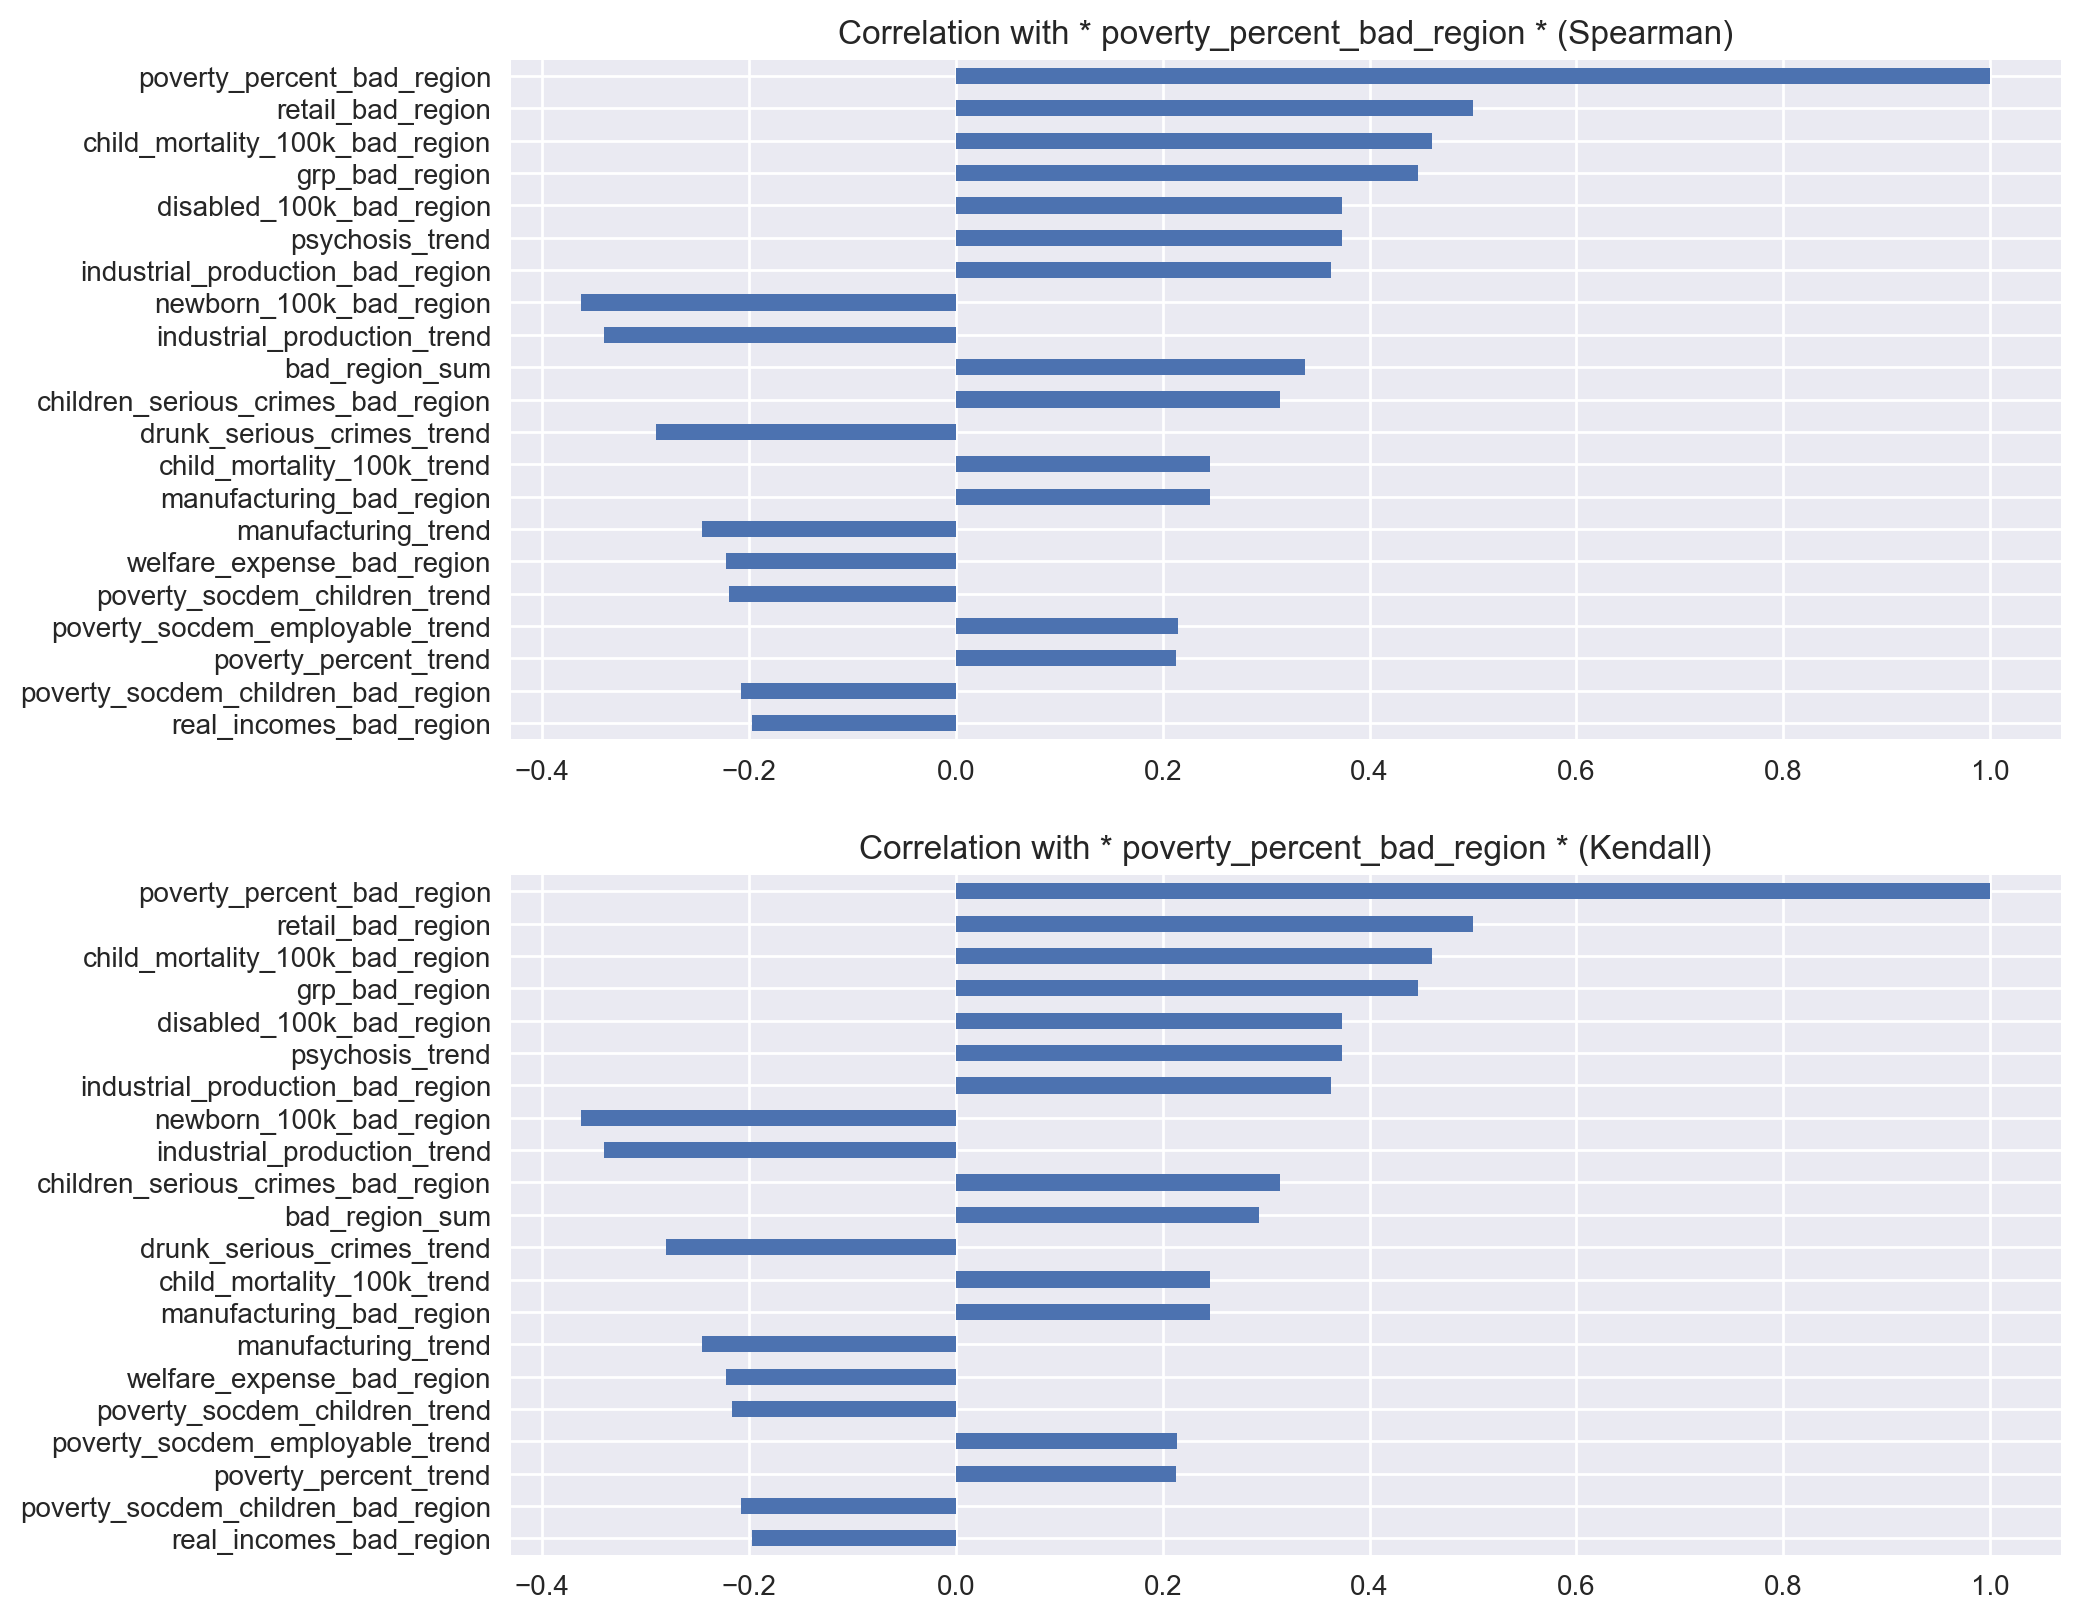

In [20]:
target_corr_visual(data=data[categorial_features],
    target='poverty_percent_bad_region', 
    width=10, height=15, top_number=20
)

**Выводы:**
Мы видим, что ПЛОХИЕ регионы по % населения ниже черты бедности положительно коррелируют (средняя и слабая связь) с плохими регионами по обороту розничной торговли, детской смертности на 100k, валовому региональному продукту на душу населения, количество инвалидов трудоспособного возраста и (что очень интересно!) по тренду психических расстройств и расстройств поведения.

Еще проверим взаимосвязи производного ключевого признака **poverty_percent_bad_region** и других категориальных признаков, но теперь используем тест Xi2:

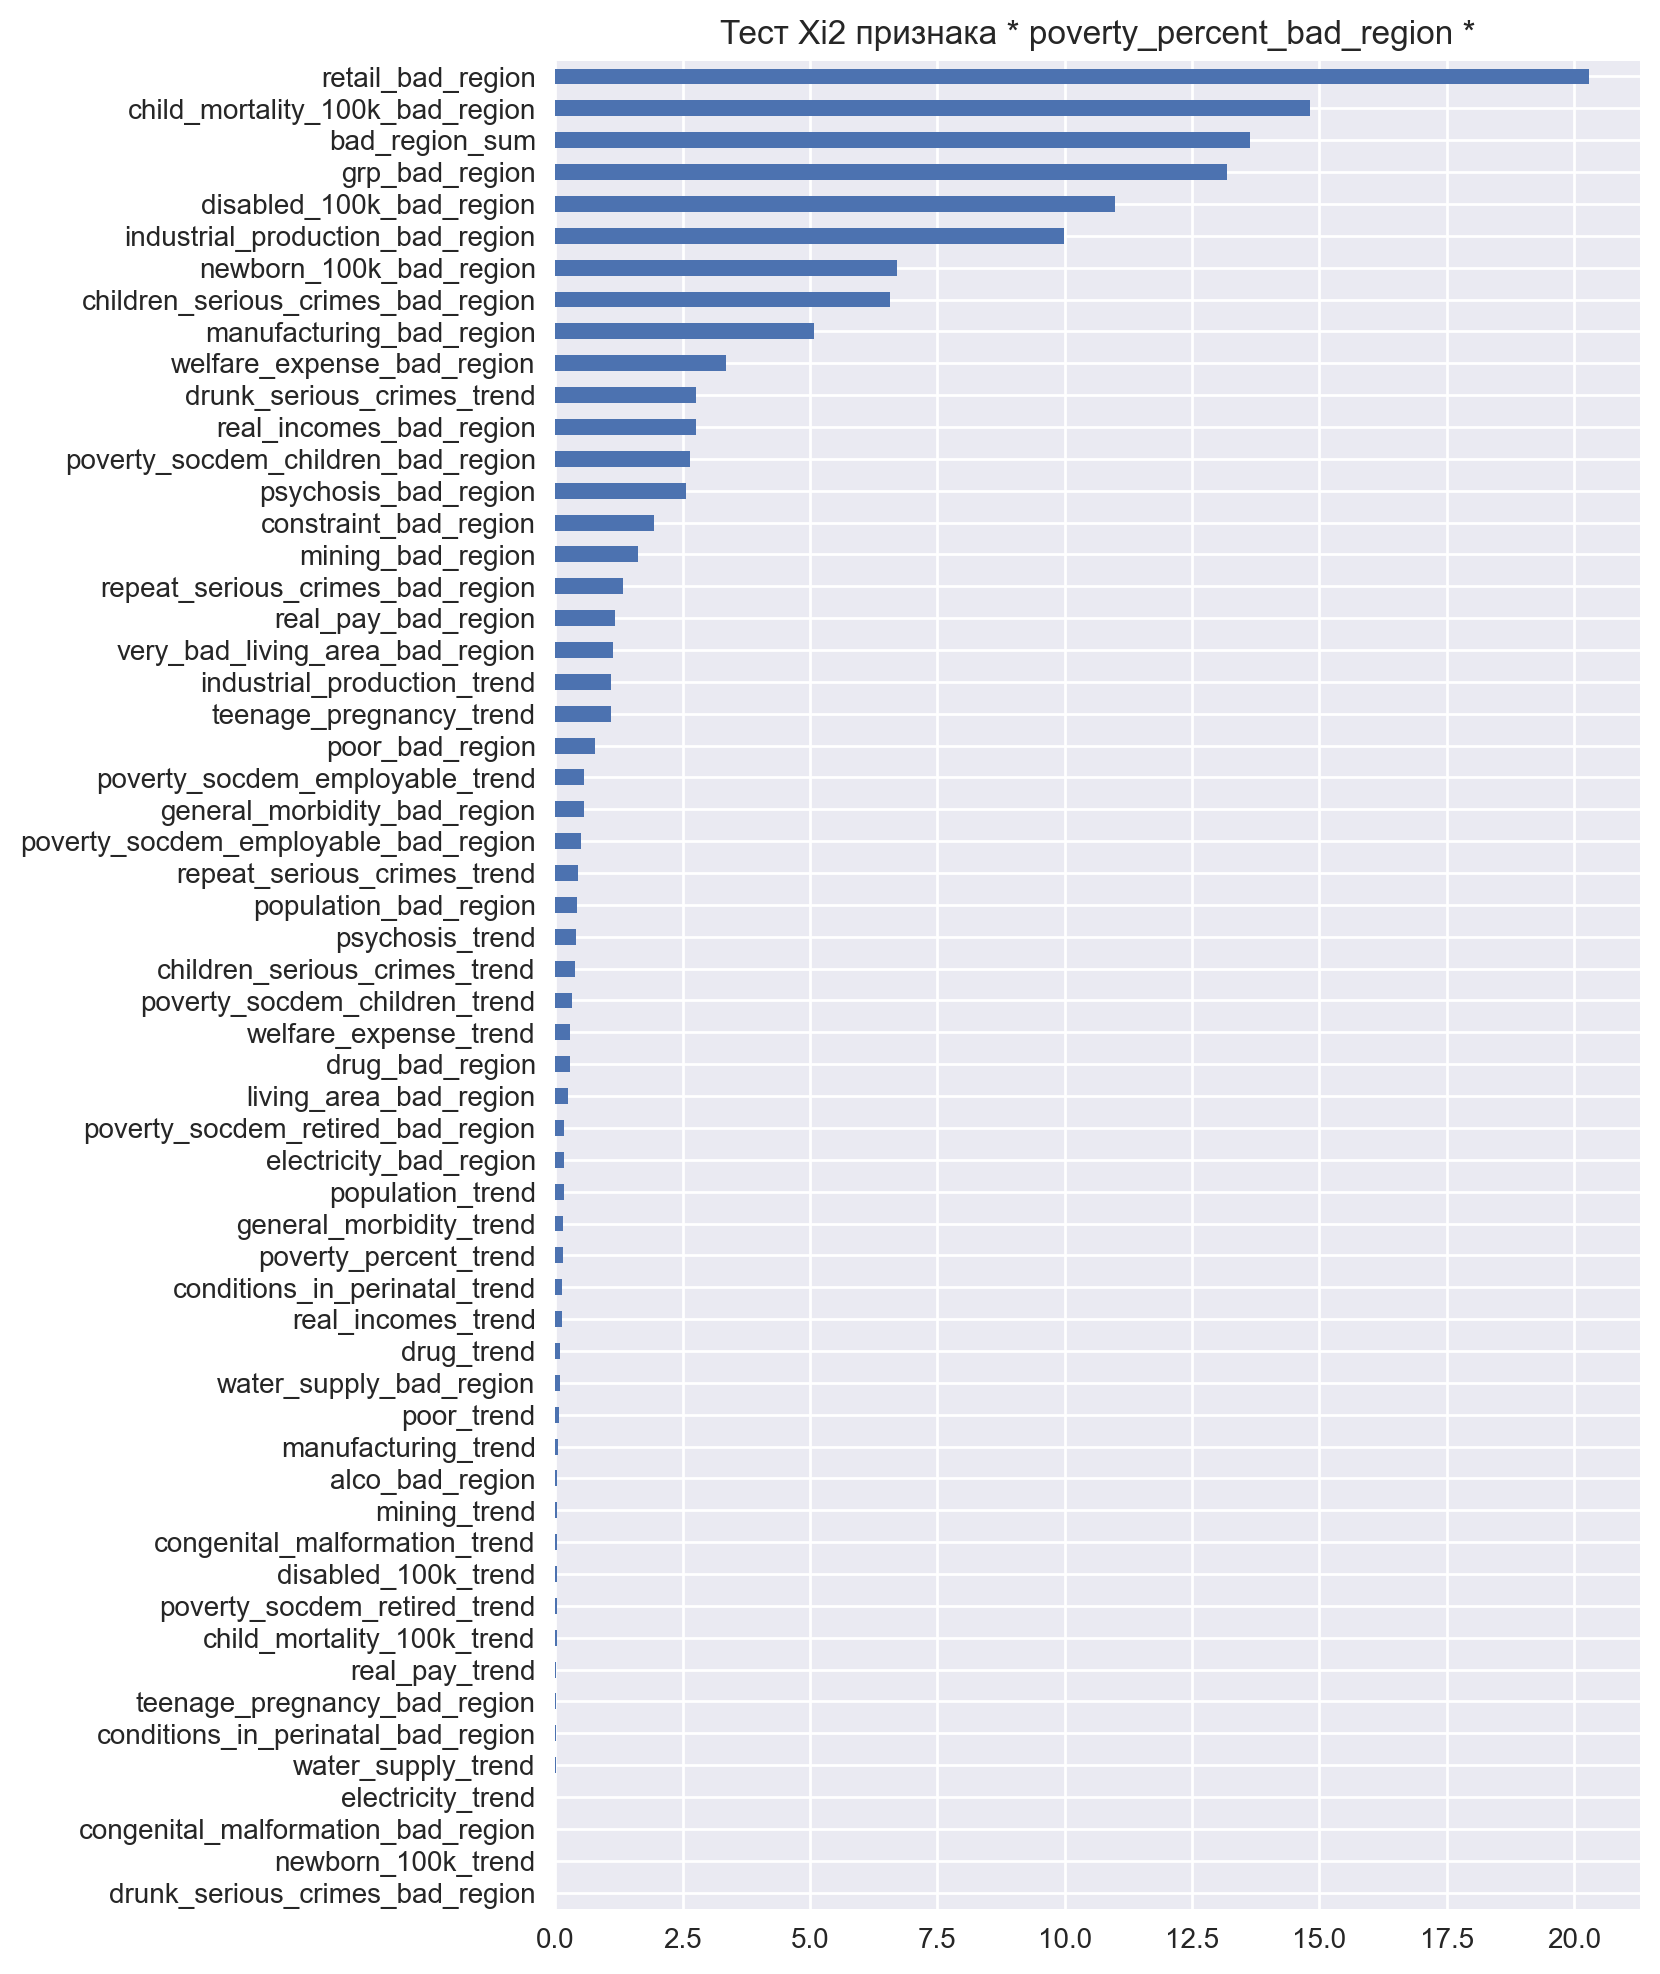

In [21]:
target_xi2_test(
    data=data[categorial_features].replace(-1,2), # заменим в признаках тренда -1 на 2
    target='poverty_percent_bad_region', 
    width=7, height=12)

**Выводы:**     
Результаты перекликаются с результатами корреляций выше, но есть пара интересных моментов:
- на 3-м месте в топе мы видим признак **bad_region_sum**
- на 8-м месте в топе - ПЛОХОЙ регион по тяжким и особо тяжким преступлениям среди детей

***

### 3.6. Отдельно изучим бинарные признаки

Изучим взаимосвязь производного ключевого признака **poverty_percent_bad_region** и других бинарных признаков:

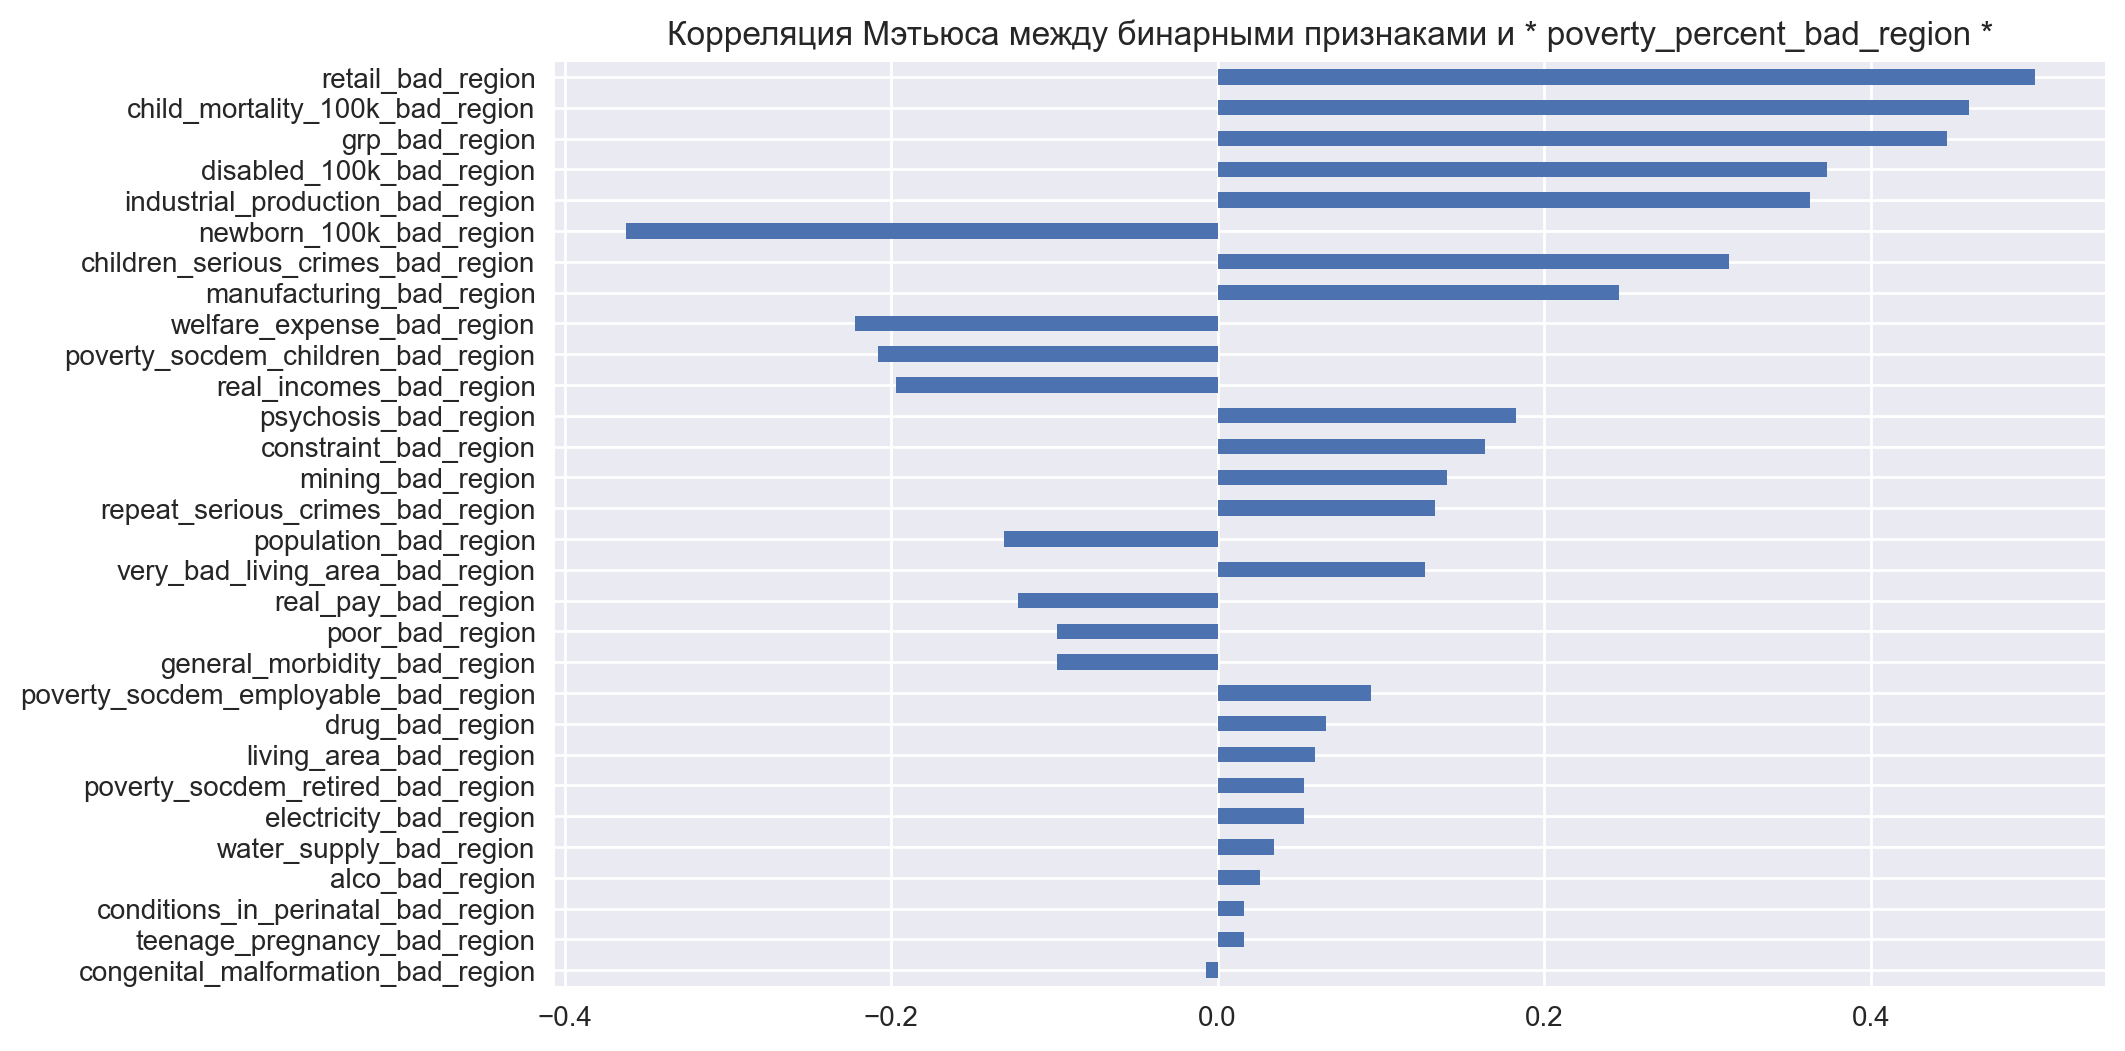

In [22]:
target_matthews_corrcoef(
    data=data, 
    binary_features=binary_features, 
    target='poverty_percent_bad_region', 
    width=10, height=6, top_number=30)

**Выводы:**
- Мы видим положительную среднюю/слабую корреляцию признака ПЛОХОГО региона по % людей за чертой бедности с признаками ПЛОХИХ регионов по обороту розничной торговли, детской смертности, валовому региональному продукту на душу населения, количеству инвалидов среди трудоспособного населения, промышленному производству, тяжким и особо тяжким преступлениям среди несовершеннолетних.     
- Имеется средняя степень отрицательной корреляции с признаком ПЛОХОГО региона по числу новорожденных, почему?. Возможно, это можно объяснить тем, что низкая рождаемость ведет к увеличению дохода на человека и наоборот, с появлением детей доходы на человека падают, поэтому регионы ПЛОХИЕ по рождаемости выглядят лучше по количеству людей ниже черты бедности.

**Примечание:** более подробно ключевой признак и его производные мы рассмотрим ниже.


***

### 3.7. Группы населения, сталкивающиеся с бедностью. Влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе

Оценим связь % людей за чертой бедности в регионе (признак **poverty_percent**) и долей различных групп населения:

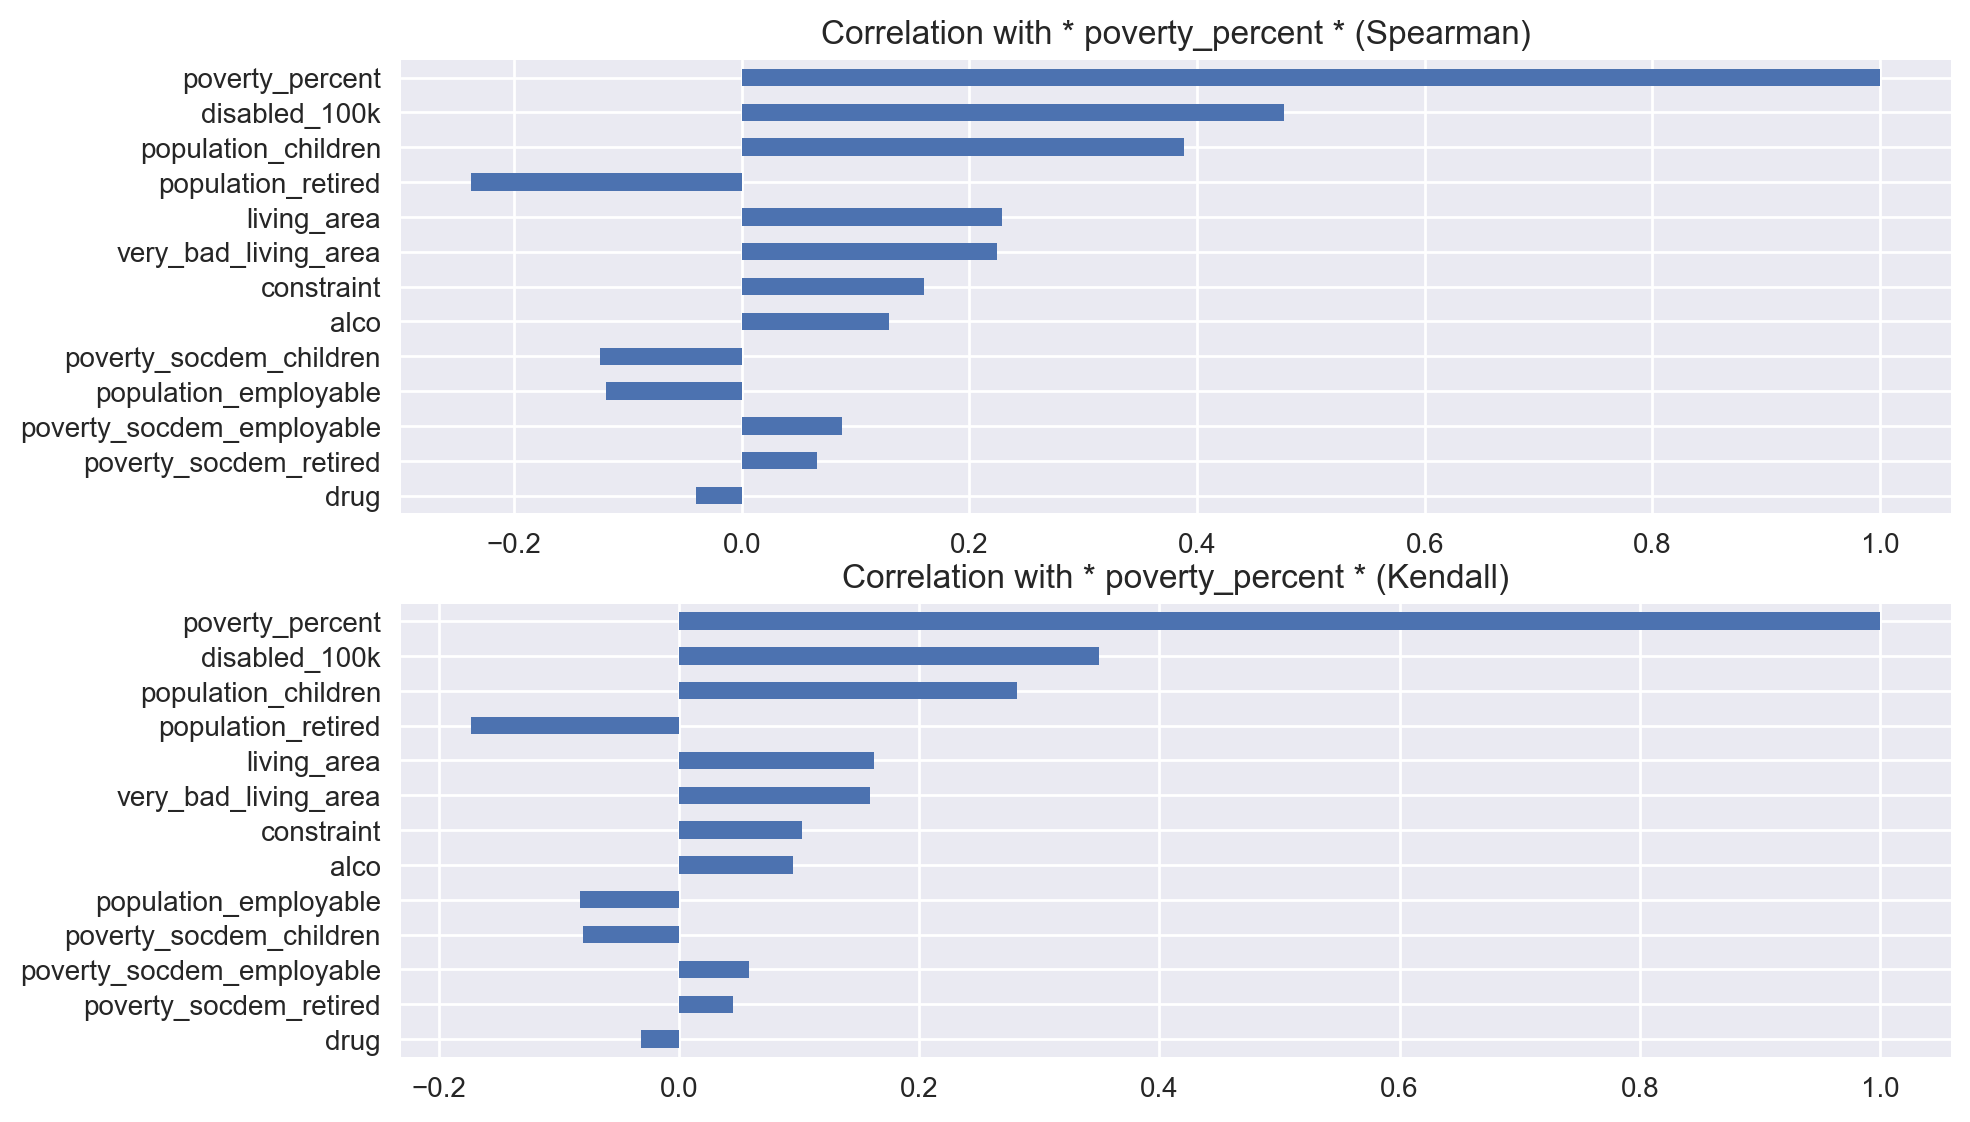

In [23]:
target_corr_visual(
    data=data[[
        'poverty_socdem_children','poverty_socdem_retired','poverty_socdem_employable',
        'population_children','population_employable','population_retired',
        'disabled_100k', 'alco', 'drug',
        'constraint','living_area','very_bad_living_area',
        'poverty_percent'
    ]],
    target='poverty_percent', 
    width=10, height=10, top_number=20
)

Оценим связь ПЛОХИХ регионов по показателю % людей за чертой бедности в регионе (признак **poverty_percent_bad_region**) и ПЛОХИХ регионов по показателям различных групп населения:

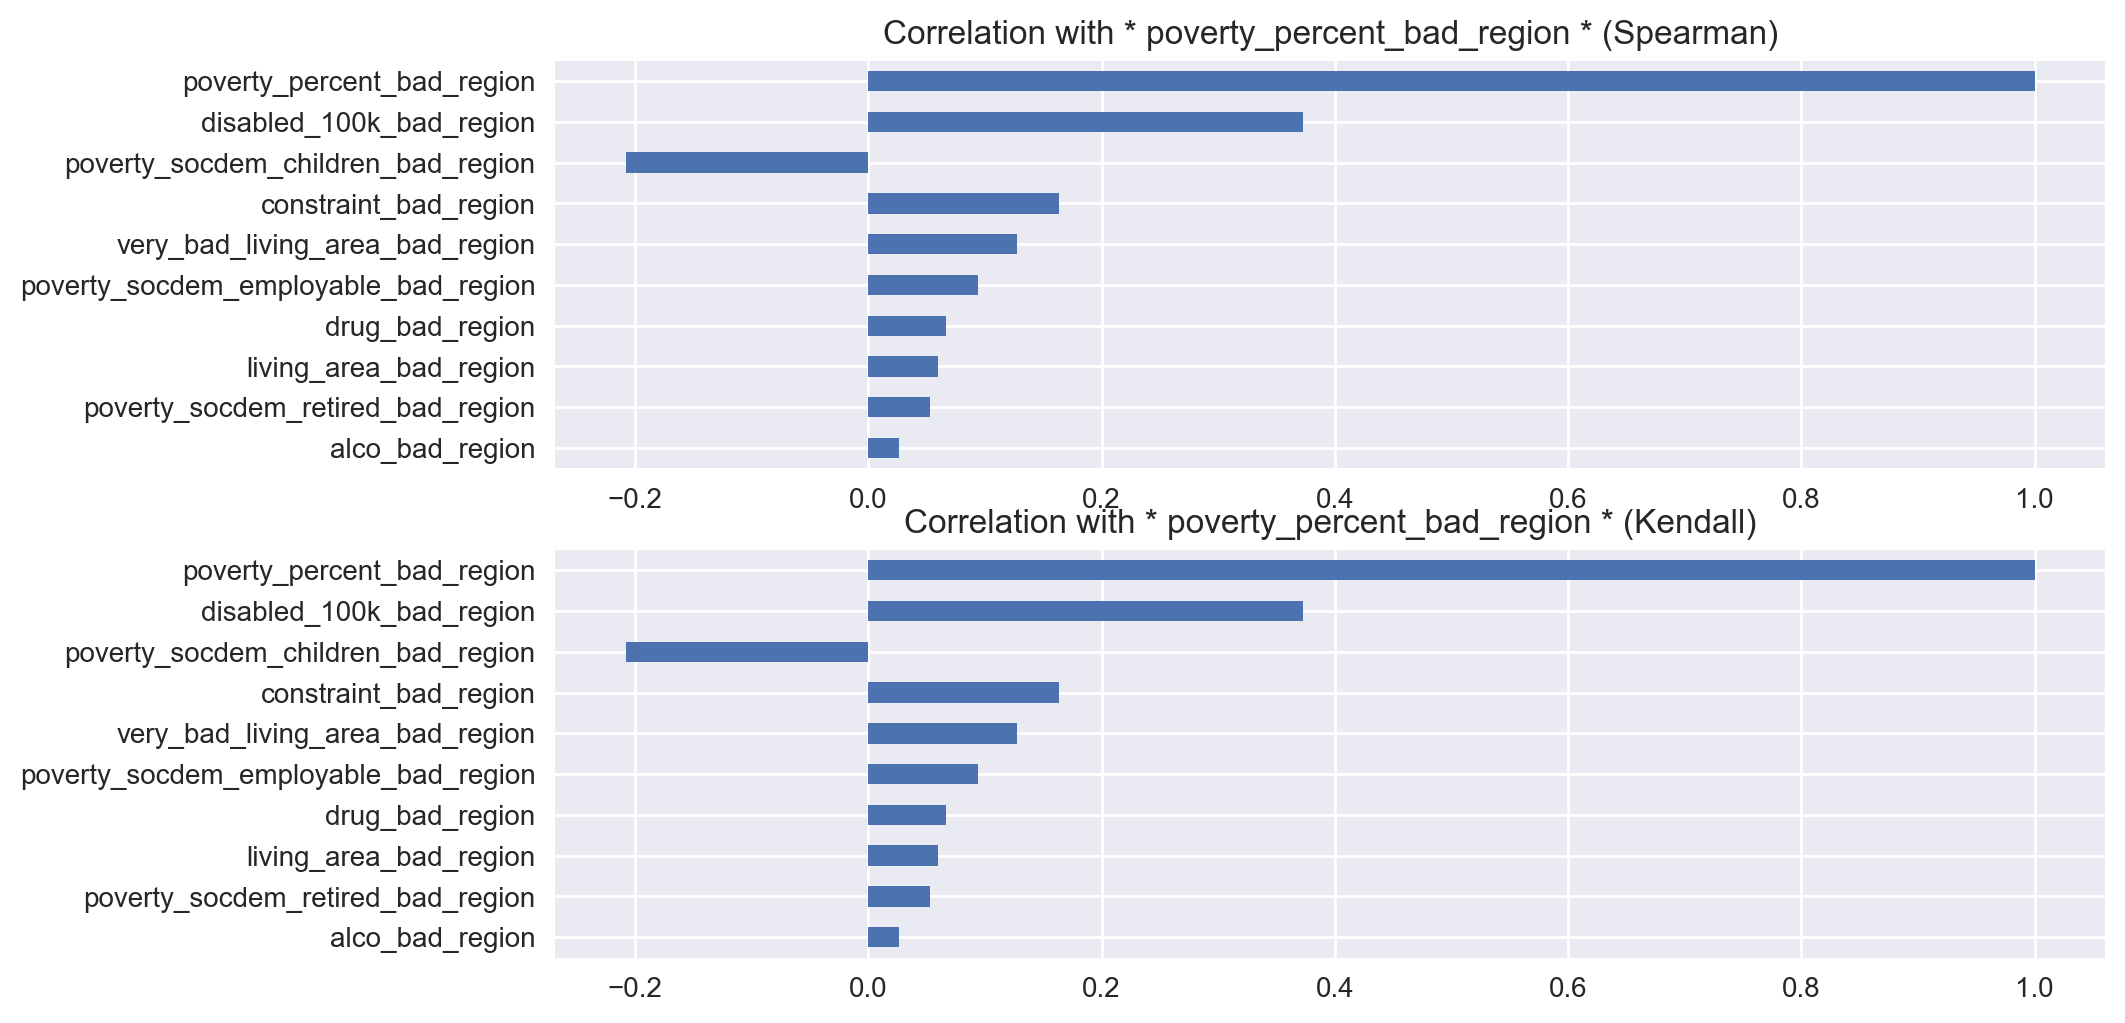

In [24]:
target_corr_visual(
    data=data[[
        'poverty_socdem_children_bad_region','poverty_socdem_retired_bad_region','poverty_socdem_employable_bad_region',
        #'population_children','population_employable','population_retired',
        'disabled_100k_bad_region', 'alco_bad_region', 'drug_bad_region',
        'constraint_bad_region','living_area_bad_region','very_bad_living_area_bad_region',
        'poverty_percent_bad_region'
    ]],
    target='poverty_percent_bad_region', 
    width=10, height=9, top_number=20
)

Оценим то же, но с помощью теста Xi-квадрат:

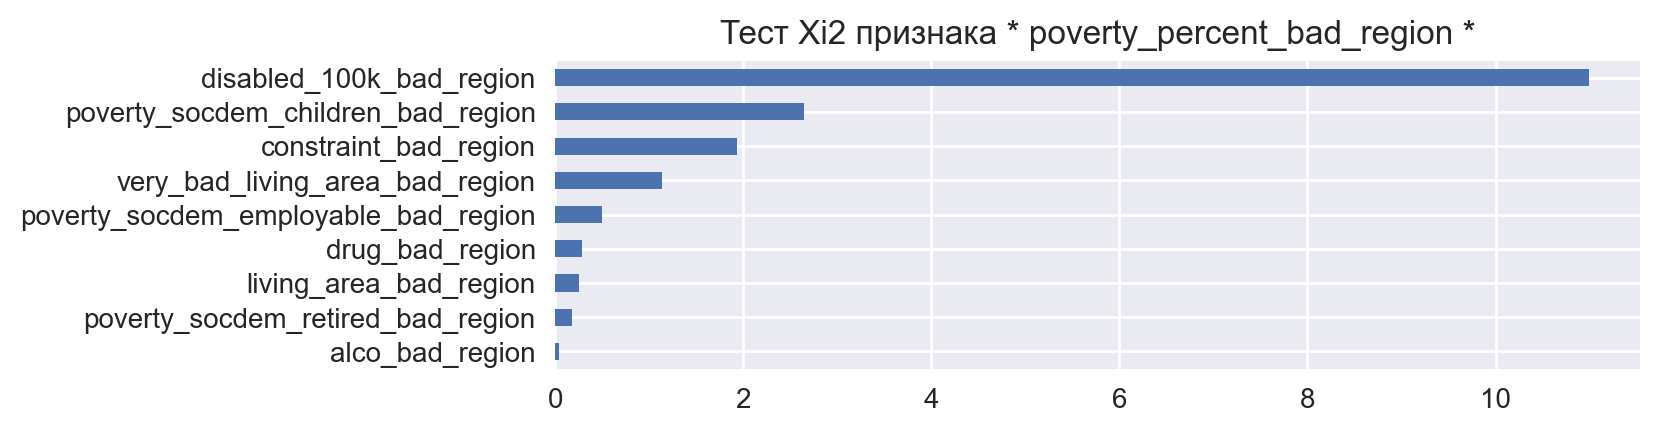

In [25]:
target_xi2_test(
    data=data[[
        'poverty_socdem_children_bad_region','poverty_socdem_retired_bad_region','poverty_socdem_employable_bad_region',
        #'population_children','population_employable','population_retired',
        'disabled_100k_bad_region', 'alco_bad_region', 'drug_bad_region',
        'constraint_bad_region','living_area_bad_region','very_bad_living_area_bad_region',
        'poverty_percent_bad_region'
    ]],
    target='poverty_percent_bad_region', 
    width=7, height=2)

Оценим то же, но с помощью корреляции Мэтьюса для бинарных признаков:

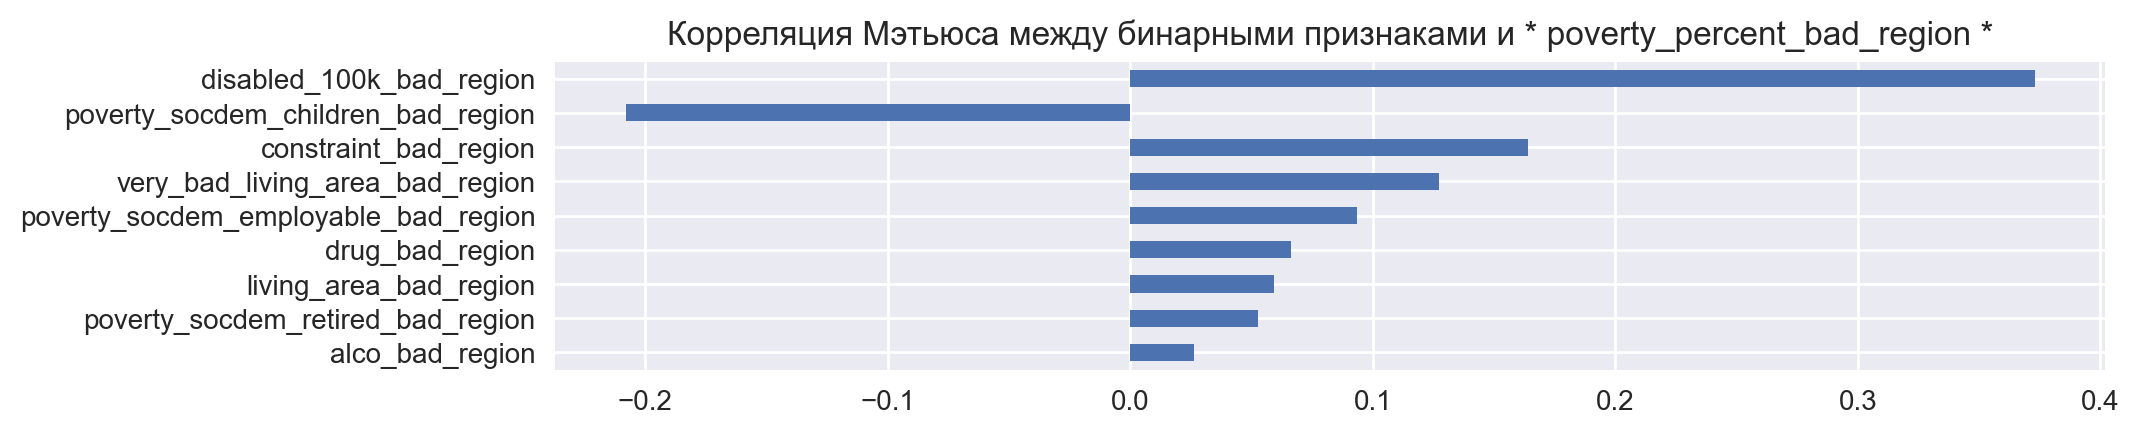

In [26]:
target_matthews_corrcoef(
    data=data, 
    binary_features=[
        'poverty_socdem_children_bad_region','poverty_socdem_retired_bad_region','poverty_socdem_employable_bad_region',
        #'population_children','population_employable','population_retired',
        'disabled_100k_bad_region', 'alco_bad_region', 'drug_bad_region',
        'constraint_bad_region','living_area_bad_region','very_bad_living_area_bad_region',
        'poverty_percent_bad_region'
    ], 
    target='poverty_percent_bad_region', 
    width=10, height=2, top_number=30)

**Выводы:**
- с увереностью можно говорить, что количество инвалидов среди трудоспособного возраста в расчете на 100k населения (**disabled_100k**) имеет положительную слабую связь с % людей за чертой бедности в регионе. Аналогичную связь мы видим между ПЛОХИМИ регионами по этим же показателям. Это может говорить о том, что именно эта группа населения чаще других сталкивается с бедностью.
- также, результаты корреляции Спирмена указывают на положительную слабую связь между % людей за чертой бедности в регионе и численностью детского населения. Объясняется это, вероятно, следующим образом: с ростом числа детей в семьях (или одной семье) снижается уровень дохода на каждого члена семьи в среднем (дети не работают) и , как следствие, растет бедность. Отсюда можно предположить высокий % населения ниже черты бедности среди многодетных семей.
- результаты по связям других групп населения с уровнем бедности в регионе говорят об очень слабой связи или отсутствии связи.

***

### 3.8. Есть ли разница в распределении малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) 

- Изучим распределение доли малоимущих среди несовершеннолетних:

Сводная таблица для кластеризации

Первый квартиль: 35.8
Медиана: 39.7, среднее: 39.1
Третий квартиль: 42.1


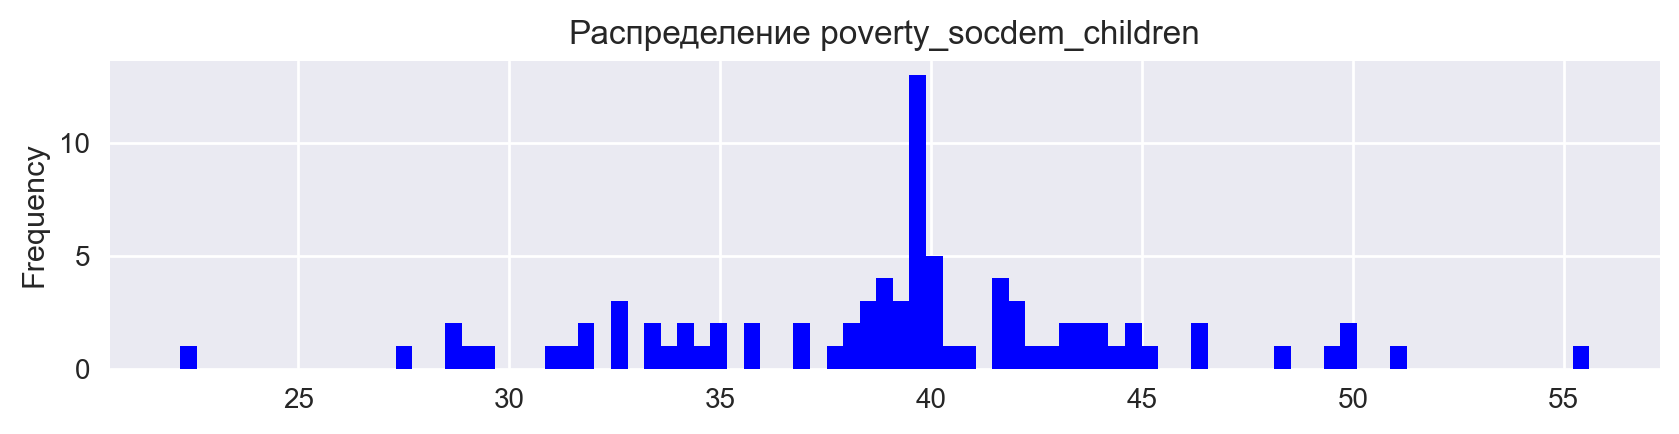

In [27]:
# визуализируем распределение признака poverty_socdem_children
feature_histogram(df=data, feature='poverty_socdem_children', bins=85)
# расчитаем дополнительные показатели
percentiles = np.percentile(data['poverty_socdem_children'], [25,50,75])
print(f'\nПервый квартиль: {percentiles[0]}')
print(f'Медиана: {percentiles[1]}, среднее: {round(data.poverty_socdem_children.mean(),1)}')
print(f'Третий квартиль: {percentiles[2]}')

- Изучим распределение доли малоимущих среди пенсионеров:

Сводная таблица для кластеризации

Первый квартиль: 3.3
Медиана: 5.2, среднее: 5.1
Третий квартиль: 6.5


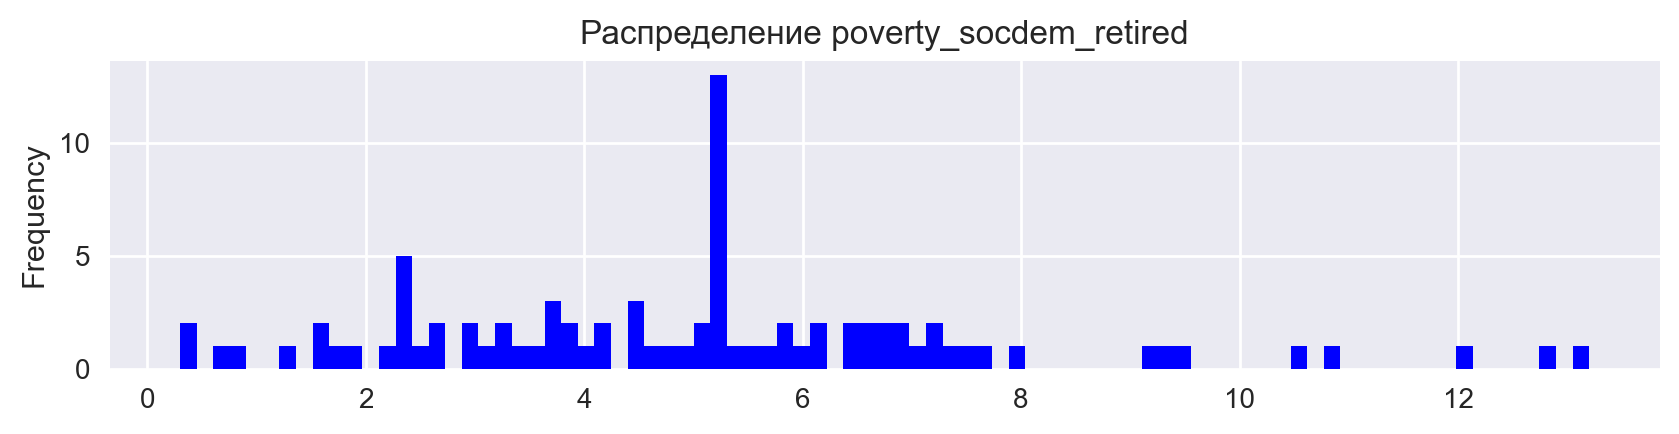

In [28]:
# визуализируем распределение признака poverty_socdem_retired
feature_histogram(df=data, feature='poverty_socdem_retired', bins=85)
# расчитаем дополнительные показатели
percentiles = np.percentile(data['poverty_socdem_retired'], [25,50,75])
print(f'\nПервый квартиль: {percentiles[0]}')
print(f'Медиана: {percentiles[1]}, среднее: {round(data.poverty_socdem_retired.mean(),1)}')
print(f'Третий квартиль: {percentiles[2]}')

- Изучим распределение доли малоимущих среди трудоспособных:

Сводная таблица для кластеризации

Первый квартиль: 53.3
Медиана: 55.2, среднее: 55.8
Третий квартиль: 58.6


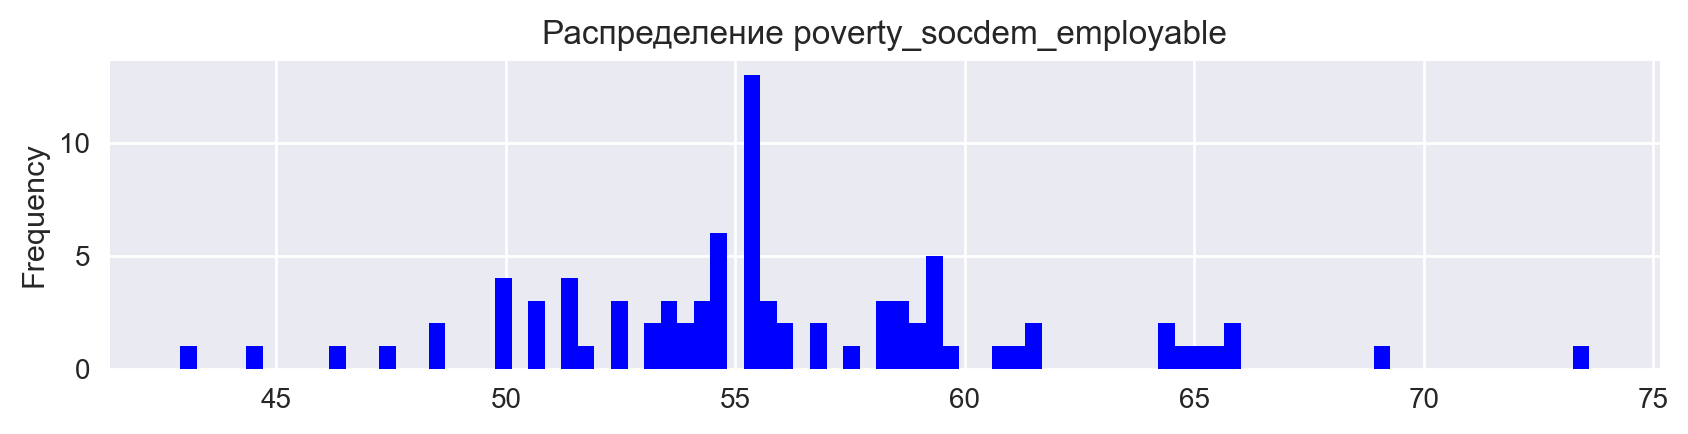

In [29]:
# визуализируем распределение признака poverty_socdem_employable
feature_histogram(df=data, feature='poverty_socdem_employable', bins=85)
# расчитаем дополнительные показатели
percentiles = np.percentile(data['poverty_socdem_employable'], [25,50,75])
print(f'\nПервый квартиль: {percentiles[0]}')
print(f'Медиана: {percentiles[1]}, среднее: {round(data.poverty_socdem_employable.mean(),1)}')
print(f'Третий квартиль: {percentiles[2]}')

**Вывод:** Разница в распределении есть, но это не точно.    

Проведем статистический тест:
- **нулевая гипотеза**: распределение малоимущего населения одинаково в представленных социально-демографических группах
- **альтенативная гипотеза**: распределение малоимущего населения в социально-демографических группах отличается (наибольшее в трудоспособной группе, наменьшее в группе пенсионеров и промежуточное в группе несовершеннолетних)

Еще раз проведем тест на нормальность:

In [30]:
normal_test_df(
    df=data[['poverty_socdem_children','poverty_socdem_retired','poverty_socdem_employable']],
    alpha=0.05 # уровень значимости
    )

Эти признаки распределены нормально:


* тест Шапиро-Уилка *       * тест ДАгостино *
1  poverty_socdem_children  poverty_socdem_children

С учетом того, что только один признак распределен нормально, а два других - нет, проведем непараметрический тест. Используем Критерий Краскела — Уоллиса.

In [31]:
# Критерий Краскела — Уоллиса

# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p = stats.kruskal(data['poverty_socdem_children'], data['poverty_socdem_retired'], data['poverty_socdem_employable'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Выводы:**
- есть статистически значимая разница в распределении доли малоимущего населения по социально-демографическим группам.
- наибольшая доля малоимущих среди трудоспособного населения, наименьшая среди пенсионеров, промежуточная (но достаточно высокая) среди несовершеннолетних

***

### 3.9. Cвязаны ли уровень бедности с производством и потреблением в регионе

Оценим связь % людей за чертой бедности в регионе (признак **poverty_percent**) и различными видами производства и обеспечения, оборотом розничной торговли, валовым региональным продуктом на душу населения:

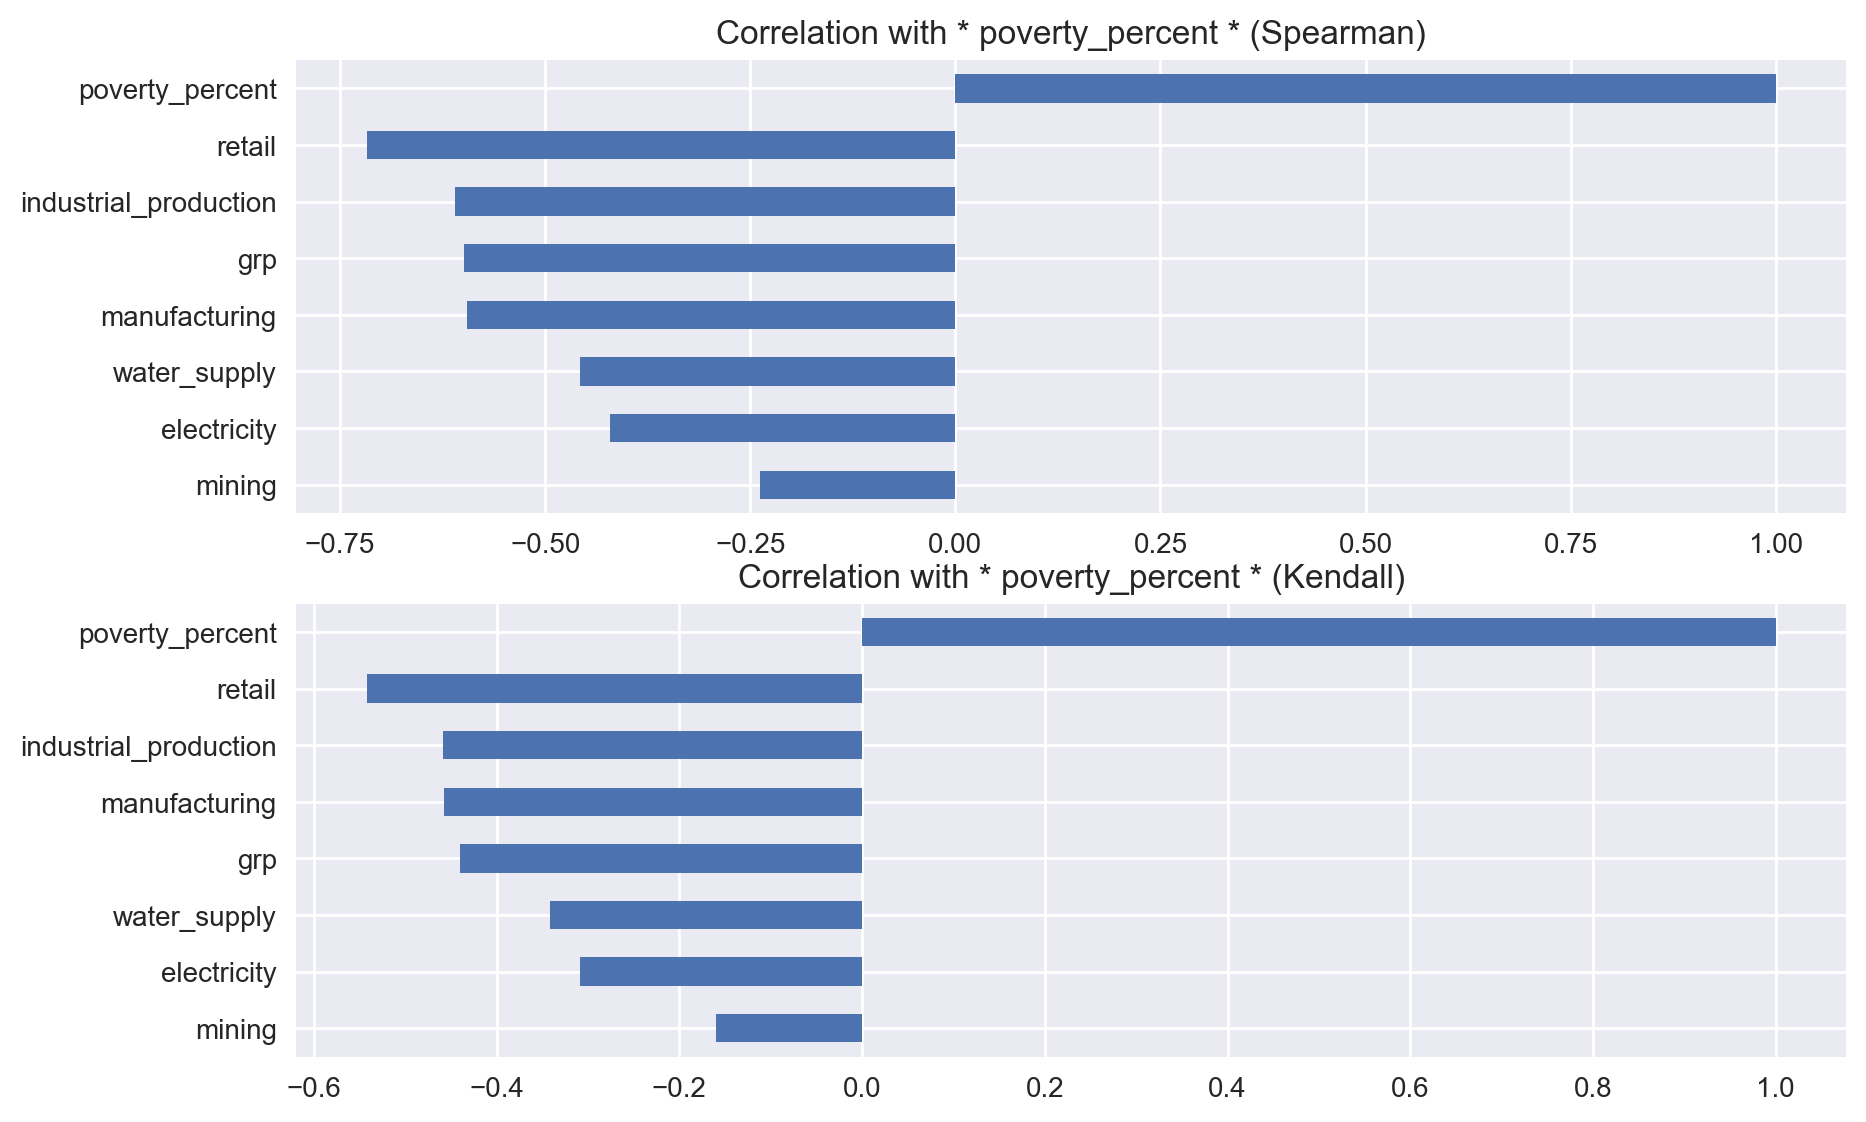

In [32]:
target_corr_visual(
    data=data[[
        'mining','manufacturing','electricity','water_supply','industrial_production','retail','grp',
        'poverty_percent'
    ]],
    target='poverty_percent', 
    width=10, height=10, top_number=20
)

Оценим связь ПЛОХИХ регионов по показателю % людей за чертой бедности в регионе (признак **poverty_percent_bad_region**) и ПЛОХИХ регионов по различным видам производства и обеспечения, обороту розничной торговли, уровню валового регионального продукта:

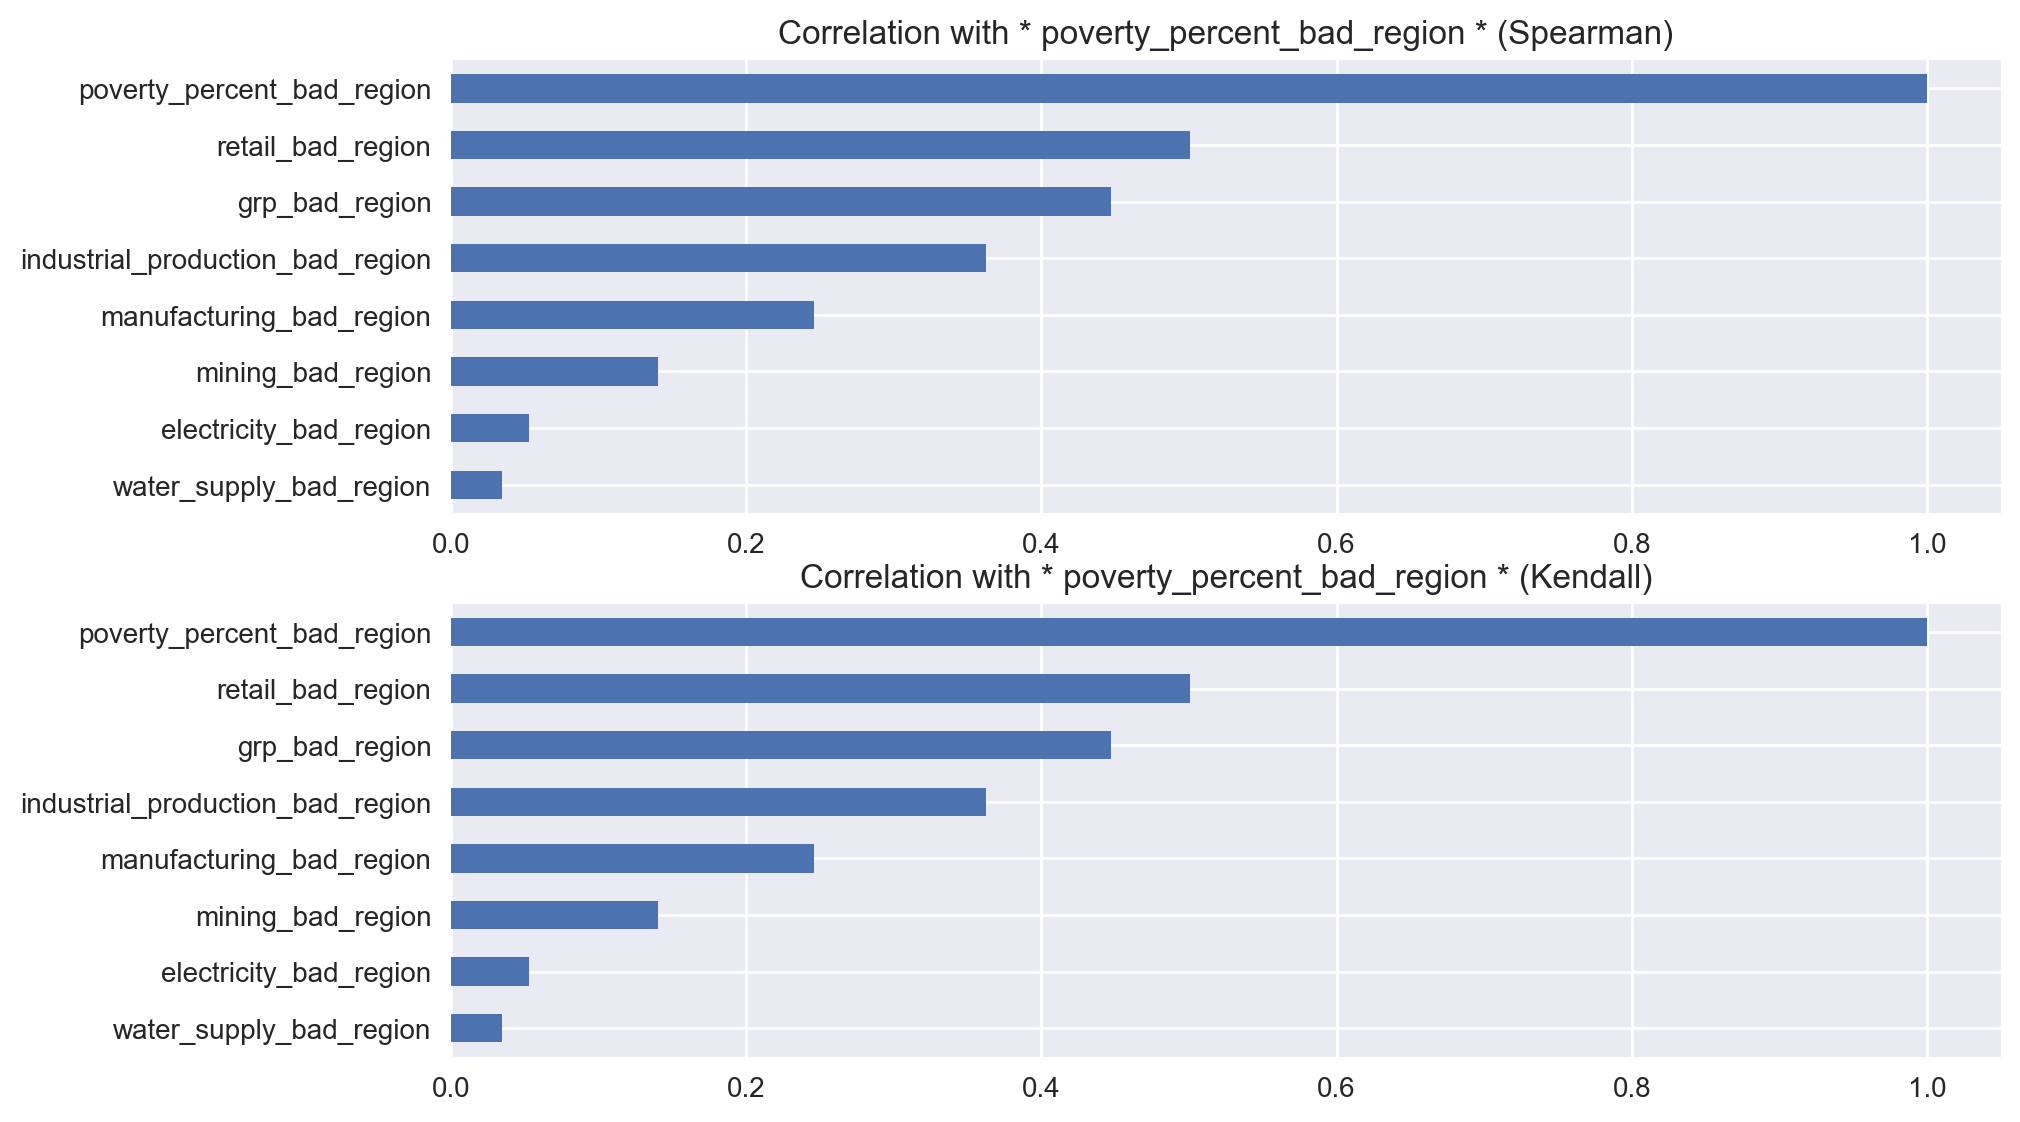

In [33]:
target_corr_visual(
    data=data[[
        'mining_bad_region','manufacturing_bad_region','electricity_bad_region','water_supply_bad_region',
        'industrial_production_bad_region','retail_bad_region','grp_bad_region',
        'poverty_percent_bad_region'
    ]],
    target='poverty_percent_bad_region', 
    width=10, height=10, top_number=20
)

Оценим то же, но с помощью теста Xi-квадрат:

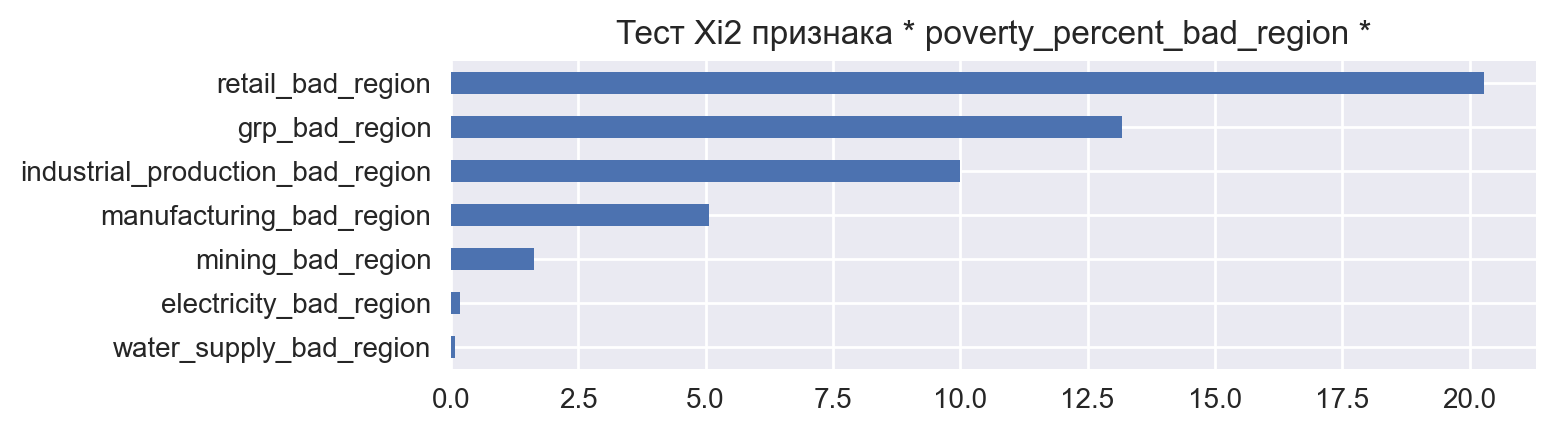

In [34]:
target_xi2_test(
    data=data[[
        'mining_bad_region','manufacturing_bad_region','electricity_bad_region','water_supply_bad_region',
        'industrial_production_bad_region','retail_bad_region','grp_bad_region',
        'poverty_percent_bad_region'
    ]],
    target='poverty_percent_bad_region', 
    width=7, height=2)

Оценим то же, но с помощью корреляции Мэтьюса для бинарных признаков:

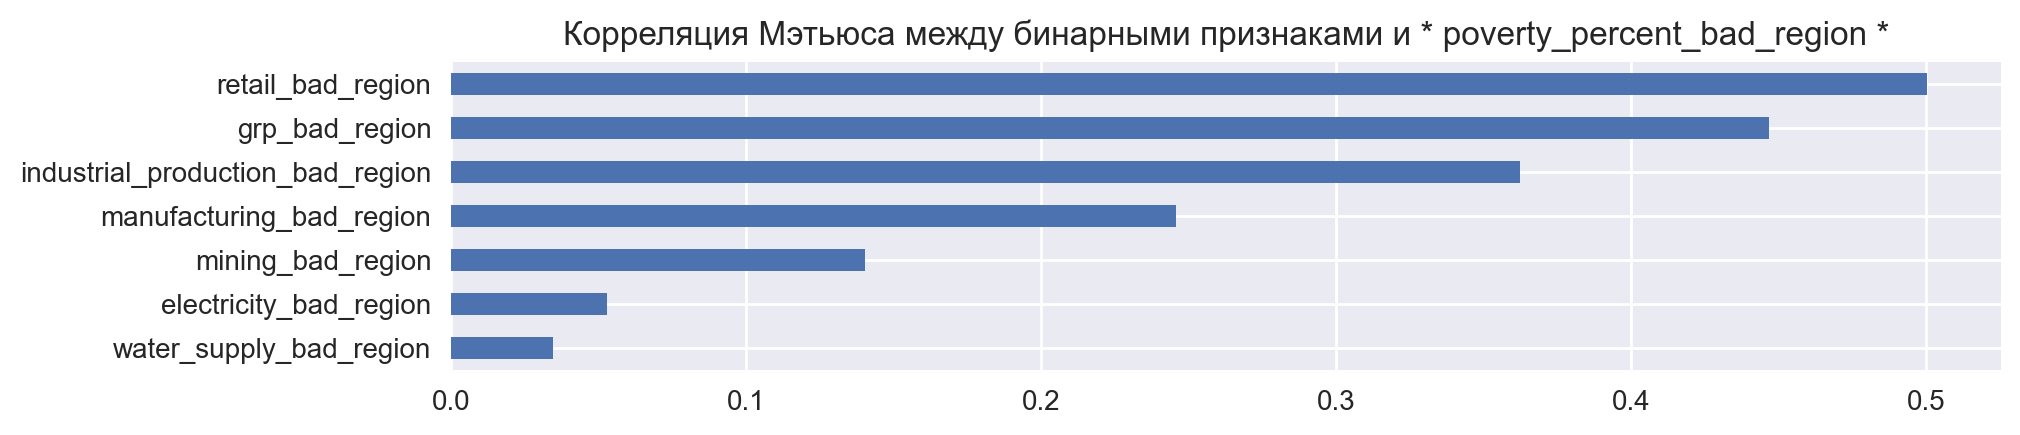

In [35]:
target_matthews_corrcoef(
    data=data, 
    binary_features=[
        'mining_bad_region','manufacturing_bad_region','electricity_bad_region','water_supply_bad_region',
        'industrial_production_bad_region','retail_bad_region','grp_bad_region',
        'poverty_percent_bad_region'
    ], 
    target='poverty_percent_bad_region', 
    width=10, height=2, top_number=30)

**Выводы:**
- мы видим сильную/среднюю отрицательную связь признаков уровня бедности в регионе и оборота розничной торговли
- также среднюю отрицательную связь признаков уровня бедности в регионе и показателей промышленного и обрабатывающего производств, валового регионального продукта, электроэнергии (и пр.), водоснабжения (и пр.)
- при оценке категориальных/бинарных признаков ПЛОХИХ регионов по данным показателям мы также отмечаем положительную среднюю связь по показателям оборота розничной торговли, валового регионального продукта, пром. производства и производного ключевого признака

***

### 3.10. Cвязаны ли доля неблагополучных групп населения/показателей неблагополучия с производством и потреблением в регионе

Изучим корреляцию Спирмена интересуемых признаков:

In [36]:
get_top_abs_correlations(
    df=data[[
        'child_mortality_100k','disabled_100k','alco','drug','constraint','very_bad_living_area',
        'general_morbidity','congenital_malformation','psychosis','teenage_pregnancy',
        'conditions_in_perinatal',

        'mining','manufacturing','electricity','water_supply','industrial_production','retail','grp',
    ]],
    method='spearman', # используем корреляцию Спирмена
    top_number=40
)

Top Absolute Correlations


corr
manufacturing           industrial_production    0.893825
electricity             industrial_production    0.859038
manufacturing           electricity              0.796443
                        water_supply             0.786402
water_supply            industrial_production    0.778683
electricity             water_supply             0.757449
retail                  grp                      0.696072
mining                  grp                      0.676529
industrial_production   grp                      0.651280
mining                  industrial_production    0.590385
disabled_100k           grp                     -0.575555
industrial_production   retail                   0.568263
mining                  electricity              0.544010
general_morbidity       congenital_malformation  0.521133
                        psychosis                0.489537
manufacturing           retail                   0.483584
alco                    psychosis                0.480156
electricity             retail                   0.478659
                        grp                      0.478034
manufacturing           grp                      0.447372
disabled_100k           industrial_production   -0.439048
                        retail                  -0.418411
congenital_malformation psychosis                0.417772
constraint              very_bad_living_area     0.391782
disabled_100k           electricity             -0.373375
                        manufacturing           -0.370316
child_mortality_100k    manufacturing           -0.369461
mining                  retail                   0.365273
child_mortality_100k    water_supply            -0.355119
mining                  water_supply             0.343328
general_morbidity       grp                      0.335763
water_supply            retail                   0.327694
disabled_100k           mining                  -0.327469
water_supply            grp                      0.323042
child_mortality_100k    very_bad_living_area     0.322509
alco                    congenital_malformation  0.321568
                        general_morbidity        0.320855
psychosis               grp                      0.311307
disabled_100k           water_supply            -0.301518
drug                    electricity              0.294584

Изучим корреляцию Кендалла интересуемых признаков:

In [37]:
get_top_abs_correlations(
    df=data[[
        'child_mortality_100k','disabled_100k','alco','drug','constraint','very_bad_living_area',
        'general_morbidity','congenital_malformation','psychosis','teenage_pregnancy',
        'conditions_in_perinatal',

        'mining','manufacturing','electricity','water_supply','industrial_production','retail','grp',
    ]],
    method='kendall', # используем корреляцию Кендалла
    top_number=25
)

Top Absolute Correlations


corr
manufacturing           industrial_production    0.773109
electricity             industrial_production    0.688515
manufacturing           water_supply             0.665359
water_supply            industrial_production    0.654714
electricity             water_supply             0.624457
manufacturing           electricity              0.620728
retail                  grp                      0.515966
industrial_production   grp                      0.484594
mining                  grp                      0.474510
disabled_100k           grp                     -0.421067
industrial_production   retail                   0.412885
mining                  industrial_production    0.412885
                        electricity              0.388235
general_morbidity       congenital_malformation  0.361777
manufacturing           retail                   0.347339
general_morbidity       psychosis                0.347107
electricity             retail                   0.343417
alco                    psychosis                0.342120
electricity             grp                      0.337815
manufacturing           grp                      0.337255
disabled_100k           industrial_production   -0.316291
                        retail                  -0.295560
constraint              very_bad_living_area     0.292313
congenital_malformation psychosis                0.290919
child_mortality_100k    manufacturing           -0.271452

**Выводы:**
- отмечается средняя отрицательная связь между числом инвалидов среди трудоспособного населения и региональным валовым продуктом на душу населения
- отмечается средняя/слабая отрицательная связь между числом инвалидов среди трудоспособного населения и промышленным производством
- отмечается слабая отрицательная связь между детской смертностью на первом году жизни и обрабатывающим производством (почему?)
- отдельно по корреляции Спирмена:
    - слабая отрицательная связь между количеством инвалидов и обеспечением электроэнергией (и пр.) и обрабатывающим производством, а также с добычей полезных ископаемых
    - слабая отрицательная связь между детской смертностью на первом году жизни и водоснабжением (и пр.) и % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания
- из интересного:
    - положительная средняя связь между алкоголизмом и психическими расстройствами
    - слабая/средняя связь между врожденными пороками развития и психическими нарушениями
    - положительная слабая связь (по корреляции Спирмена) между алкоголизмом и общей смертностью, врожденными пороками развития

***

### 3.11. Влияет ли доля тяжких и особо тяжких преступлений на уровень бедности в регионе

Используем корреляции Спирмена и Кендалла для непрерывных числовых признаков:

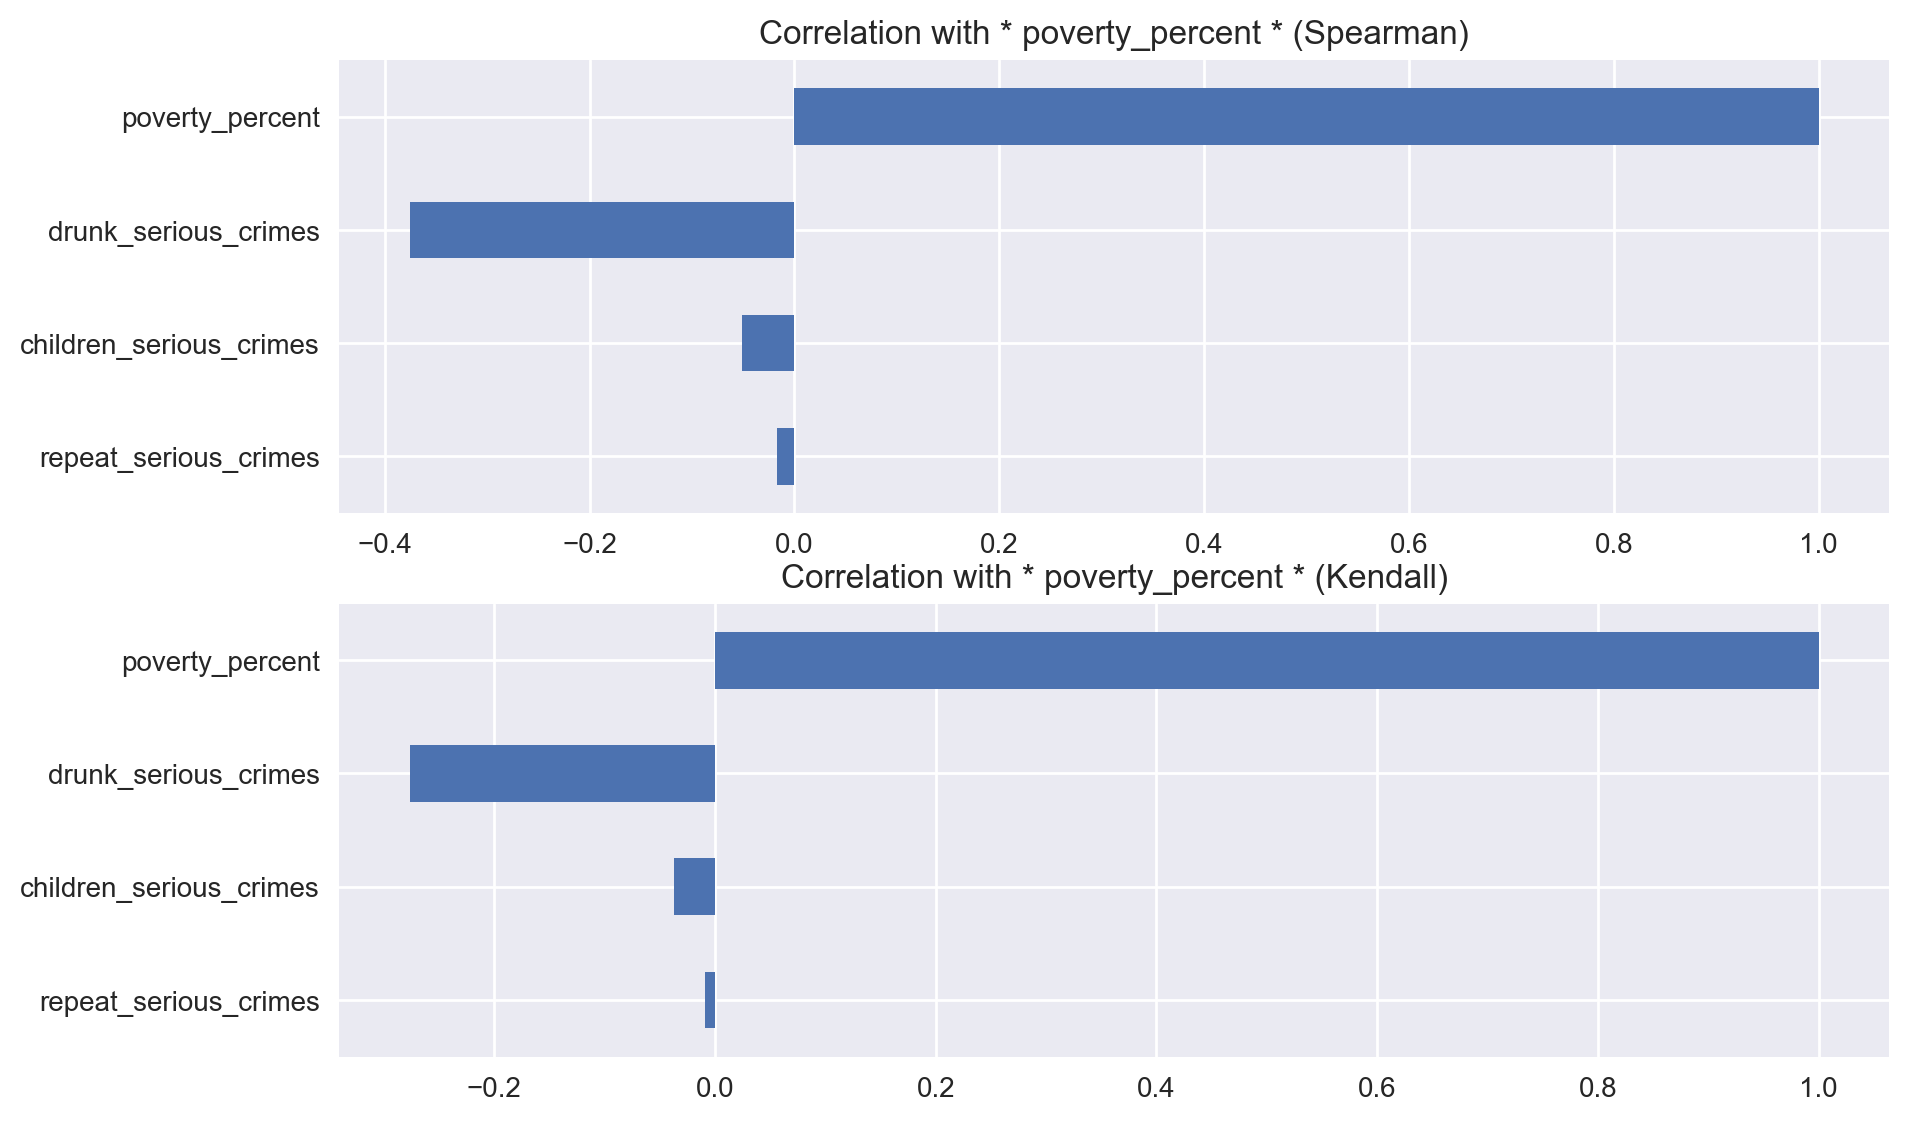

In [38]:
target_corr_visual(
    data=data[[
        'children_serious_crimes','repeat_serious_crimes','drunk_serious_crimes',
        'poverty_percent'
    ]],
    target='poverty_percent', 
    width=10, height=10, top_number=20
)

Используем корреляции Спирмена и Кендалла для категориальных/бинарных числовых признаков:

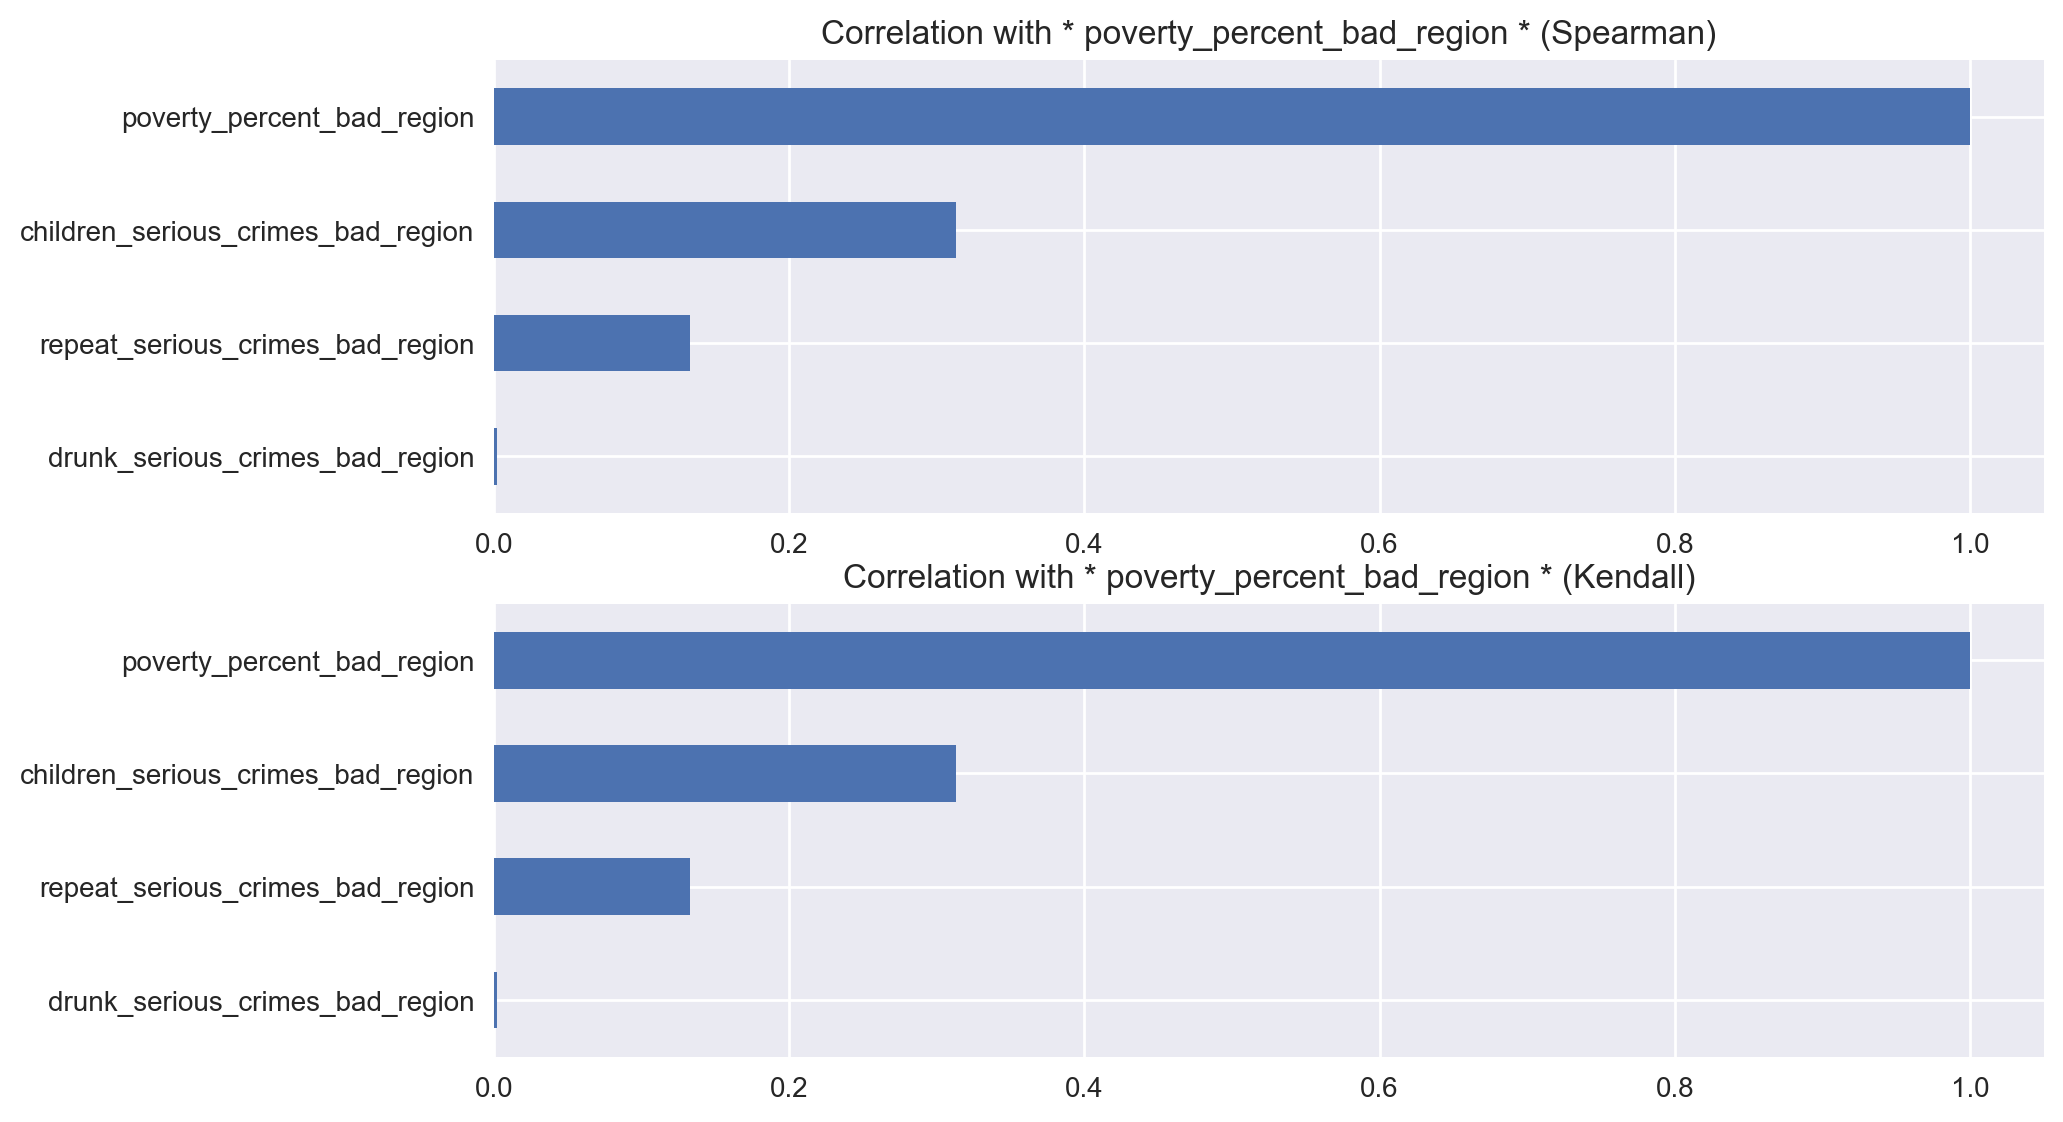

In [39]:
target_corr_visual(
    data=data[[
        'children_serious_crimes_bad_region','repeat_serious_crimes_bad_region','drunk_serious_crimes_bad_region',
        'poverty_percent_bad_region'
    ]],
    target='poverty_percent_bad_region', 
    width=10, height=10, top_number=20
)

Используем тест Xi2 для категориальных/бинарных числовых признаков:

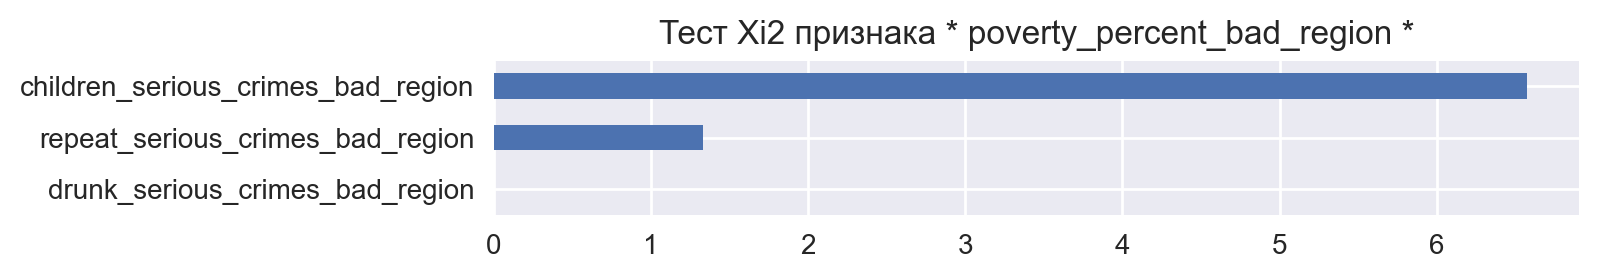

In [40]:
target_xi2_test(
    data=data[[
        'children_serious_crimes_bad_region','repeat_serious_crimes_bad_region','drunk_serious_crimes_bad_region',
        'poverty_percent_bad_region'
    ]],
    target='poverty_percent_bad_region', 
    width=7, height=1)

Используем корреляцию Мэтьюса для бинарных числовых признаков:

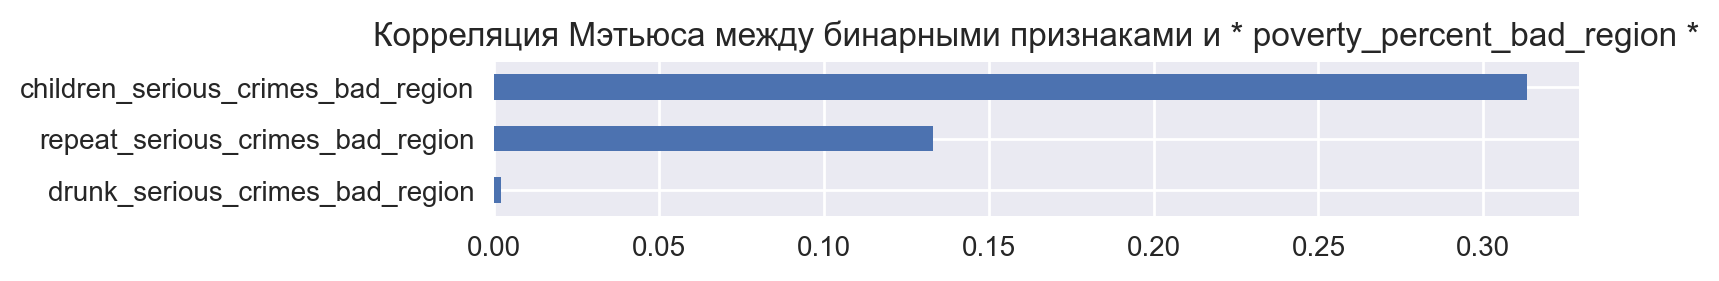

In [41]:
target_matthews_corrcoef(
    data=data, 
    binary_features=[
        'children_serious_crimes_bad_region','repeat_serious_crimes_bad_region','drunk_serious_crimes_bad_region',
        'poverty_percent_bad_region'
    ], 
    target='poverty_percent_bad_region', 
    width=7, height=1, top_number=30)

**Выводы:**
- для признака **drunk_serious_crimes** (доля тяжких и особо тяжких преступлений среди преступлений в состоянии алкогольного опьянения) выявлена слабая отрицательная связь с целевым признаком
- выявлена слабая положительная связь между ПЛОХИМИ регионами по тяжким и особо тяжким преступлениям среди несовершеннолетних и производным целевого признака **poverty_percent_bad_region**

***

### 3.12. Как влияют признаки тренда и плохого региона на уровень бедности в регионе

In [42]:
# добавим ключевой признак в список категориальных признаков
categorial_features.append('poverty_percent')

- Изучим корреляции Спирмена и Кендалла взаимосвязи ключевого признака и категориальных признаков (признаки тренда и плохого региона).     
**Примечание:** честно говоря, я не совсем уверен, что таким способом правильно сравнивать взаимосвязь непрерывного признака и категориальных.

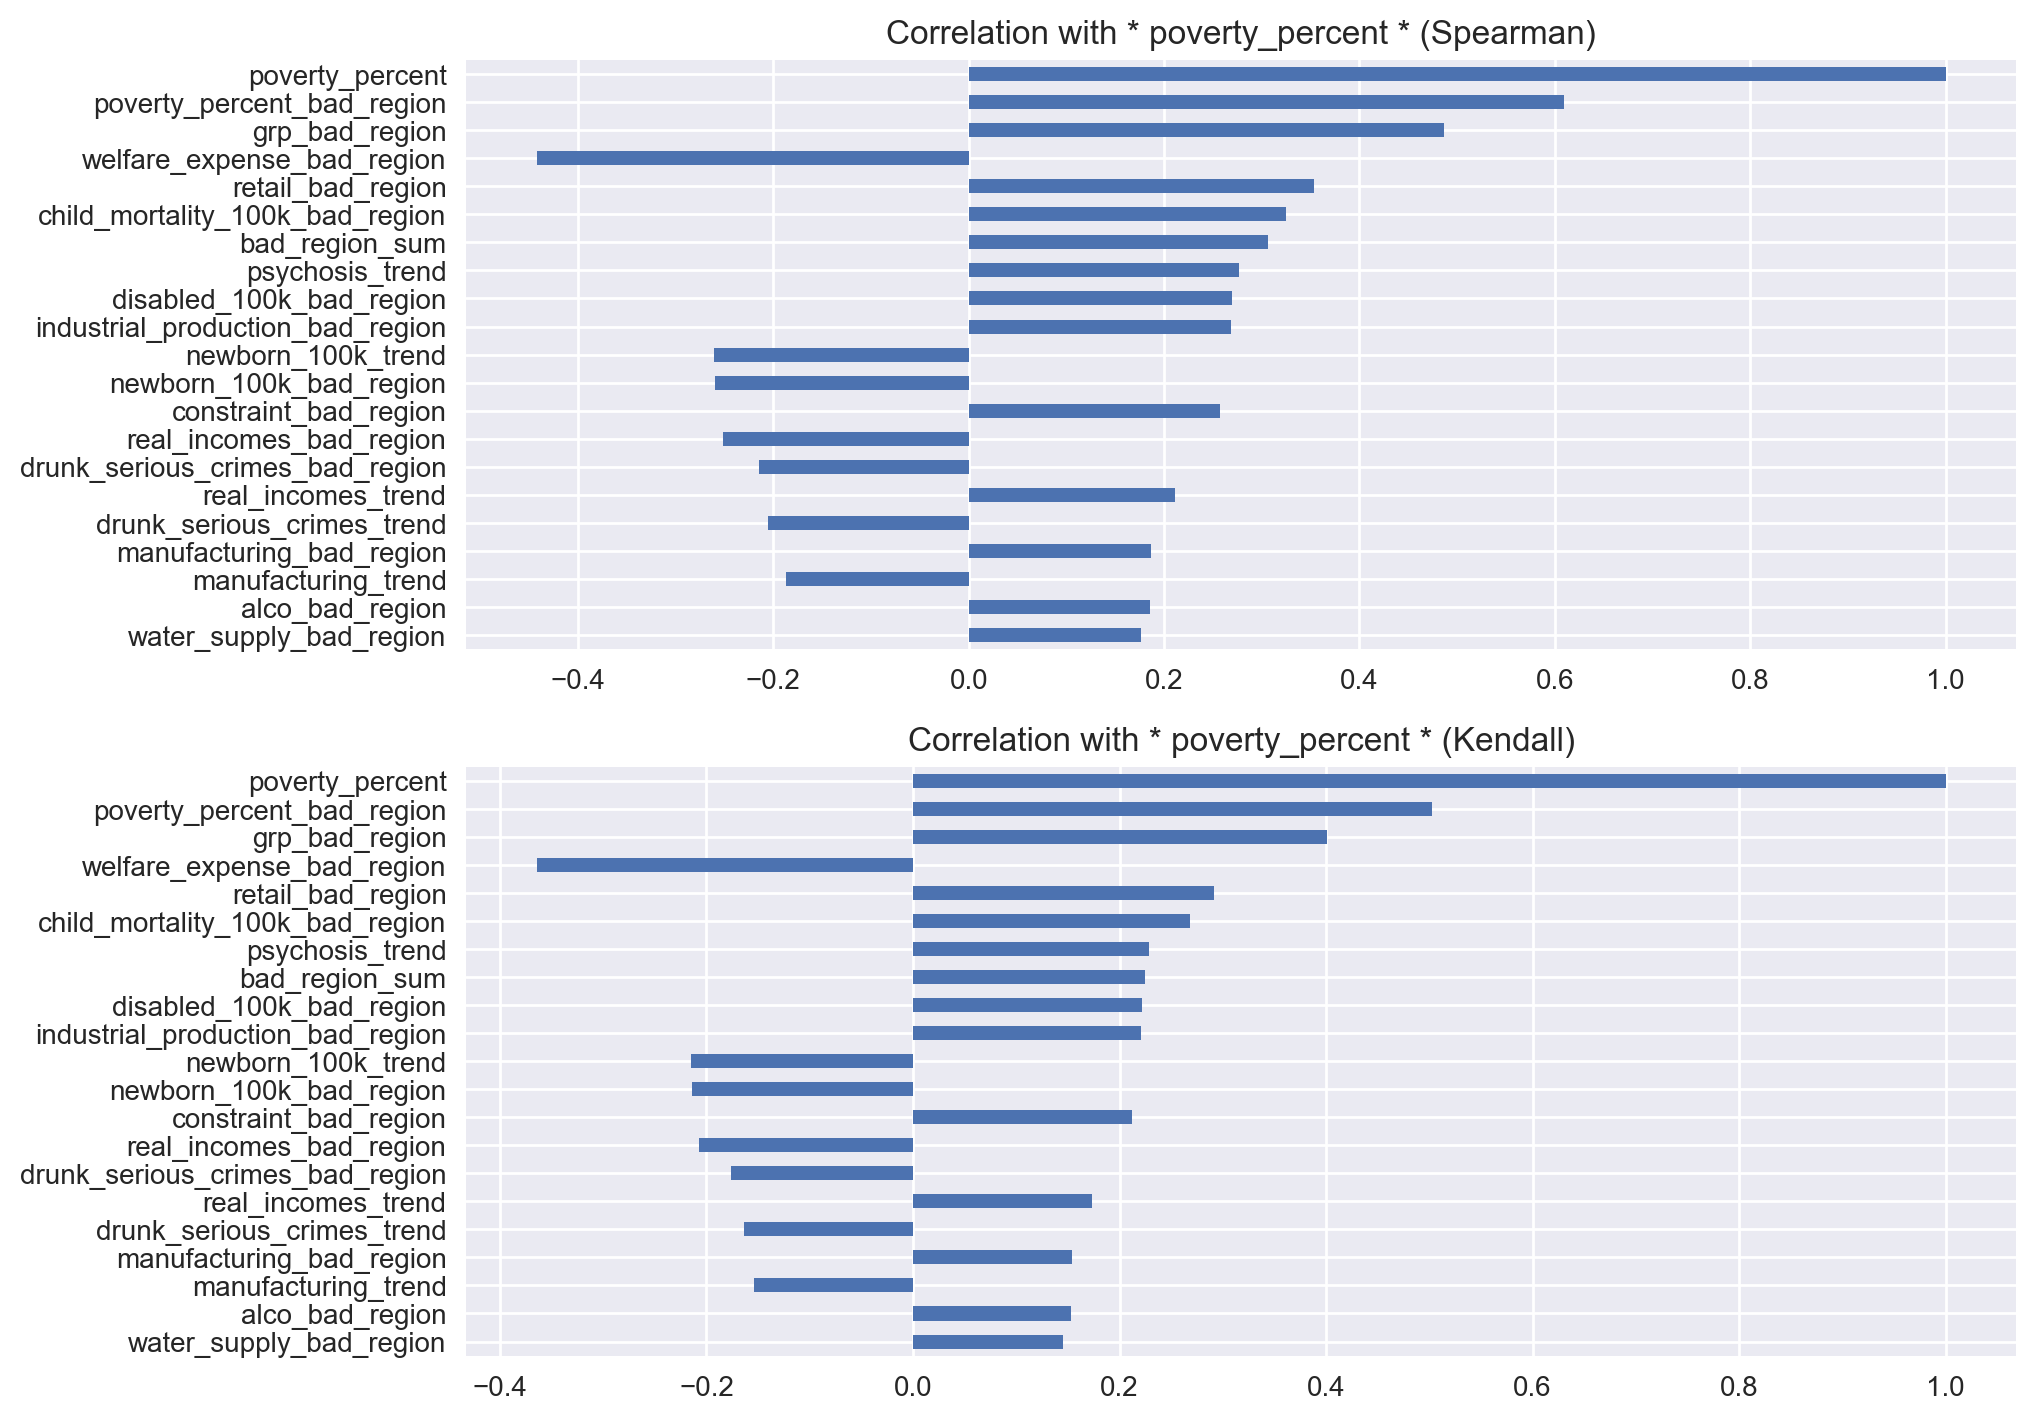

In [43]:
target_corr_visual(
    data=data[categorial_features],
    target='poverty_percent', 
    width=10, height=13, top_number=20
)

- Таким же образом сравним связь признака **poverty_percent_trend** и других категориальных признаков:

In [44]:
# удалим ключевой признак из категориальных
categorial_features.remove('poverty_percent')

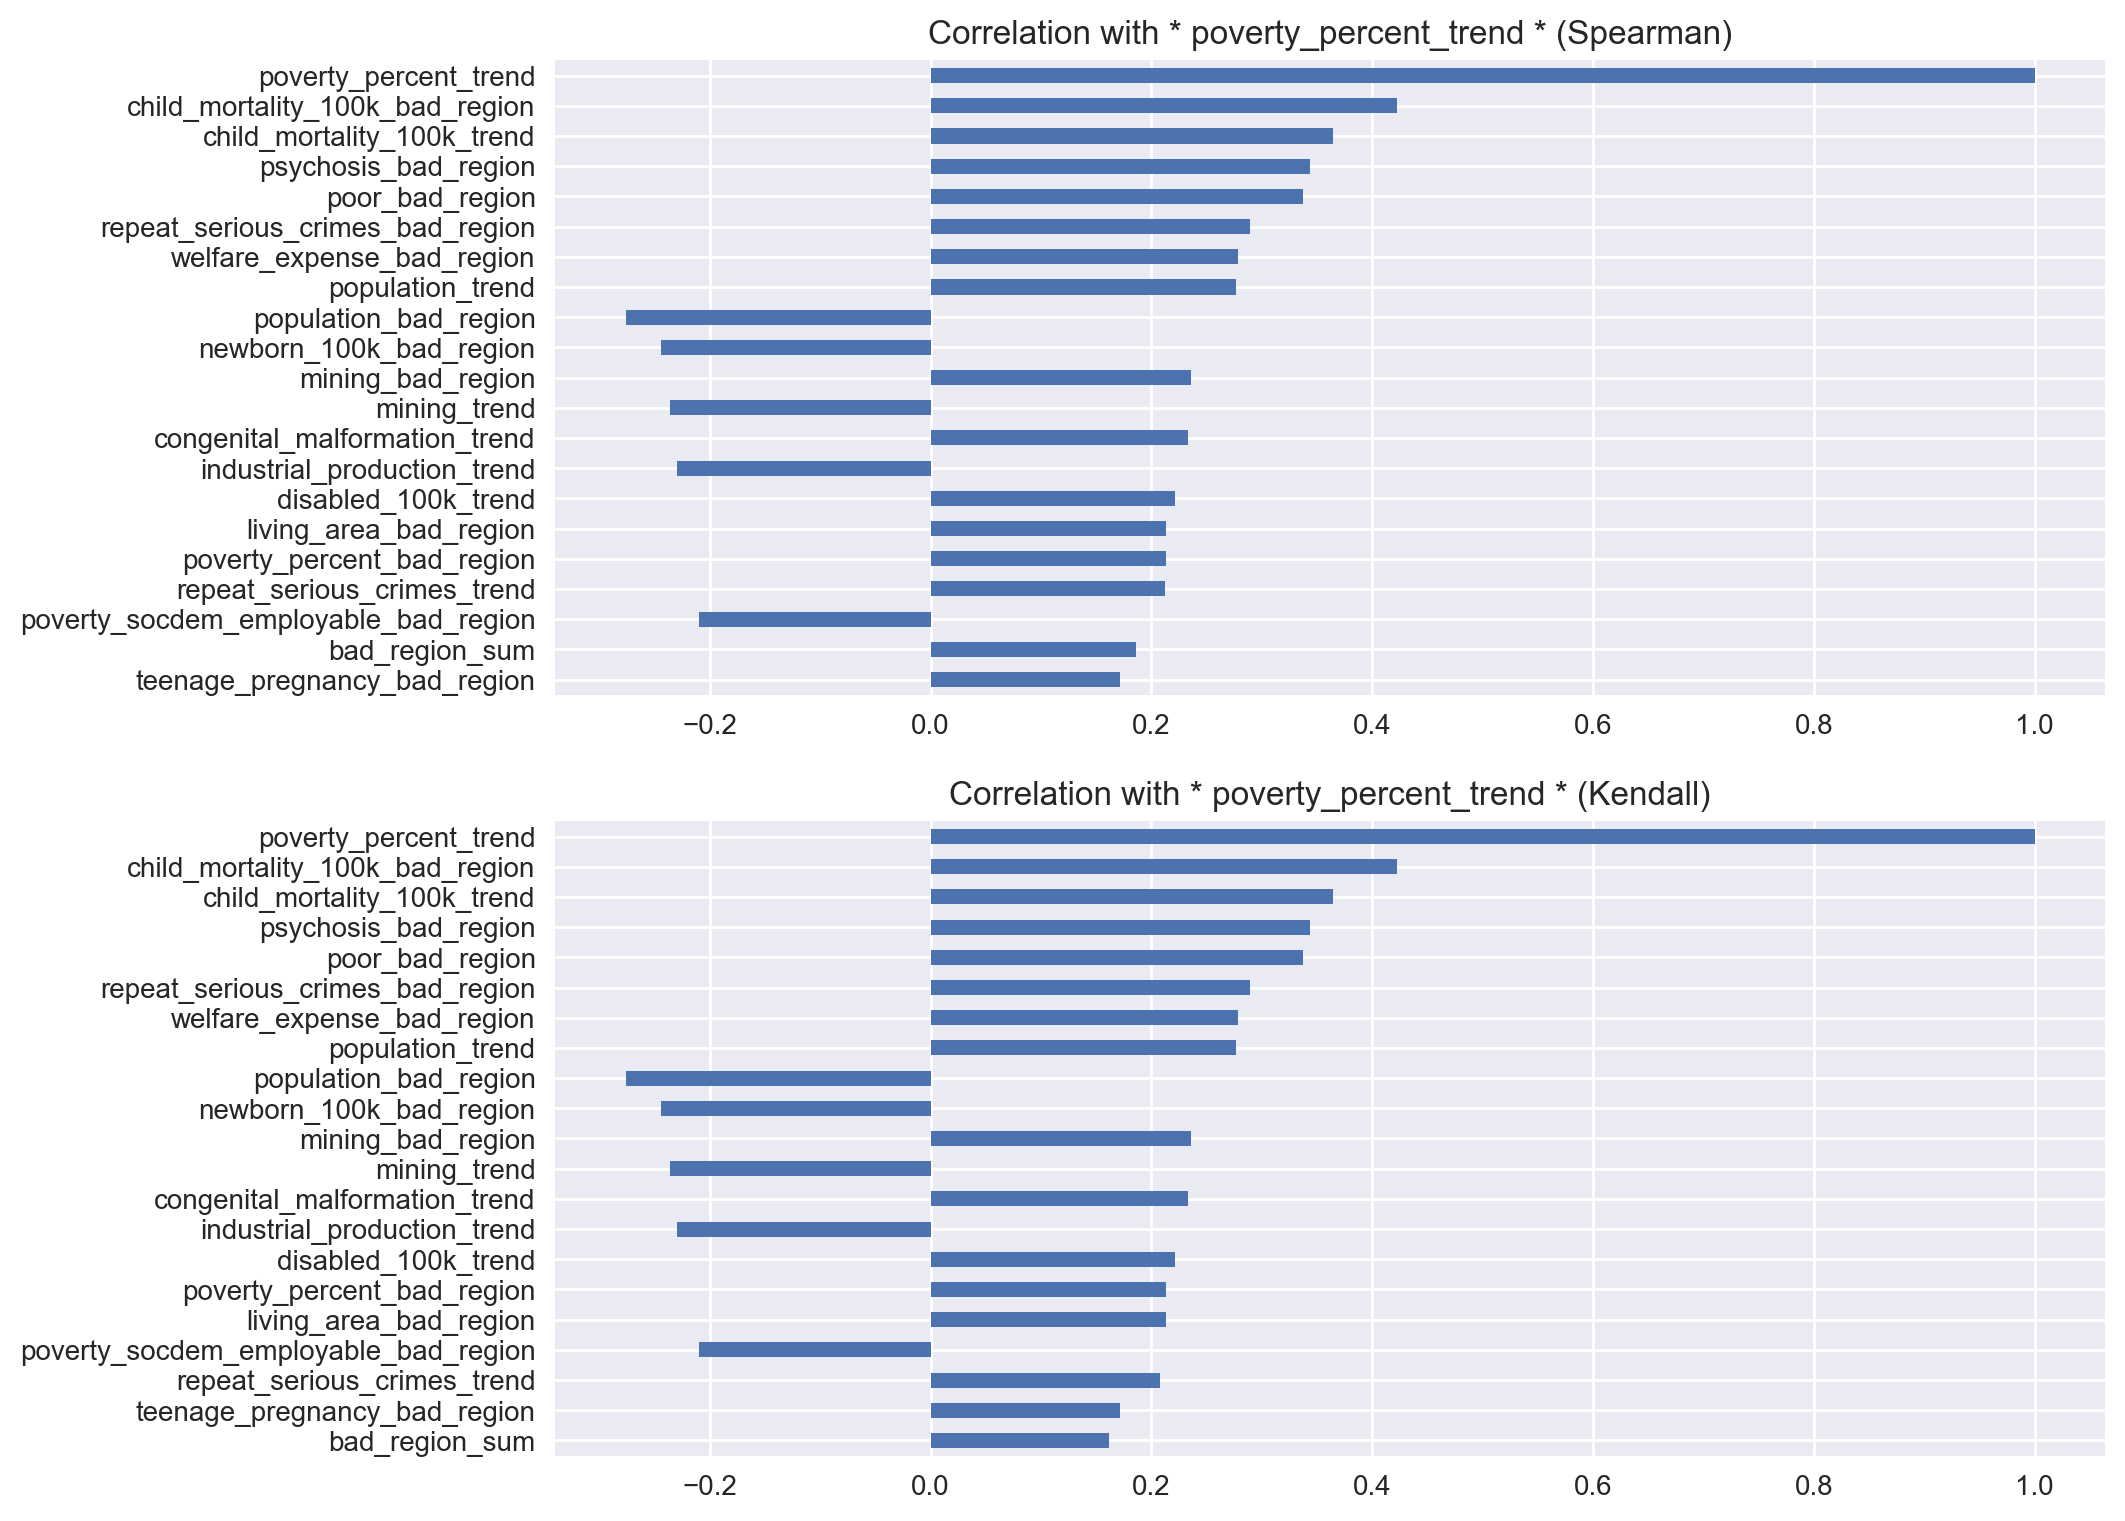

In [45]:
target_corr_visual(
    data=data[categorial_features],
    target='poverty_percent_trend', 
    width=10, height=14, top_number=20
)

Дополним тестом Xi2:

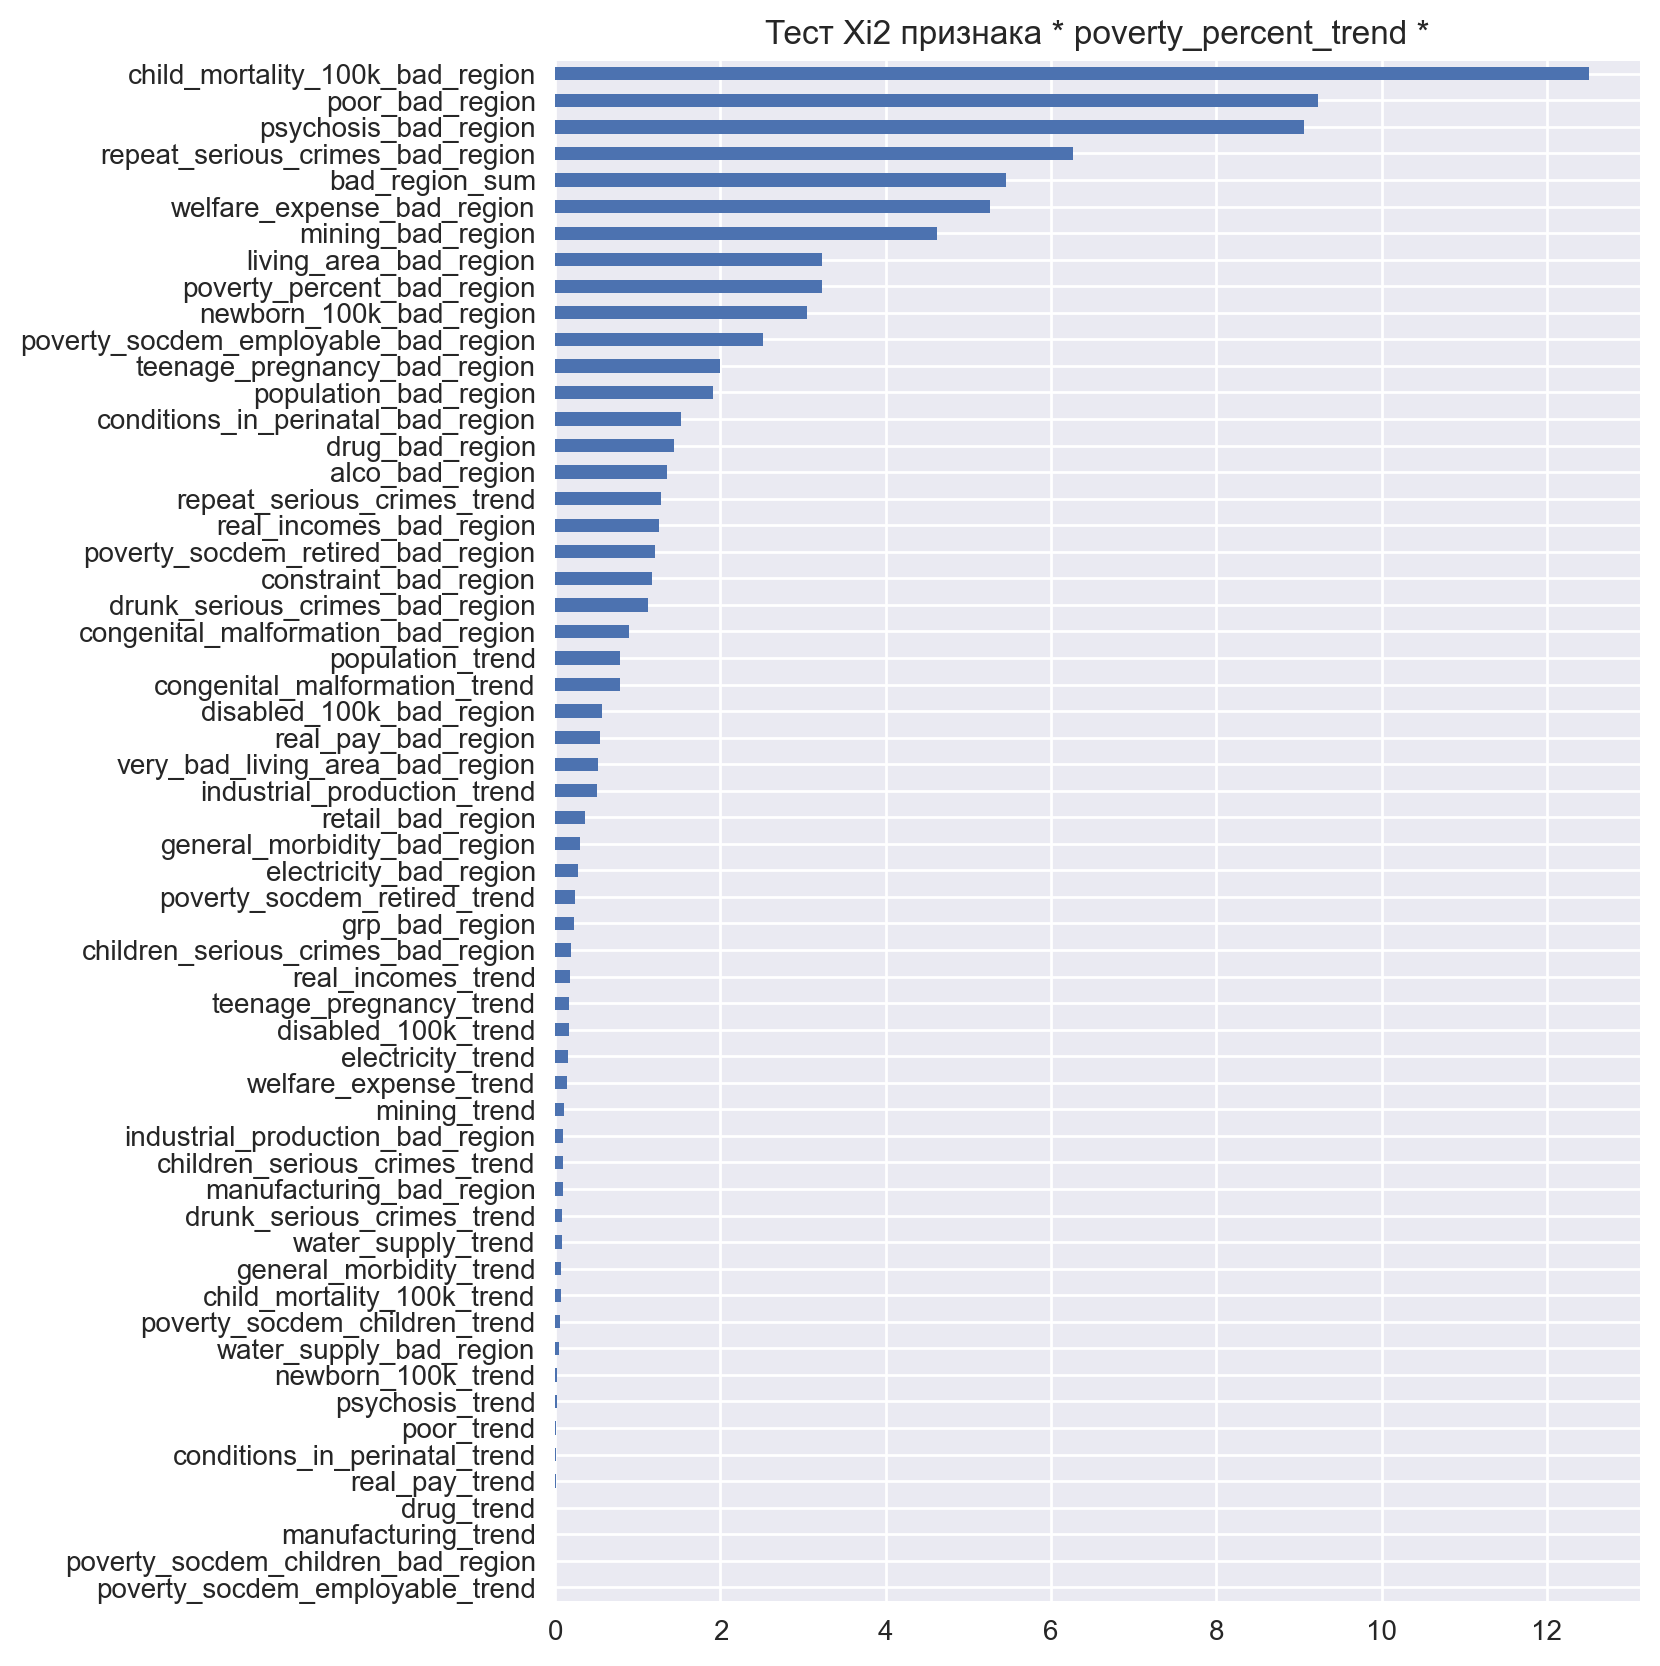

In [46]:
target_xi2_test(
    data=data[categorial_features].replace(-1,2), # замена -1 в признаке тренда на 2
    target='poverty_percent_trend', 
    width=7, height=10)

- Таким же образом сравним связь признака **poverty_percent_bad_region** и других категориальных признаков:

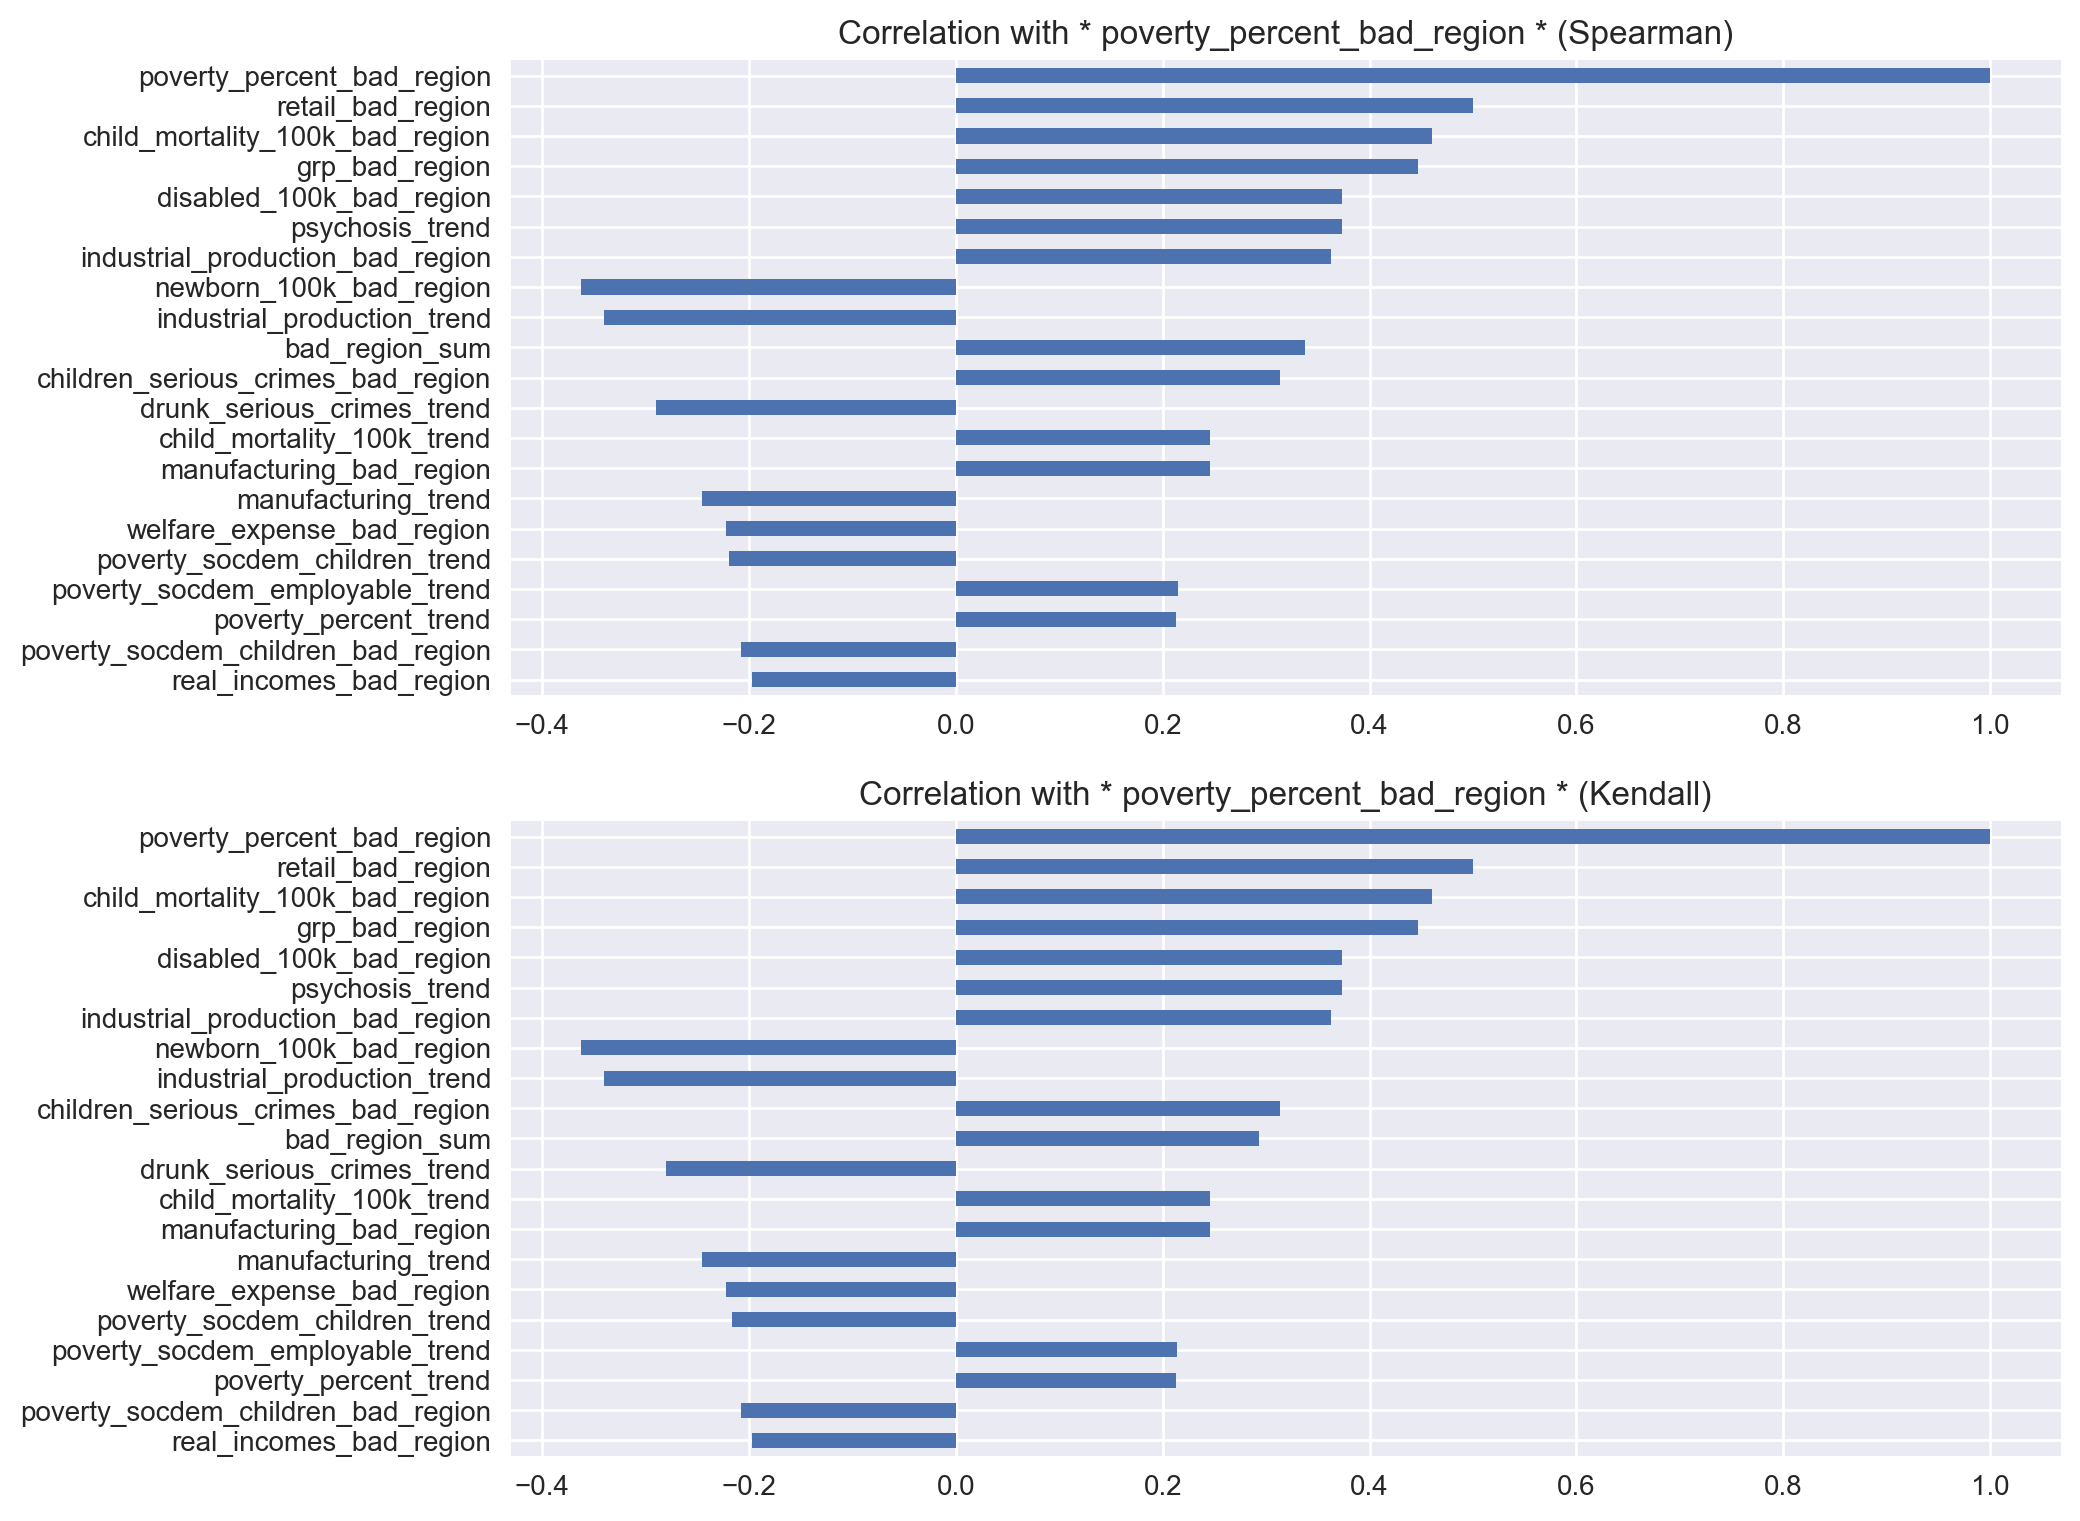

In [47]:
target_corr_visual(
    data=data[categorial_features],
    target='poverty_percent_bad_region', 
    width=10, height=14, top_number=20
)

Дополним тестом Xi2:

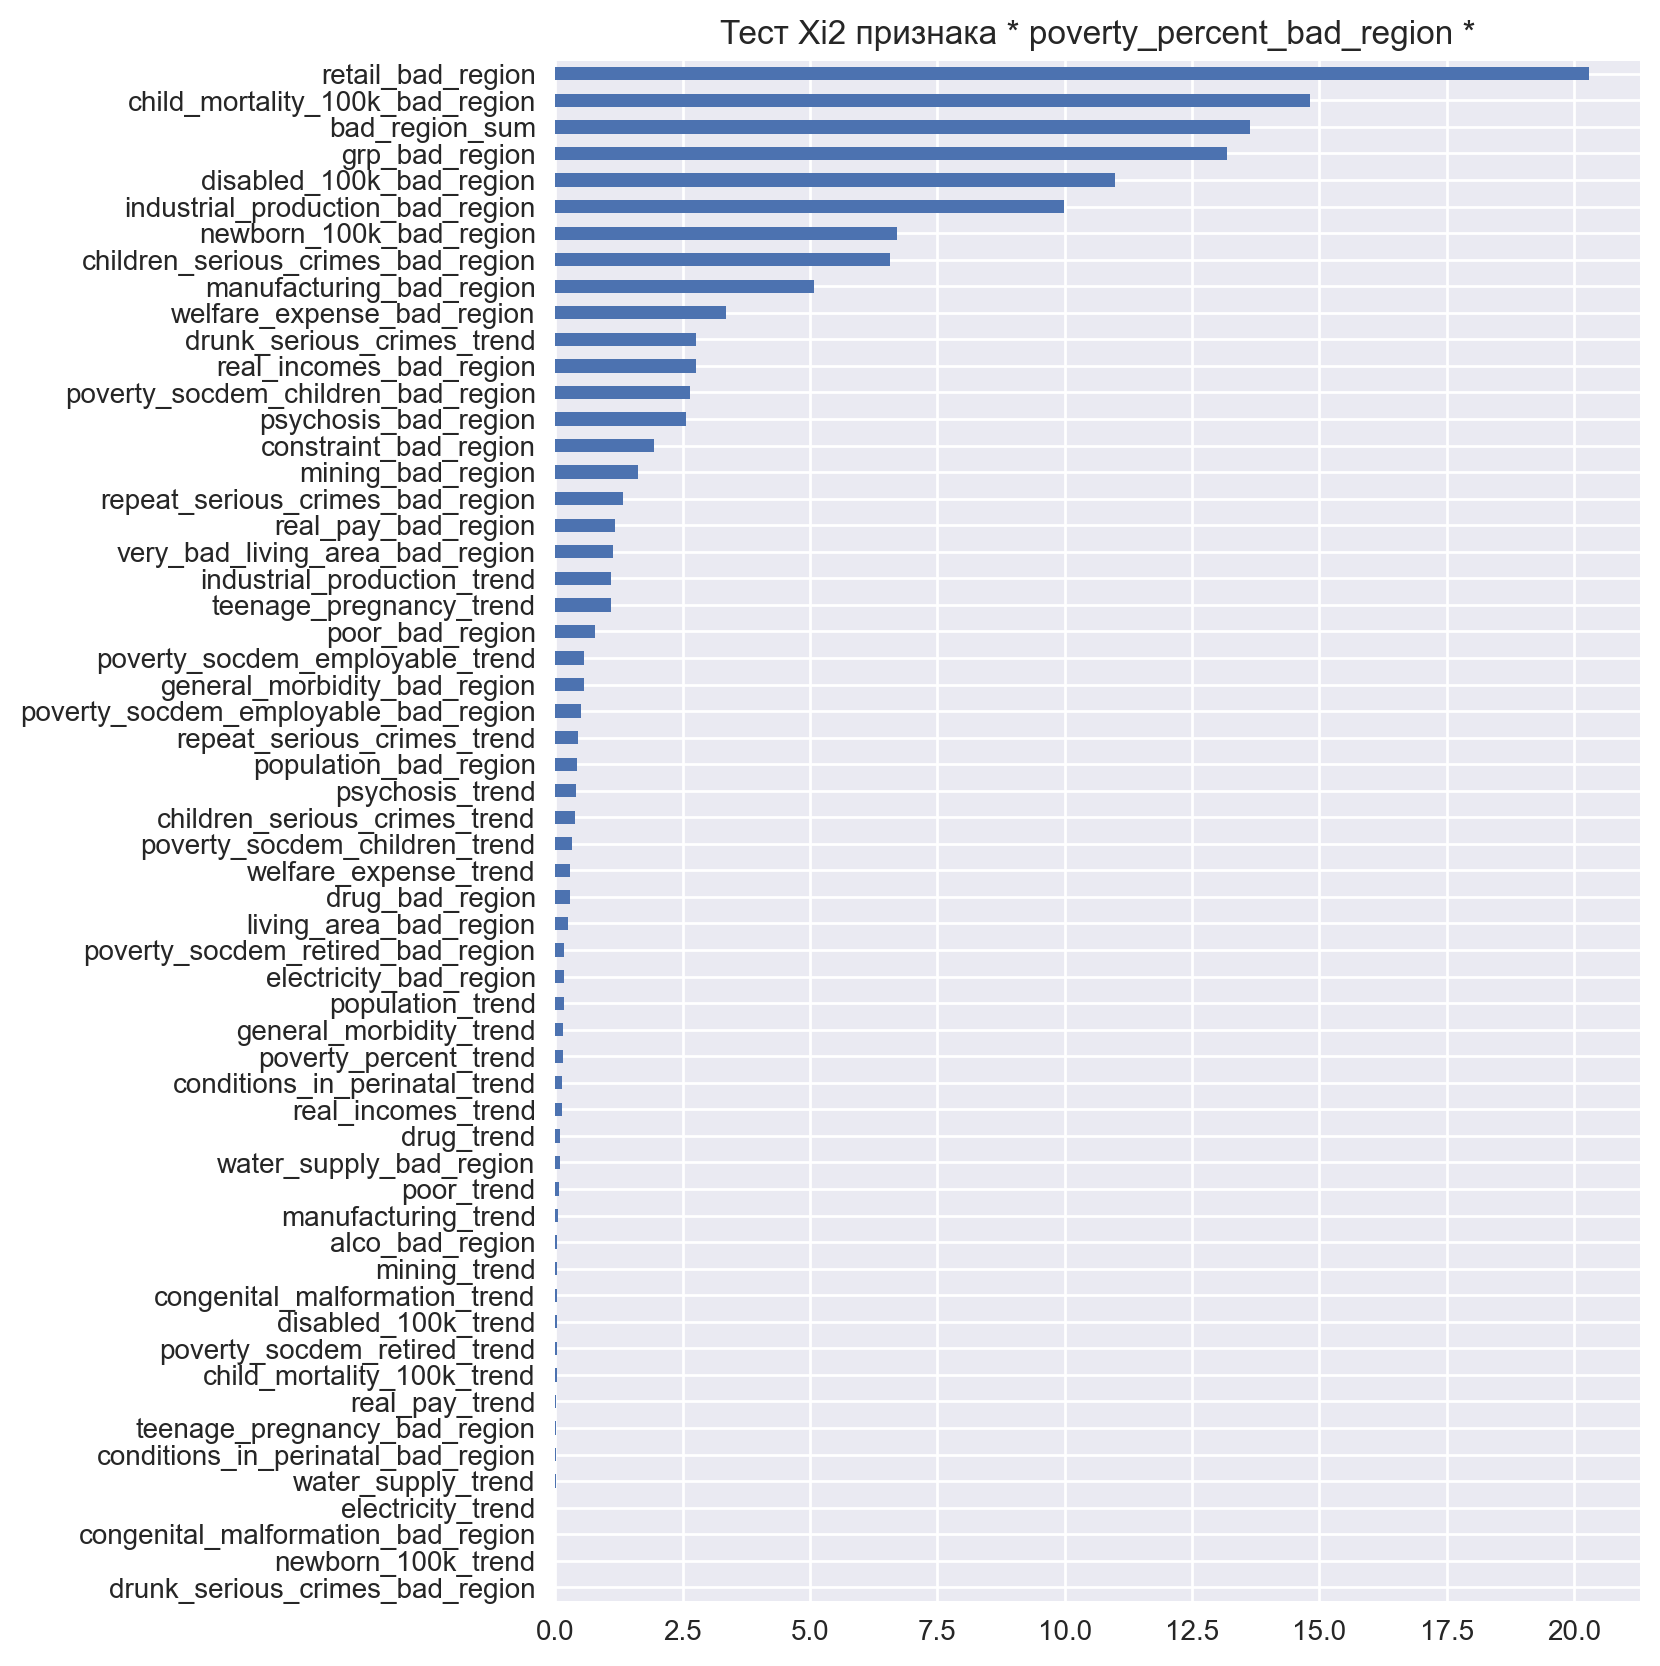

In [48]:
target_xi2_test(
    data=data[categorial_features].replace(-1,2), # замена -1 в признаке тренда на 2
    target='poverty_percent_bad_region', 
    width=7, height=10)

- сравним связь признака **poverty_percent_bad_region** и других бинарных признаков **_bad_region**, используя корреляцию Мэтьюса:

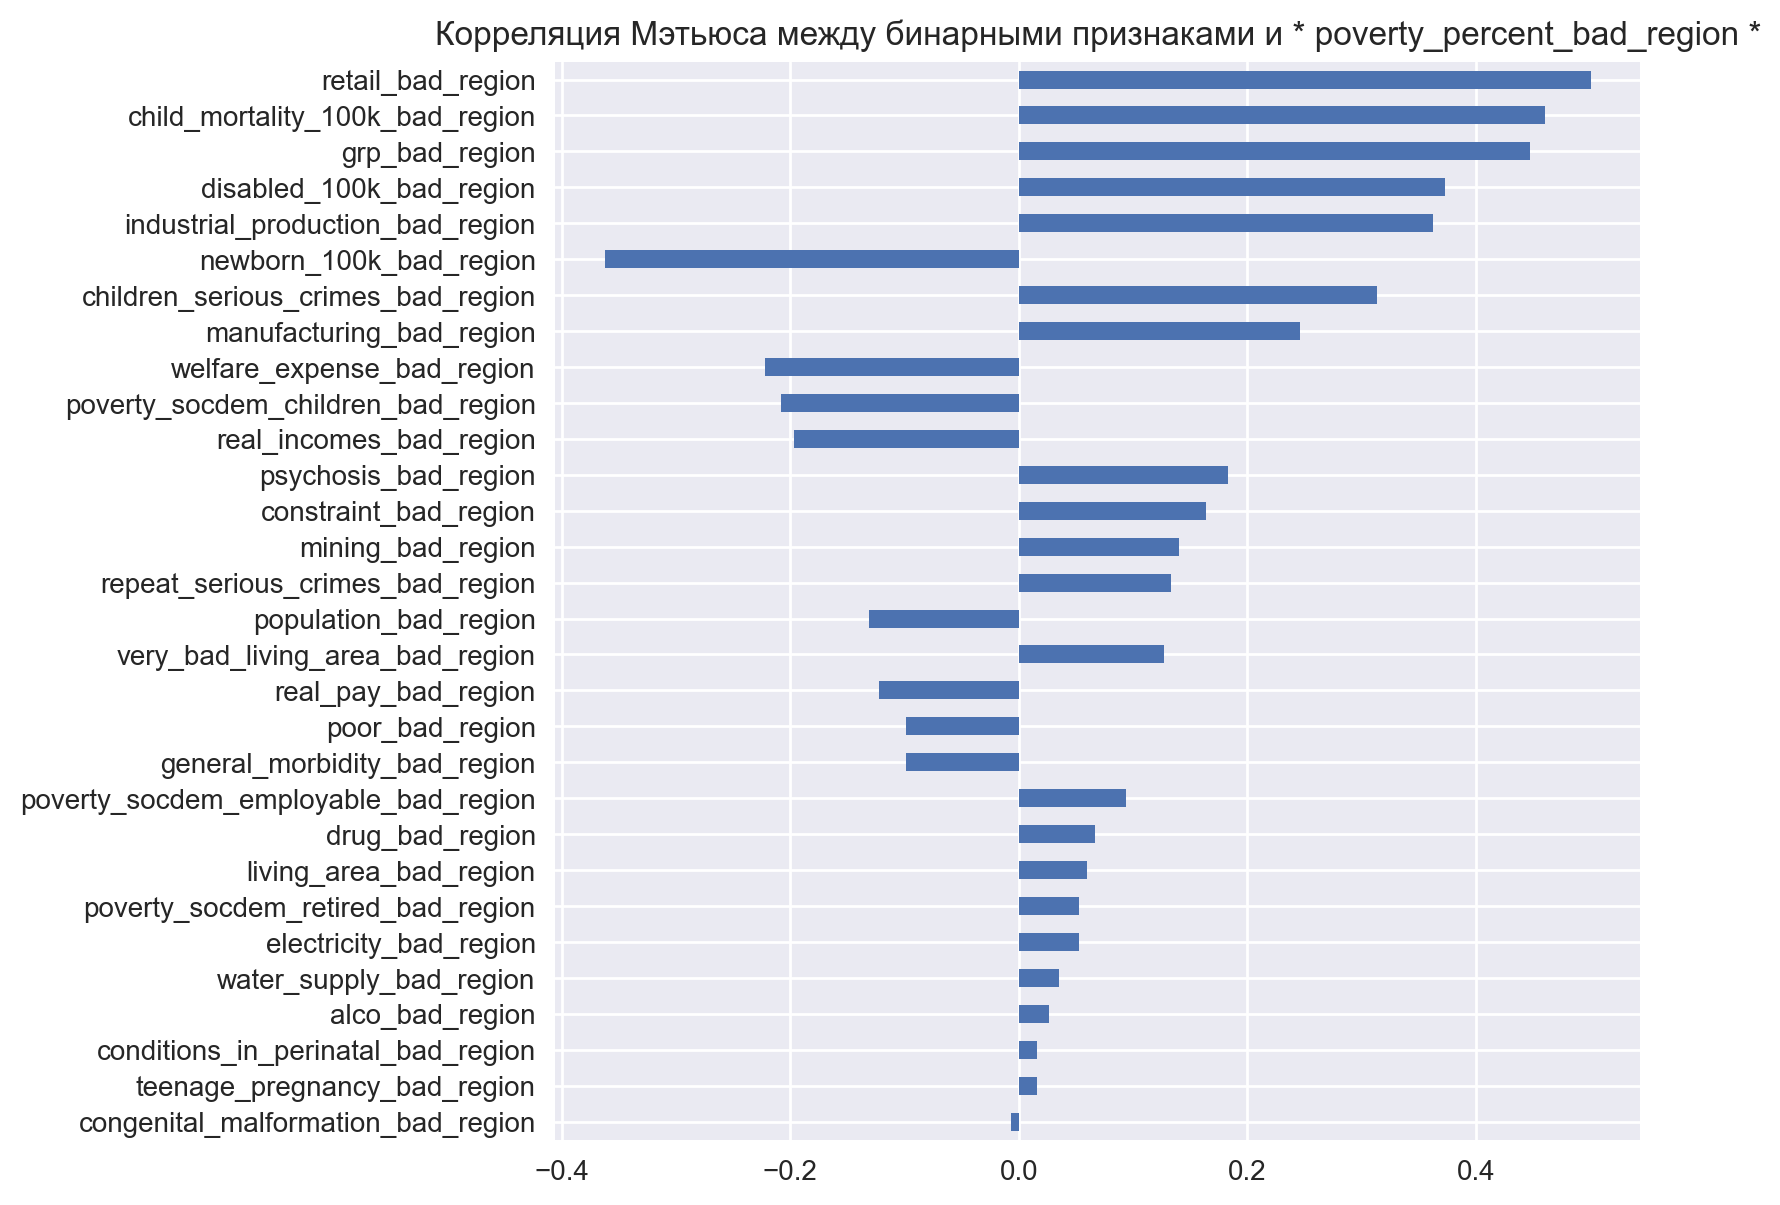

In [49]:
target_matthews_corrcoef(
    data=data, 
    binary_features=binary_features, 
    target='poverty_percent_bad_region', 
    width=7, height=7, top_number=30)

**Выводы:**
- по корреляциям Спирмена и Кендалла с ключевым признаком в топе следующие признаки:
    - **poverty_percent_bad_region**
    - **grp_bad_region**
    - **welfare_expense_bad_region** (отрицательная корреляция - почему?)
    - **retail_bad_region**
    - **child_mortality_100k**
- по тем же корреляциям производного ключевого признака **poverty_percent_trend** в топе:
    - **child_mortality_100k_trend**
    - **child_mortality_100k_bad_region**
    - **psychosis_bad_region**
- то же, но в тесте Xi2:
    - **child_mortality_100k_bad_region**
    - **psychosis_bad_region**
    - **repeat_serious_crimes_bad_region** (неожиданно!)
- по корреляциям Спирмена и Кендалла производного ключевого признака **poverty_percent_bad_region** в топе:
    - **retail_bad_region**
    - **child_mortality_100k_bad_region**
    - **grp_bad_region**
    - **disabled_100k_bad_region**
    - **psychosis_trend** (неожиданно!)
    - **industrial_production_bad_region**
    - **newborn_100k_bad_region** (отрицательная корреляция - тут понятно, см.выше)
    - **industrial_production_trend**
    - **children_serious_crimes_bad_region**
- то же, но в тесте Xi2:
    - **retail_bad_region**
    - **child_mortality_100k_bad_region**
    - **bad_region_sum**
    - **grp_bad_region**
    - **disabled_100k_bad_region**
    - **industrial_production_bad_region**
- то же, но в корреляции Мэтьюса для бинарных признаков (**bad_region**):
    - **retail_bad_region**
    - **child_mortality_100k_bad_region**
    - **grp_bad_region**
    - **disabled_100k_bad_region**
    - **industrial_production_bad_region**
    - **newborn_100k_bad_region** (отрицательная корреляция)
    - **children_serious_crimes_bad_region**

***
***

## 3. Feature selection

Отбираем признаки на основе следующих критериев:
- ключевой признак **poverty_percent**
- абсолютные цифры корреляции >=0.3 с ключевым признаком и его производными (ориентируемся больше на корреляцию Кендалла)
- не учитываем производные признаков **_per_of_rf** из-за мультиколлинеарности
- не учитываем признак **poor** и его производные из-за разумных сомнений в его достоверности
- не учитываем признак **welfare_expense**, т.к. его корреляция с ключевым признаком также аномальна

Отобраны следующие признаки:

In [50]:
features_for_clustering = [
    # Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)
    'poverty_percent', 
    # Реальная начисленная заработная плата, в процентах к предыдущему году
    'real_pay', 
    # Оборот розничной торговли на душу населения, в рублях.
    'retail',
    # Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    'industrial_production',
    # Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    'manufacturing',
    # Валовой региональный продукт на душу населения (рубль, значение показателя за год)
    'grp',
    # Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)
    'disabled_100k',
    # Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации
    #  загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    'water_supply',
    # Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.
    # (в тысячах рублей, значение показателя за год, полный круг)
    'electricity',

    # тренд реальных денежных доходов
    'real_incomes_trend', 
    # тренд психических расстройств и расстройств поведения
    'psychosis_trend',
    # тренд нромышленного производства
    'industrial_production_trend',
    # тренд детской смертности до 1 года
    'child_mortality_100k_trend',

    # признак суммы значений признаков bad_region
    'bad_region_sum',

    # плохой регион по детской смертности
    'child_mortality_100k_bad_region',
    # плохой регион по обороту розничной торговли
    'retail_bad_region',
    # плохой регион по валовому региональному продукту
    'grp_bad_region',
    # плохой регион по числу инвалидов (трудоспособное население)
    'disabled_100k_bad_region',
    # плохой регион по промышленному производству
    'industrial_production_bad_region',
    # плохой регион по числу новорожденных
    'newborn_100k_bad_region',
    # плохой регион по тяжким и особо тяжким преступлениям (несовершеннолетние)
    'children_serious_crimes_bad_region',
    # плохой регион по доле населения за чертой бедности
    'poverty_percent_bad_region',
    # плохой регион по психическим расстройствам и расстройствам поведения
    'psychosis_bad_region',
    # плохой регион по повторным преступлениям (тяжкие и особо тяжкие)
    'repeat_serious_crimes_bad_region',
    
]

***
***

## 4. Сохраним данные

Сохраним список с отобранными признаками:

In [51]:
with open("data_output/features_for_clustering.json", 'w') as f:
    json.dump(features_for_clustering, f, indent=2) 
 
f.close()

Сохраним обновленную сводную таблицу для кластеризации:

In [52]:
data.to_csv('data_output/data_final.csv', index=False)